In [1]:
%reload_ext autoreload
%autoreload 2

import os.path
import sys
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv

PARENT_DIR = r'D:\projects\diverters\src'
CURR_DIR = os.path.join(PARENT_DIR, 'conductivity_effect')
sys.path.append(PARENT_DIR)

import materials.sampling as sampling
import linearization.surface as surface
from materials.sampling import SampleMaterial
from parametric_solver.solver import BilinearThermalSolver, BilinearThermalSample, NodeContext

In [2]:
HEAT_LOADS = ['low', 'nominal', 'high']

# Initialize directories
OUT_DIR = os.path.join(CURR_DIR, 'out')
INP_DIR = os.path.join(CURR_DIR, 'in')

# Add sample points to solver
solver = BilinearThermalSolver(write_path=OUT_DIR, loglevel="INFO")

sims = [
    (SampleMaterial.W_3RHENIUM, SampleMaterial.W_3RHENIUM, False),
    (SampleMaterial.WL10, SampleMaterial.WL10, False),
    (SampleMaterial.WL10, SampleMaterial.PURE_W, False),
    (SampleMaterial.W_3RHENIUM, SampleMaterial.W_3RHENIUM, True),
    (SampleMaterial.WL10, SampleMaterial.PURE_W, True)
]

for conductivity, structural, plastic in sims:
    for case in HEAT_LOADS:
        sample = BilinearThermalSample()
        sample.name = f"{conductivity.value}_{structural.value}_{'plastic' if plastic else 'elastic'}_{case}"
        sample.input = os.path.join(INP_DIR, f"{conductivity.value}_{case}.inp")
        sampling.set_structural(sample, structural, plastic)
        solver.add_sample(sample)

# Solve at all sample points
solver.solve(verbose=False)

Solving [1/15]		Time Remaining: Unknown
Sample: kdoped_rhenium_kdoped_rhenium_elastic_low
Loading cached result from D:\projects\diverters\src\conductivity_effect\out\kdoped_rhenium_kdoped_rhenium_elastic_low.pkl ...
Solving [2/15]		Time Remaining:  0h:00m:14s
Sample: kdoped_rhenium_kdoped_rhenium_elastic_nominal
Loading cached result from D:\projects\diverters\src\conductivity_effect\out\kdoped_rhenium_kdoped_rhenium_elastic_nominal.pkl ...
Solving [3/15]		Time Remaining:  0h:00m:13s
Sample: kdoped_rhenium_kdoped_rhenium_elastic_high
Loading cached result from D:\projects\diverters\src\conductivity_effect\out\kdoped_rhenium_kdoped_rhenium_elastic_high.pkl ...
Solving [4/15]		Time Remaining:  0h:00m:12s
Sample: wl10_roedig_wl10_roedig_elastic_low
Loading cached result from D:\projects\diverters\src\conductivity_effect\out\wl10_roedig_wl10_roedig_elastic_low.pkl ...
Solving [5/15]		Time Remaining:  0h:00m:11s
Sample: wl10_roedig_wl10_roedig_elastic_nominal
Loading cached result from D:\

In [3]:
def get_result(_conductivity, _structural, _plastic, _case):
    return solver.result_from_name(f"{_conductivity.value}_{_structural.value}_{'plastic' if _plastic else 'elastic'}_{_case}")


def max_eqv_stresses(_conductivity, _structural, _plastic, _nodes=None):
    max_stresses = []
    for _case in HEAT_LOADS:
        _result = get_result(_conductivity, _structural, _plastic, _case)
        
        if not _nodes:
            _nodes = _result.valid_nodes()

        max_stresses.append(max([_result.eqv_stress(node) for node in _nodes]))

    return max_stresses

def plot_bar_graph(_data, title, stress=True):
    labels = ['3% Re, 3% Re (E)', 'WL10, WL10 (E)', 'WL10, W (E)', '3% Re, 3% Re (P)', 'WL10, W (P)']
    bar_width = 0.25
    spacing = 0.3
    indexes = np.arange(len(_data))
    
    for i in range(3):
        plt.bar(indexes + i * bar_width, [item[i] for item in _data], bar_width)
    
    plt.xticks(indexes + bar_width, labels)
    plt.xticks(rotation=45)
    plt.subplots_adjust(bottom=0.25)
    plt.title(title)
    
    if stress:
        plt.ylabel("Max Stress (MPa)")
    else:
        plt.ylabel("Max Strain (m/m)")
    
    plt.show()

def plot_eqv_stresses(title, _nodes=None):
    eqv_stress_data = []
    for sim in sims:
        print(f"Conductivity: {sim[0].value}, Structural: {sim[1].value}, {'plastic' if sim[2] else 'elastic'}")
        stresses = max_eqv_stresses(*sim, _nodes=_nodes)
    
        sim_eqv_data = []
        for case, stress in zip(HEAT_LOADS, stresses):
            sim_eqv_data.append(stress)
            print(f"{case}: {stress} MPa")
    
        eqv_stress_data.append(sim_eqv_data)
        print()
    
    plot_bar_graph(eqv_stress_data, title)

In [4]:
nodeContext = NodeContext(r"D:\projects\diverters\src\conductivity_effect\in\kdoped_rhenium_high.inp")
nodeContext.add_component('cool_surf1')
nodeContext.add_component('cool_surf2')
nodeContext.run()

press_bound_nodes = nodeContext.nodes('cool_surf1') + nodeContext.nodes('cool_surf2')
print(f"Read {len(press_bound_nodes)} pressure boundary nodes.")

Connecting to APDL ...
Connected.
Caching cool_surf1 ...
Caching cool_surf2 ...
Read 885 pressure boundary nodes.


Conductivity: kdoped_rhenium, Structural: kdoped_rhenium, elastic
low: 134.41245231432544 MPa
nominal: 286.5786793845908 MPa
high: 161.76573008178818 MPa

Conductivity: wl10_roedig, Structural: wl10_roedig, elastic
low: 158.16153783065784 MPa
nominal: 533.6695927804905 MPa
high: 268.1783021060437 MPa

Conductivity: wl10_roedig, Structural: pure_w, elastic
low: 94.2364551528983 MPa
nominal: 258.6056852101882 MPa
high: 138.8729932360881 MPa

Conductivity: kdoped_rhenium, Structural: kdoped_rhenium, plastic
low: 134.5226983120925 MPa
nominal: 286.76219514879017 MPa
high: 162.12269264336115 MPa

Conductivity: wl10_roedig, Structural: pure_w, plastic
low: 94.27423501833677 MPa
nominal: 258.7076748361277 MPa
high: 139.19858153508972 MPa



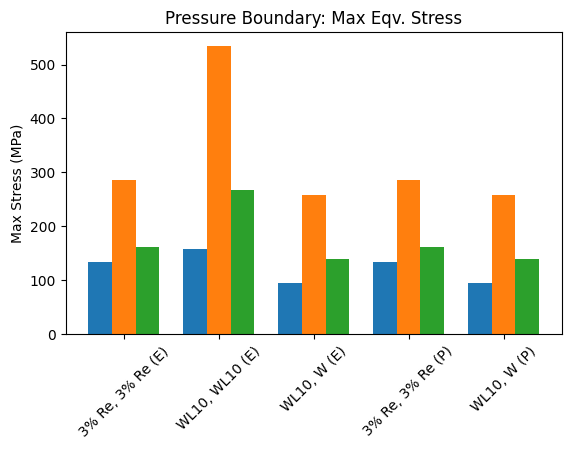

In [5]:
plot_eqv_stresses("Pressure Boundary: Max Eqv. Stress", _nodes=press_bound_nodes)

Conductivity: kdoped_rhenium, Structural: kdoped_rhenium, elastic
low: 113.1628099778214 MPa
nominal: 251.66641991535175 MPa
high: 143.43886461978747 MPa

Conductivity: wl10_roedig, Structural: wl10_roedig, elastic
low: 136.55394807459666 MPa
nominal: 478.55309607900426 MPa
high: 241.65676189783744 MPa

Conductivity: wl10_roedig, Structural: pure_w, elastic
low: 77.20250219005283 MPa
nominal: 226.4881291003292 MPa
high: 120.90613542638951 MPa

Conductivity: kdoped_rhenium, Structural: kdoped_rhenium, plastic
low: 113.30751902923782 MPa
nominal: 251.8702222397566 MPa
high: 143.77644695176406 MPa

Conductivity: wl10_roedig, Structural: pure_w, plastic
low: 77.2537457858111 MPa
nominal: 226.6016407649491 MPa
high: 121.21500312719786 MPa



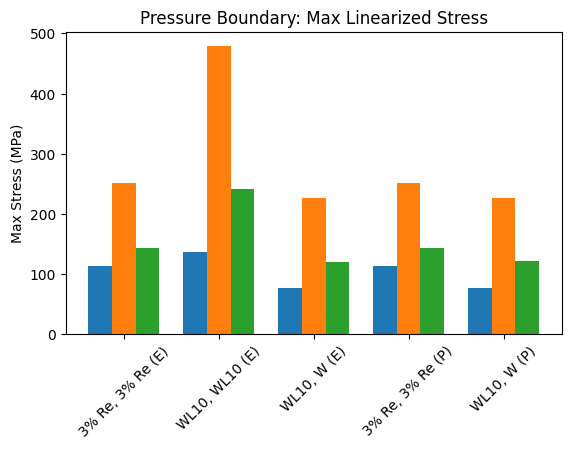

Conductivity: kdoped_rhenium, Structural: kdoped_rhenium, elastic
low: 61.21492166193156 MPa
nominal: 129.0525229654936 MPa
high: 78.98810420565835 MPa

Conductivity: wl10_roedig, Structural: wl10_roedig, elastic
low: 72.57121328463074 MPa
nominal: 239.46547745233178 MPa
high: 130.26554077108864 MPa

Conductivity: wl10_roedig, Structural: pure_w, elastic
low: 43.69198959780449 MPa
nominal: 116.6405844925916 MPa
high: 67.86189083018708 MPa

Conductivity: kdoped_rhenium, Structural: kdoped_rhenium, plastic
low: 61.28667068576811 MPa
nominal: 129.1546096684845 MPa
high: 79.15907519244274 MPa

Conductivity: wl10_roedig, Structural: pure_w, plastic
low: 43.71572880360395 MPa
nominal: 116.69693558614503 MPa
high: 68.01835630639042 MPa



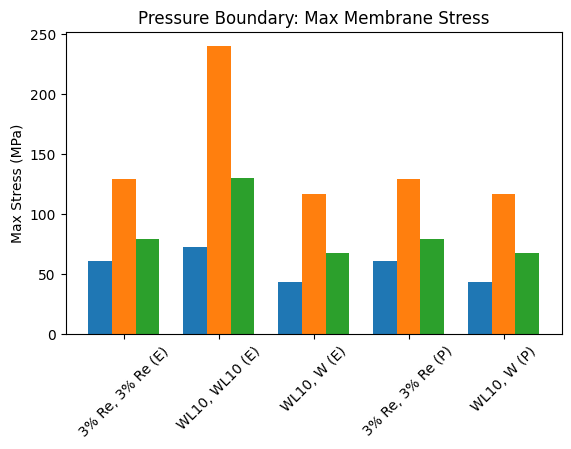

Conductivity: kdoped_rhenium, Structural: kdoped_rhenium, elastic
low: 51.947888315889834 MPa
nominal: 122.61389694985814 MPa
high: 64.4507604141291 MPa

Conductivity: wl10_roedig, Structural: wl10_roedig, elastic
low: 63.982734789965924 MPa
nominal: 239.08761862667245 MPa
high: 111.39122112674879 MPa

Conductivity: wl10_roedig, Structural: pure_w, elastic
low: 33.510512592248325 MPa
nominal: 109.84754460773759 MPa
high: 53.044244596202425 MPa

Conductivity: kdoped_rhenium, Structural: kdoped_rhenium, plastic
low: 52.02084834346971 MPa
nominal: 122.71561257127209 MPa
high: 64.6173717593213 MPa

Conductivity: wl10_roedig, Structural: pure_w, plastic
low: 33.53801698220715 MPa
nominal: 109.90470517880408 MPa
high: 53.19664682080744 MPa



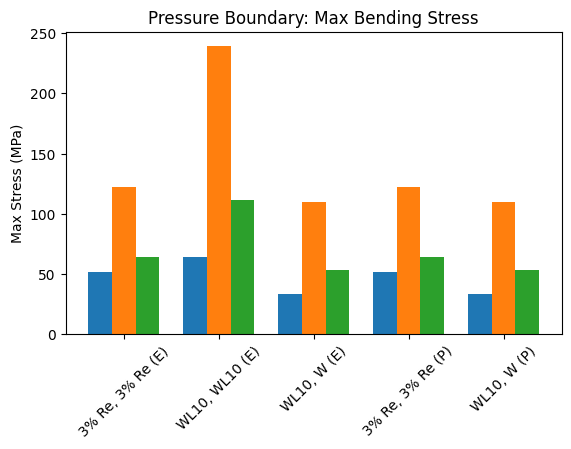

In [6]:
def read_node_data():
    node_data = []
    with open("D:\\projects\\diverters\\src\\results\\hemj_v2\\line_nodes_side.txt") as f:
        for line in f:
            try:
                _data = line.split()
                node_data.append([int(_data[0]), float(_data[1]), float(_data[2]), float(_data[3])])
            except ValueError:
                continue
    node_data.sort(key=lambda x: x[3])
    return node_data

def eval_linear_stress(_result, node_data, mode='linear'):
    nodes = [_data[0] for _data in node_data]
    positions = np.array([[_data[1], _data[2], _data[3]] for _data in node_data])
    
    if mode == 'linear':
        linear_stresses = _result.linearized_stress_tensor(nodes, positions)
    elif mode == 'membrane':
        linear_stresses = _result.membrane_stress_tensor(nodes, positions)
    elif mode == 'bending':
        linear_stresses = _result.bending_stress_tensor(nodes, positions)
    else:
        linear_stresses = None
        
    linear_von_mises = [tensor for tensor in linear_stresses]
    return max(linear_von_mises)

def max_lin_stresses(_conductivity, _structural, _plastic, _nodes=None, mode='linear'):
    max_stresses = []
    for _case in HEAT_LOADS:
        _result = get_result(_conductivity, _structural, _plastic, _case)
        max_stresses.append(eval_linear_stress(_result, node_data, mode=mode))

    return max_stresses

def plot_lin_stresses(title, _nodes=None, mode='linear'):
    eqv_stress_data = []
    for sim in sims:
        print(f"Conductivity: {sim[0].value}, Structural: {sim[1].value}, {'plastic' if sim[2] else 'elastic'}")
        stresses = max_lin_stresses(*sim, _nodes=_nodes, mode=mode)
    
        sim_eqv_data = []
        for case, stress in zip(HEAT_LOADS, stresses):
            sim_eqv_data.append(stress)
            print(f"{case}: {stress} MPa")
    
        eqv_stress_data.append(sim_eqv_data)
        print()
    
    plot_bar_graph(eqv_stress_data, title)
    
%node_data = read_node_data()
%plot_lin_stresses("Pressure Boundary: Max Linearized Stress")
%plot_lin_stresses("Pressure Boundary: Max Membrane Stress", mode='membrane')
%plot_lin_stresses("Pressure Boundary: Max Bending Stress", mode='bending')

In [7]:
def sample_name(_conductivity, _structural, _plastic, _case):
    return f"{_conductivity.value}_{_structural.value}_{'plastic' if _plastic else 'elastic'}_{_case}"


def plot_property(_result, _property, _label, _title, _filename, stress_result):
    if _property == 'total':
        property_result = stress_result['membrane'] + stress_result['bending']
    else:
        property_result = stress_result[_property]

    point_cloud = pv.PolyData(stress_result["location"])
    point_cloud[_label] = property_result

    plotter = pv.Plotter()
    plotter.add_mesh(point_cloud, cmap='turbo', point_size=12)
    plotter.view_vector((10, 10, 10), (0, 0, 0))
    plotter.camera.roll = 240
    plotter.add_title(_title)
    plotter.render()
    plotter.screenshot(_filename + '_' + _property + '.png')
    plotter.show(jupyter_backend='static')

    
def plot_linearization(stress):
    NODES_DIR = os.path.join(PARENT_DIR, 'inp', 'nodes')
    TOP_SURFACE_PATH = os.path.join(NODES_DIR, 'ts.node.loc')
    BOTTOM_SURFACE_PATH = os.path.join(NODES_DIR, 'bs.node.loc')
    ALL_LOCS_PATH = os.path.join(NODES_DIR, 'all.node.loc')
    
    membrane_data = []
    bending_data = []
    linearized_data = []
    
    for conductivity, structural, plastic in sims:
        membrane_curr = []
        bending_curr = []
        linearized_curr = []
    
        for case in HEAT_LOADS:
            sample = BilinearThermalSample()
            curr_name = sample_name(conductivity, structural, plastic, case)
            curr_result = solver.result_from_name(curr_name)
            
            if stress:
                dataframe = curr_result.stress_dataframe()
            else:
                dataframe = curr_result.strain_dataframe()
            
            stress_result = surface.linearize_surface(
                TOP_SURFACE_PATH,
                BOTTOM_SURFACE_PATH,
                dataframe,
                ALL_LOCS_PATH,
                None
            )
    
            print(f"Conductivity: {conductivity.value}")
            print(f"Structural: {structural.value}")
            print(f"Type: {'Plastic' if plastic else 'Elastic'}")
            print(f"Heat Loading: {case}")
    
            if stress:
                unit_label = "Stress (MPa)"
                mode = "Stress"
            else:
                unit_label = "Strain (m/m)"
                mode = "Strain"
    
            plot_property(stress_result, "membrane", unit_label, f"Membrane {mode}", curr_name, stress_result)
            plot_property(stress_result, "bending", unit_label, f"Bending {mode}", curr_name, stress_result)
            plot_property(stress_result, "total", unit_label, f"Linearized {mode}", curr_name, stress_result)
    
            total_result = stress_result['membrane'] + stress_result['bending']
    
            membrane_curr.append(max(stress_result['membrane']))
            bending_curr.append(max(stress_result['bending']))
            linearized_curr.append(max(total_result))
    
        print(f"Max Membrane: {membrane_curr}")
        print(f"Max Bending: {bending_curr}")
        print(f"Max Linearized: {linearized_curr}")
        print("____________________________________")
        membrane_data.append(membrane_curr)
        bending_data.append(bending_curr)
        linearized_data.append(linearized_curr)
        
    return membrane_data, bending_data, linearized_data

Conductivity: kdoped_rhenium
Structural: kdoped_rhenium
Type: Elastic
Heat Loading: low


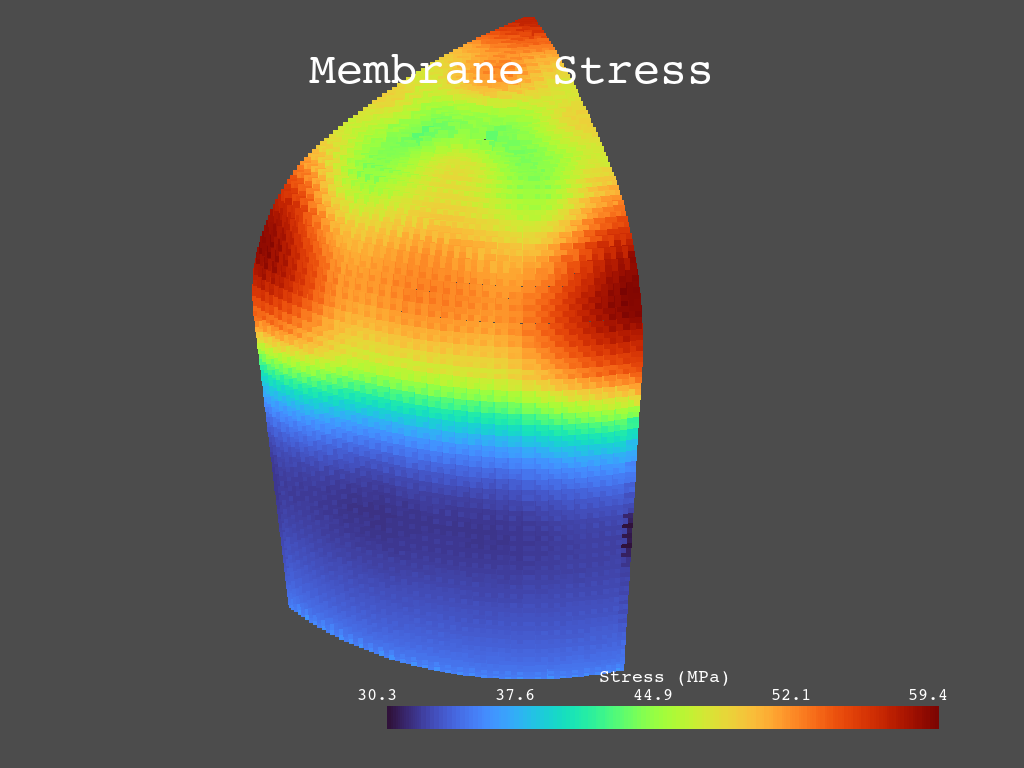

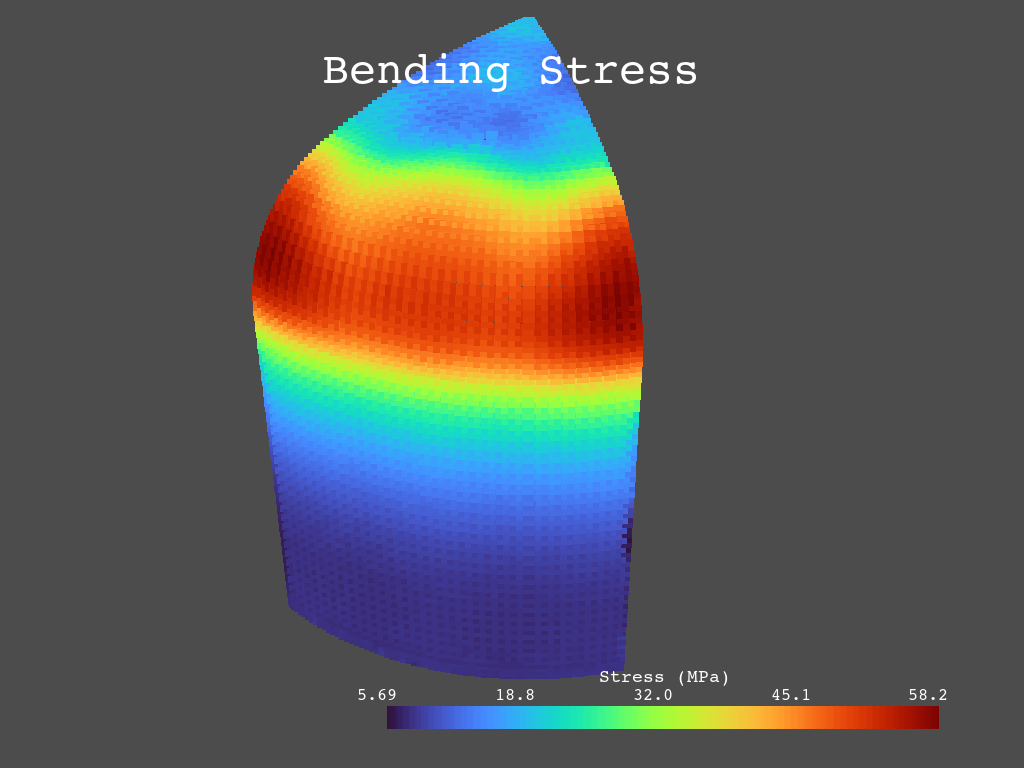

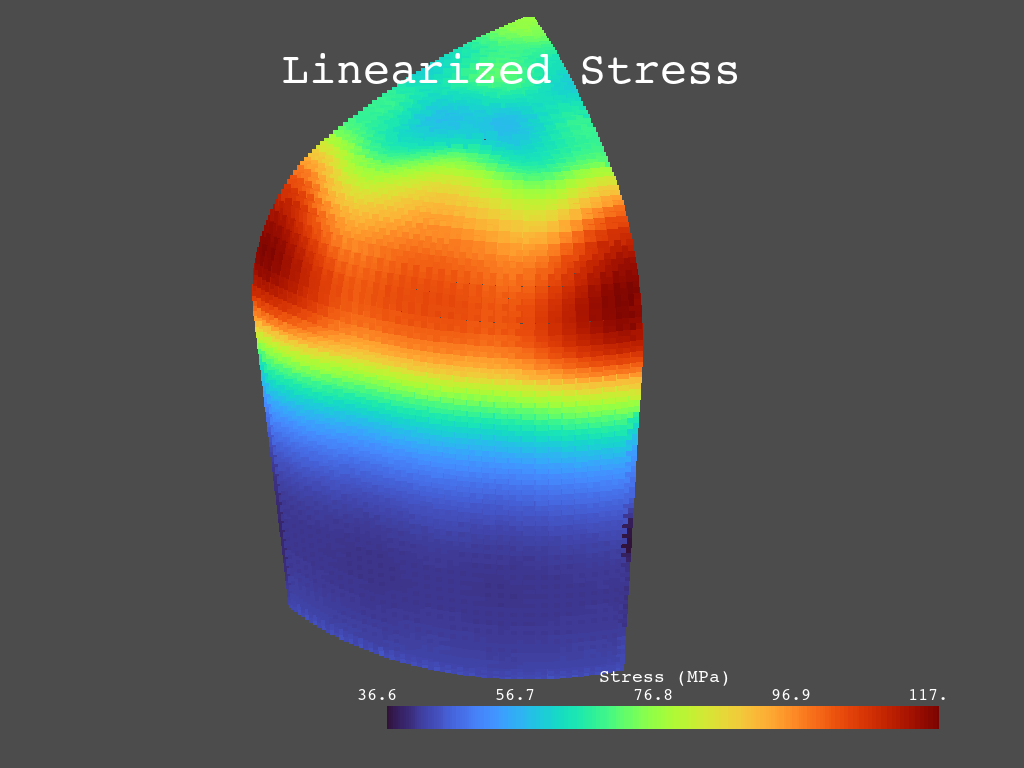

Conductivity: kdoped_rhenium
Structural: kdoped_rhenium
Type: Elastic
Heat Loading: nominal


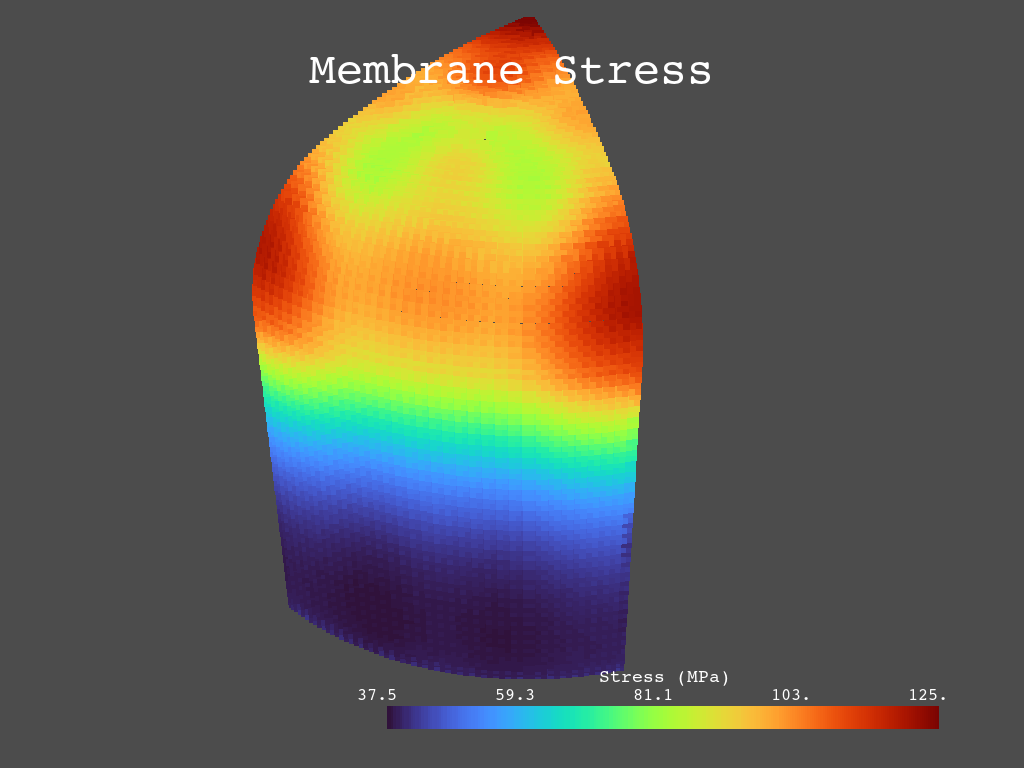

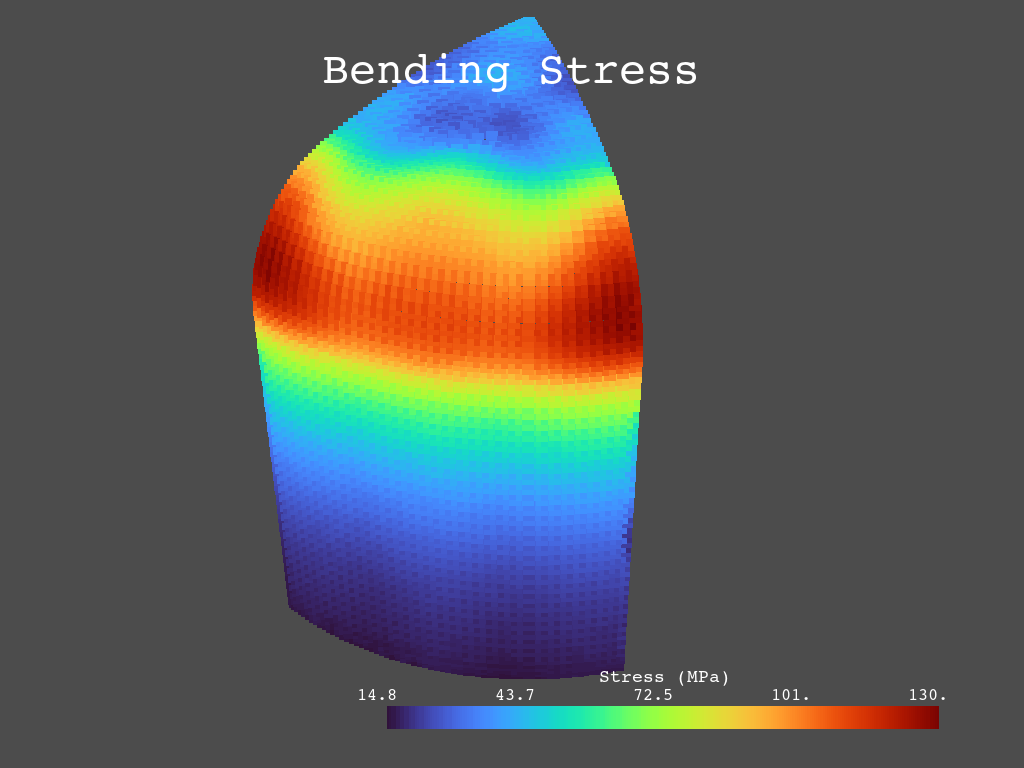

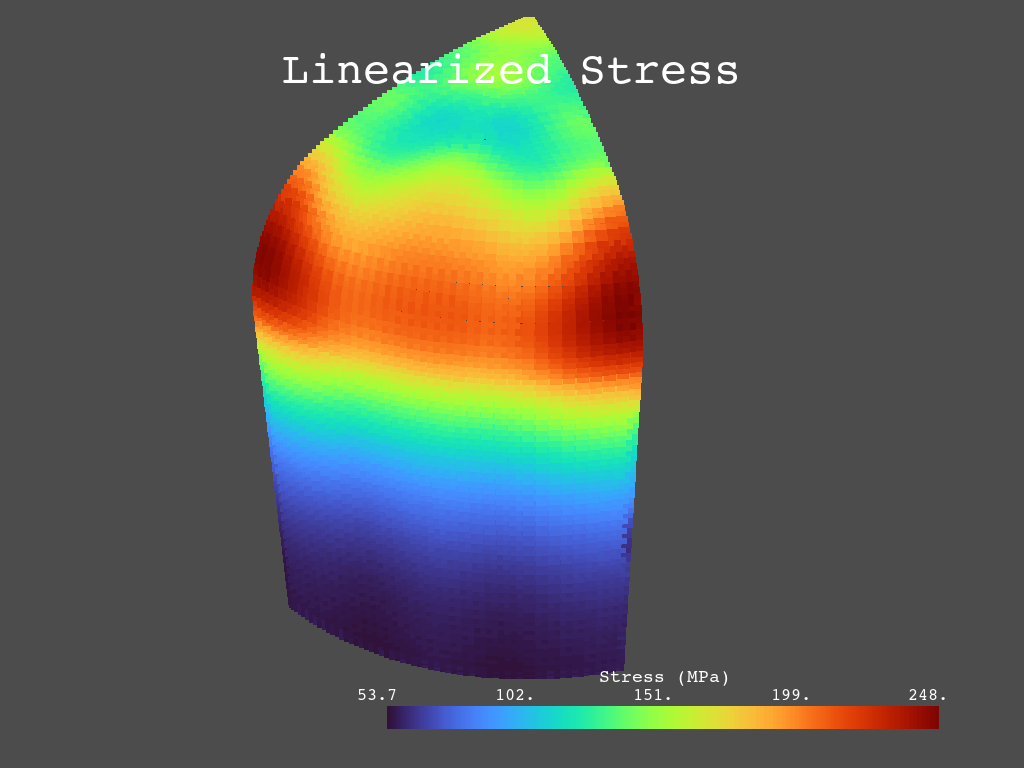

Conductivity: kdoped_rhenium
Structural: kdoped_rhenium
Type: Elastic
Heat Loading: high


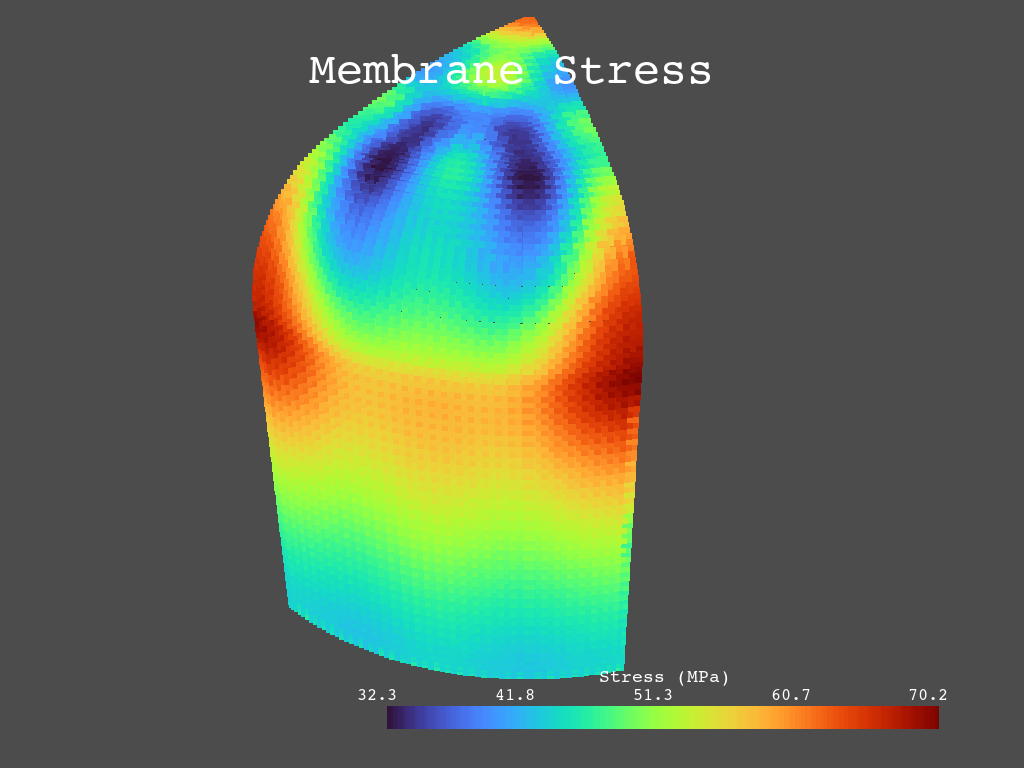

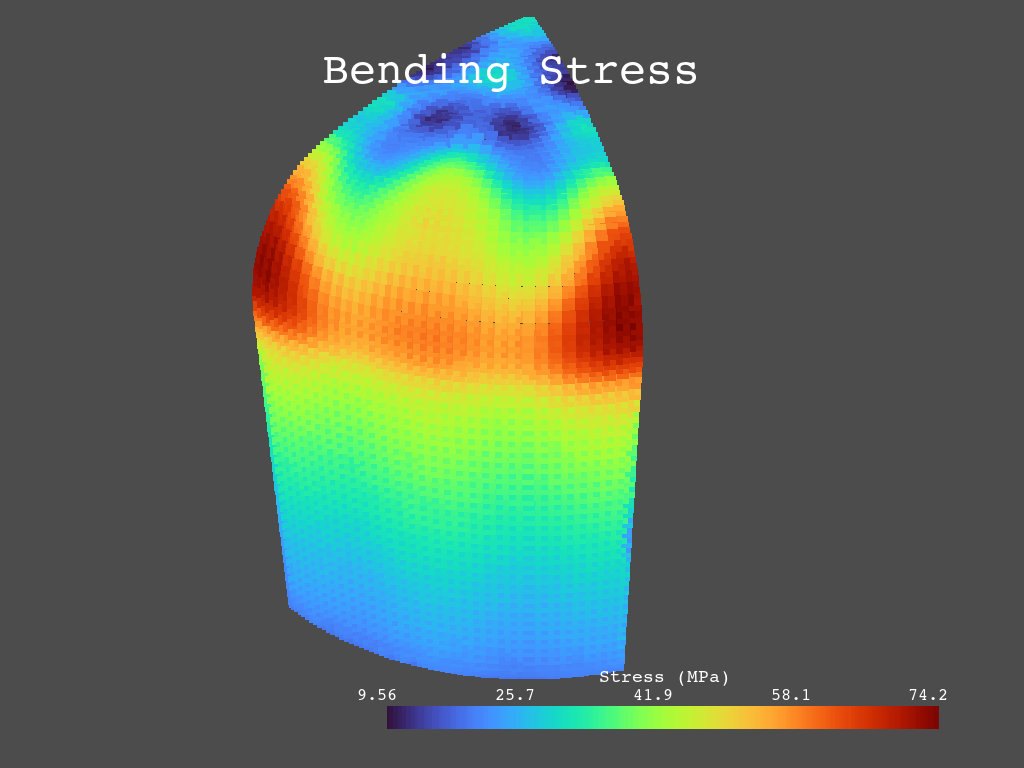

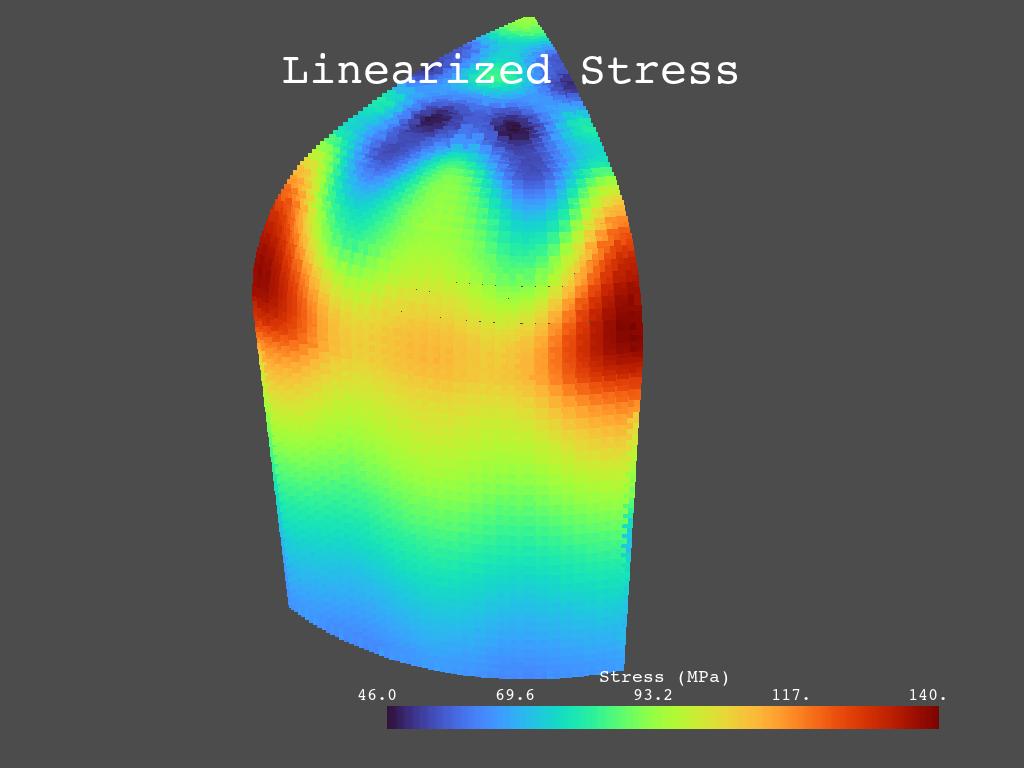

Max Membrane: [59.39136477227528, 124.69849087654613, 70.20154864567799]
Max Bending: [58.23888756579461, 130.27400599556708, 74.2251748005876]
Max Linearized: [116.95643042906327, 247.90025065996966, 140.32947001347716]
____________________________________
Conductivity: wl10_roedig
Structural: wl10_roedig
Type: Elastic
Heat Loading: low


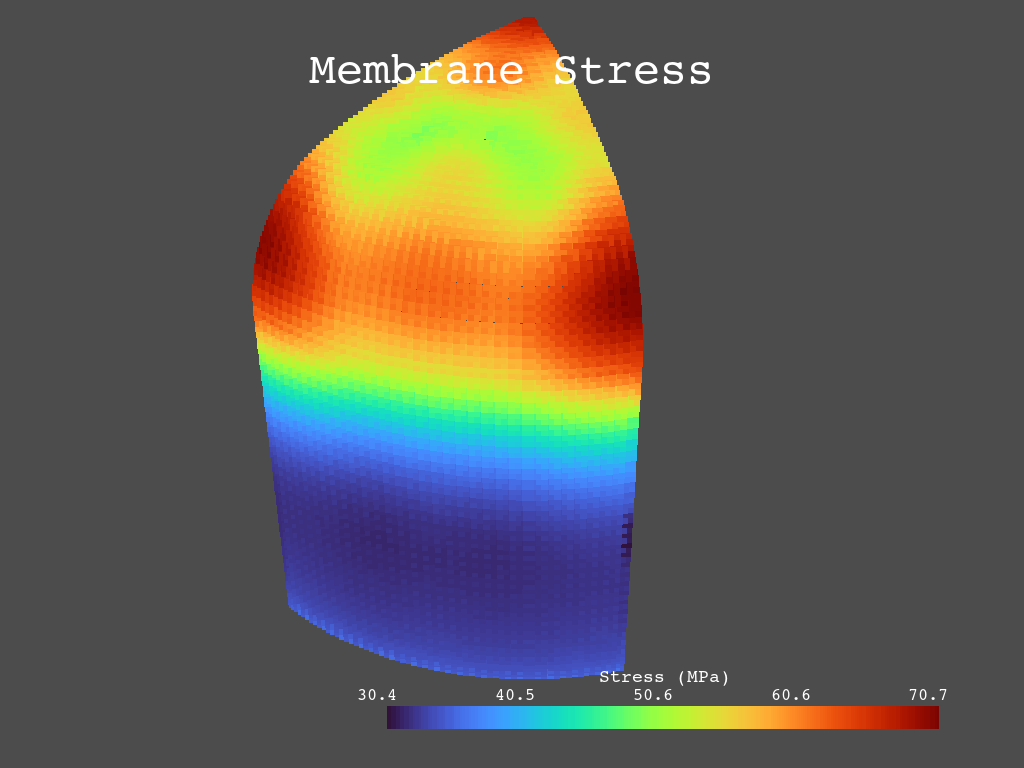

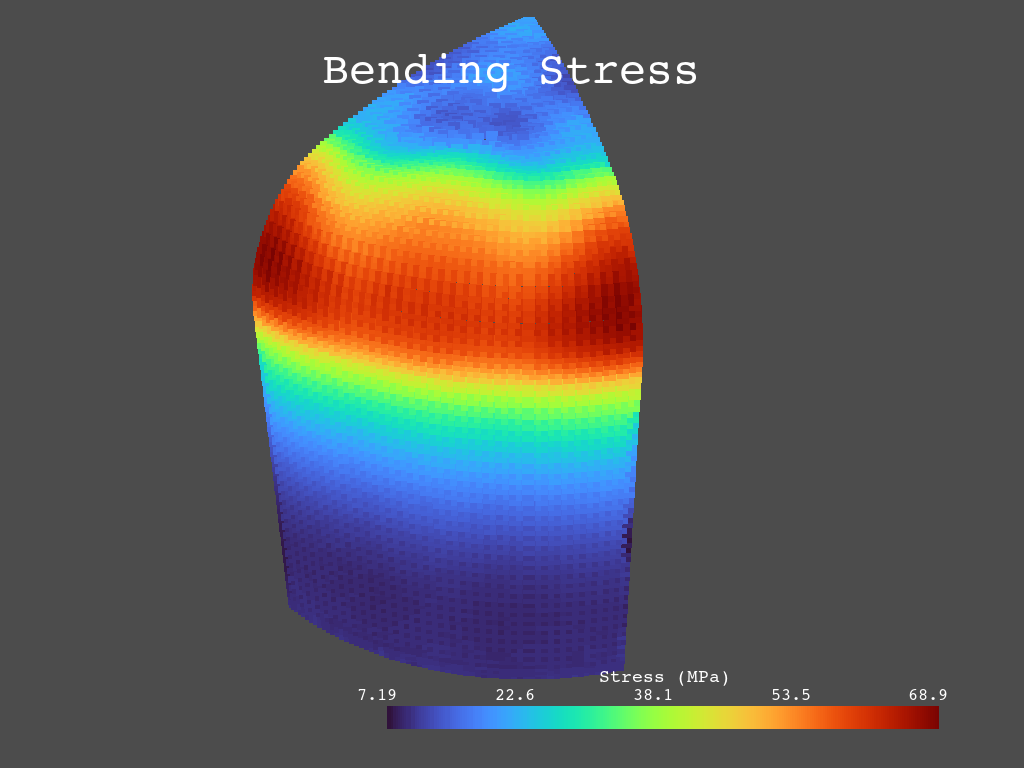

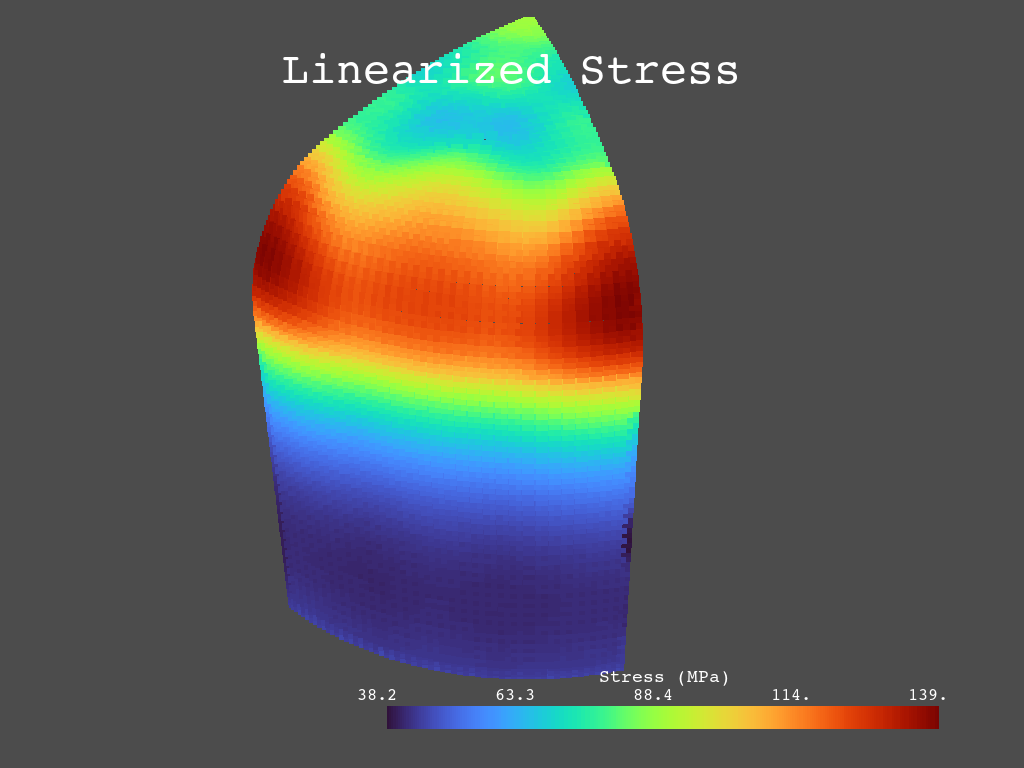

Conductivity: wl10_roedig
Structural: wl10_roedig
Type: Elastic
Heat Loading: nominal


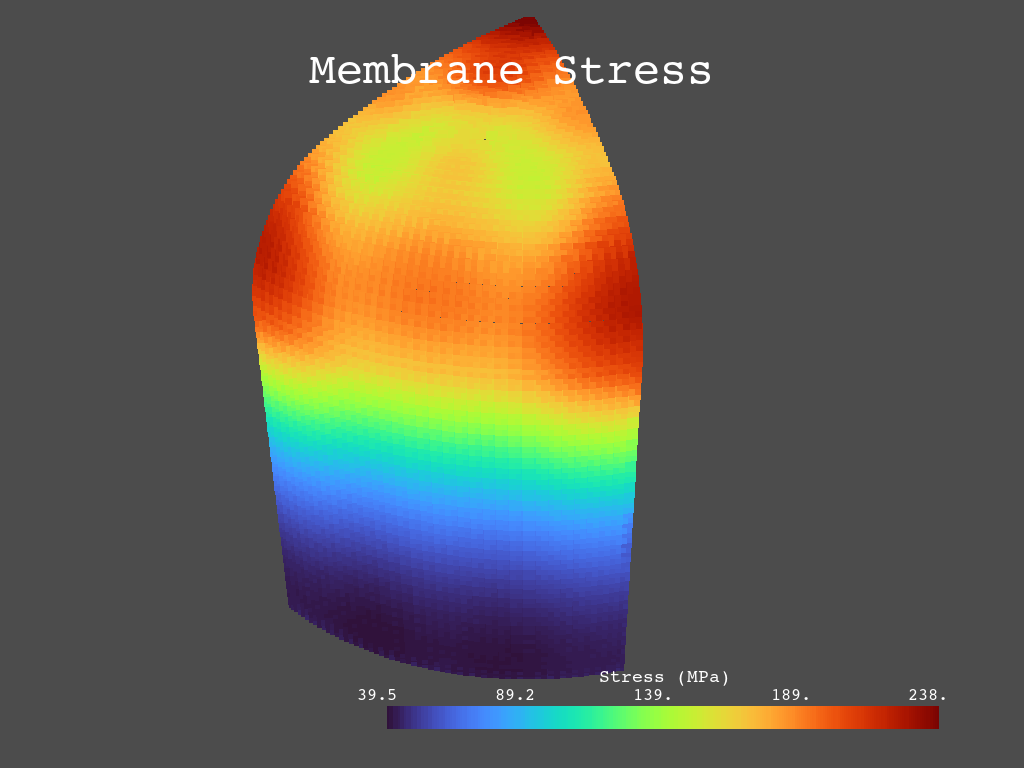

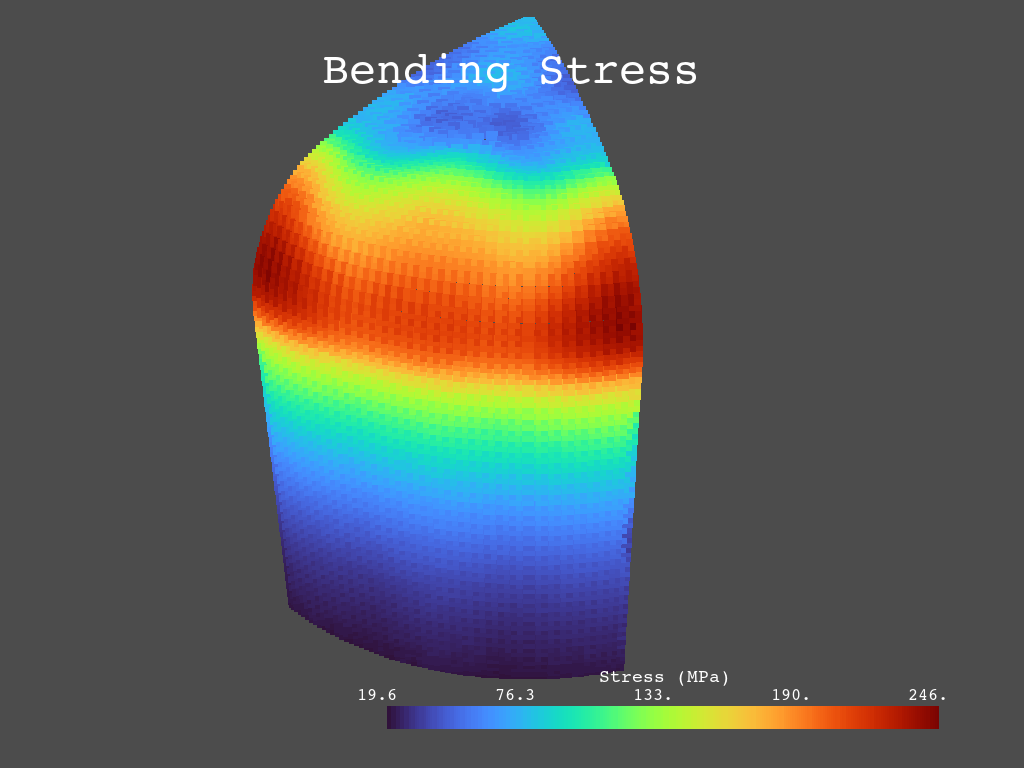

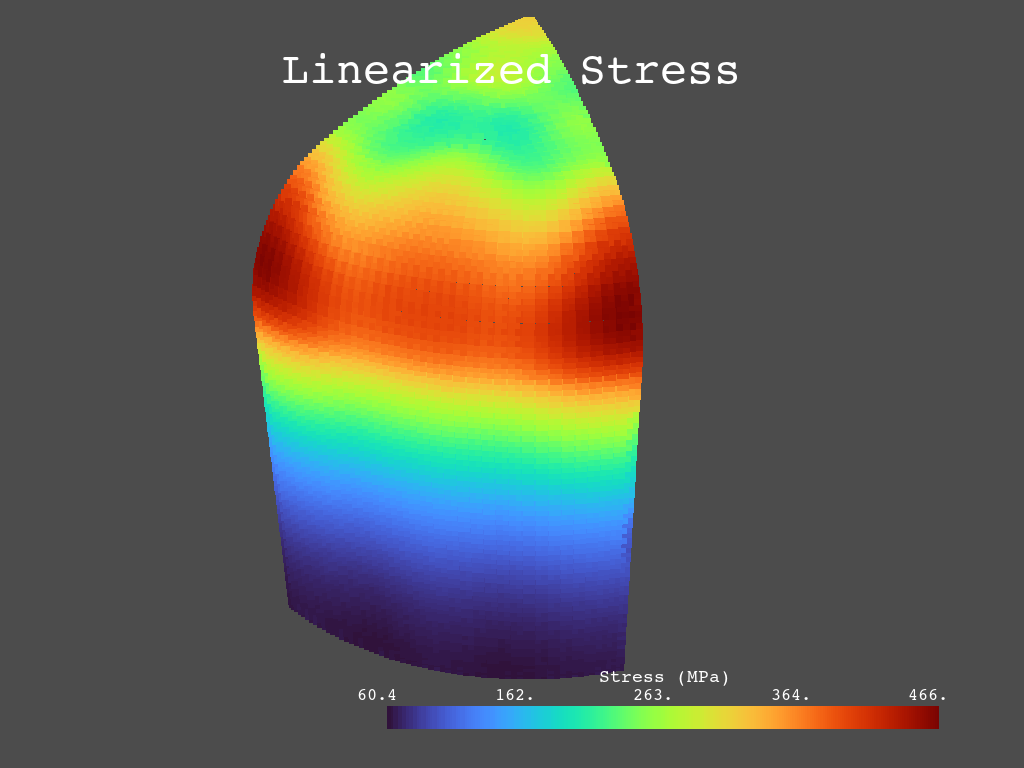

Conductivity: wl10_roedig
Structural: wl10_roedig
Type: Elastic
Heat Loading: high


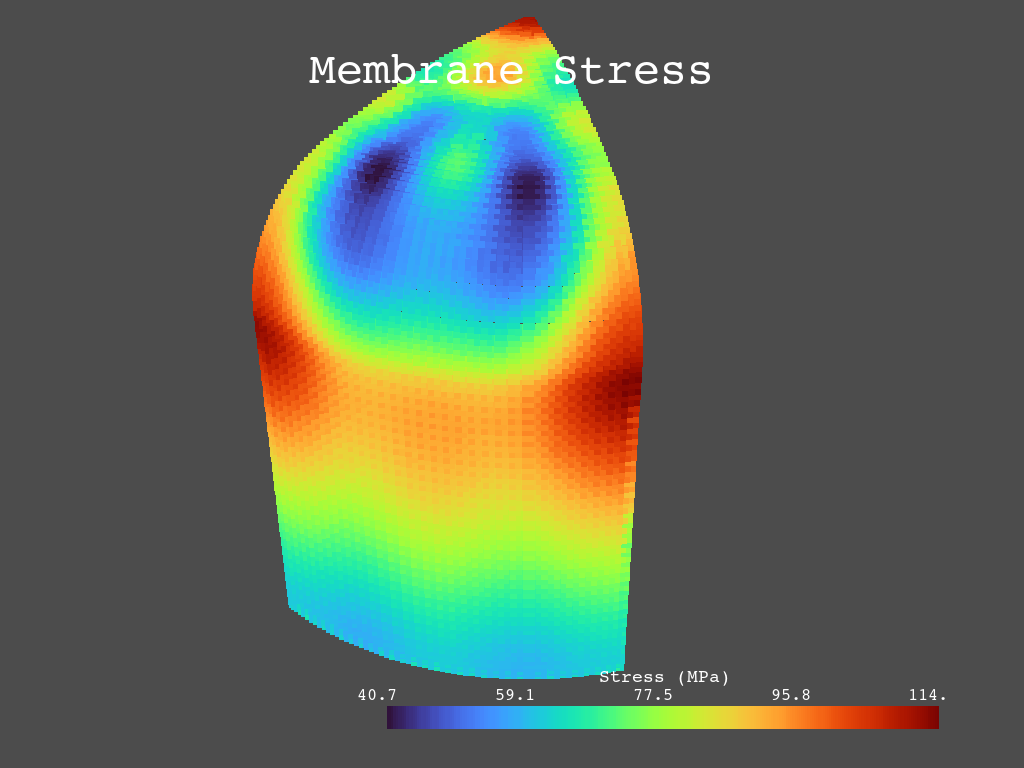

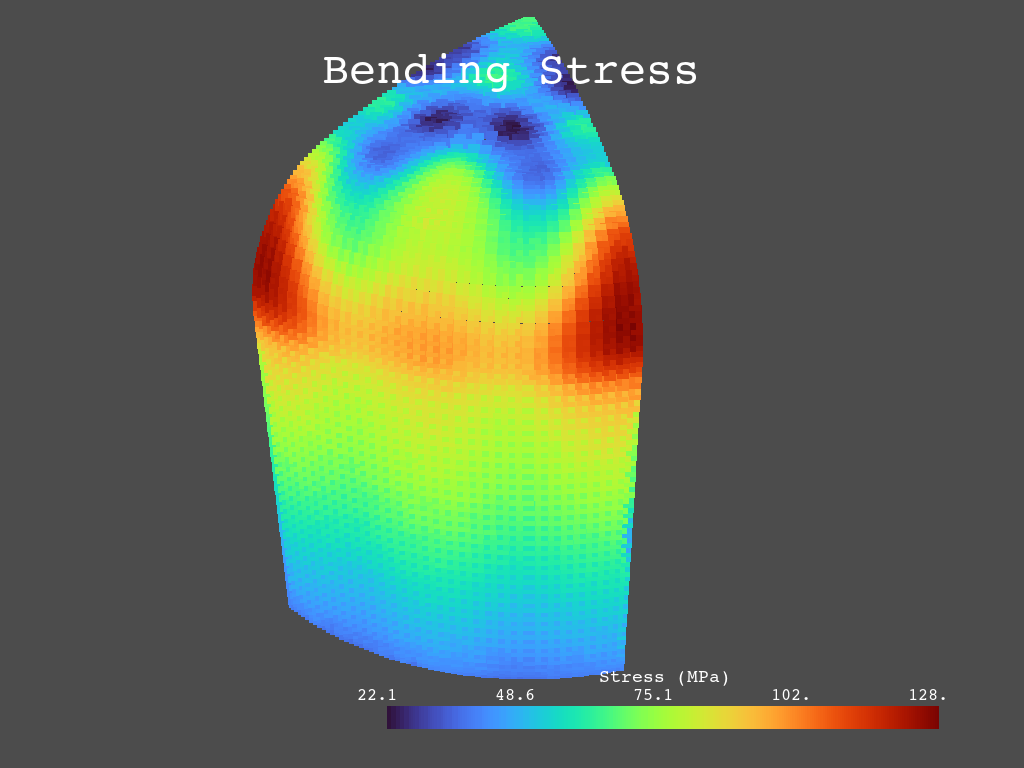

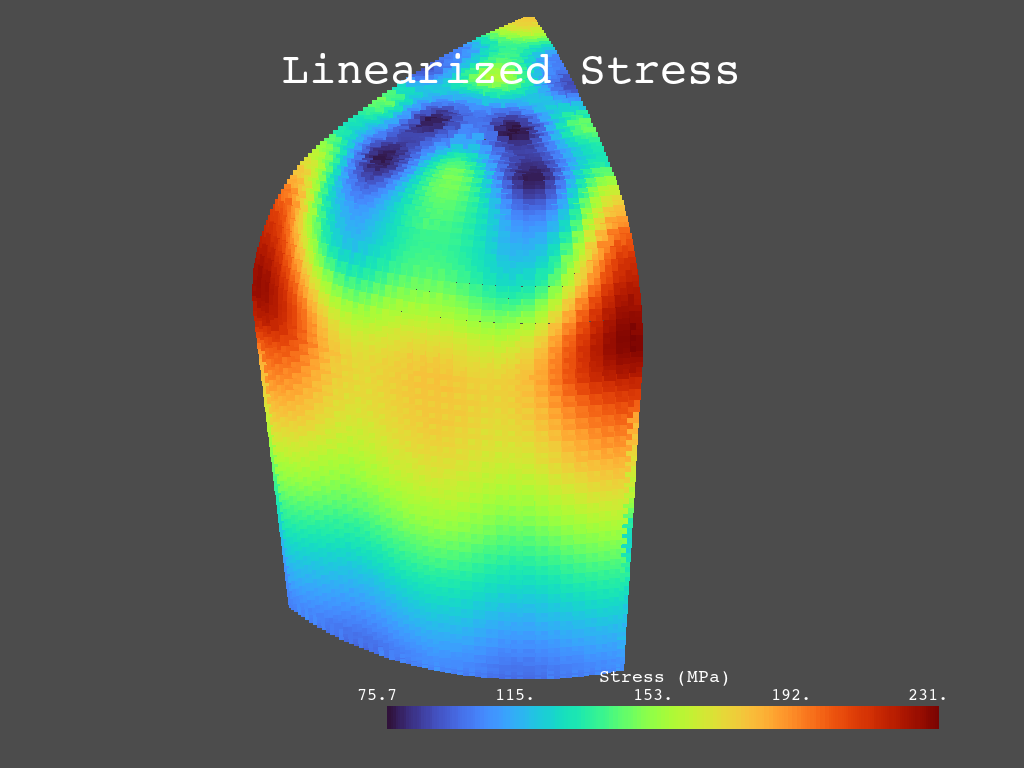

Max Membrane: [70.7317478768601, 238.17589336551296, 114.20646991920795]
Max Bending: [68.9380998272326, 246.37109673404888, 128.20546700012255]
Max Linearized: [138.64229094231956, 465.8017746404205, 231.2238172921387]
____________________________________
Conductivity: wl10_roedig
Structural: pure_w
Type: Elastic
Heat Loading: low


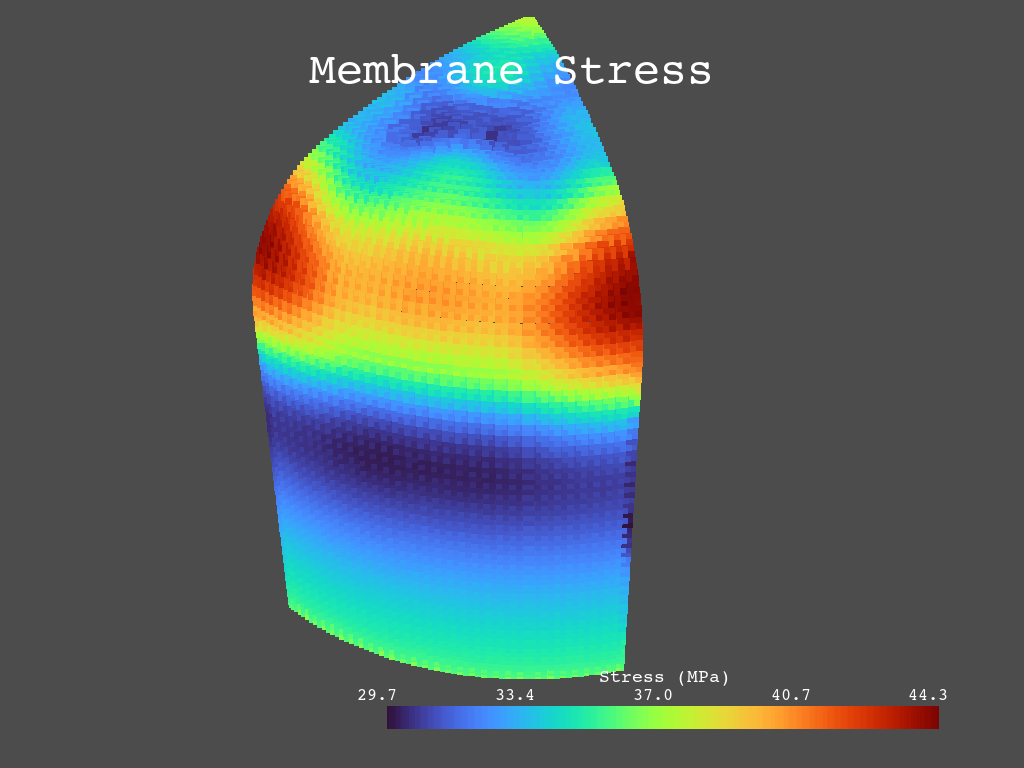

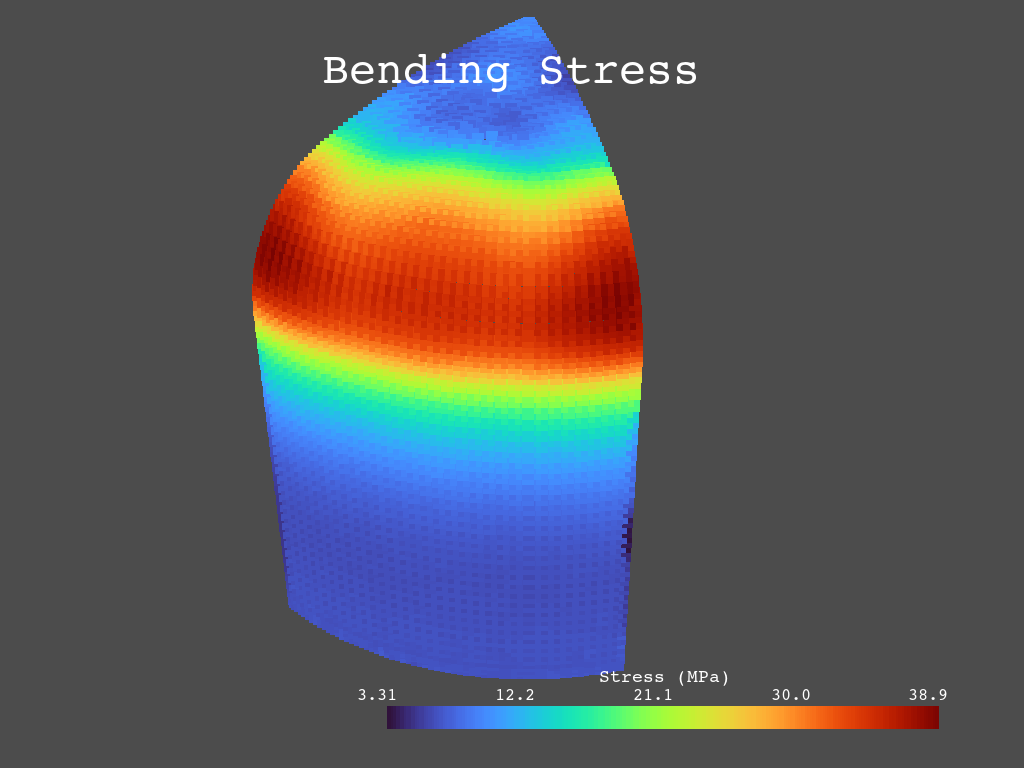

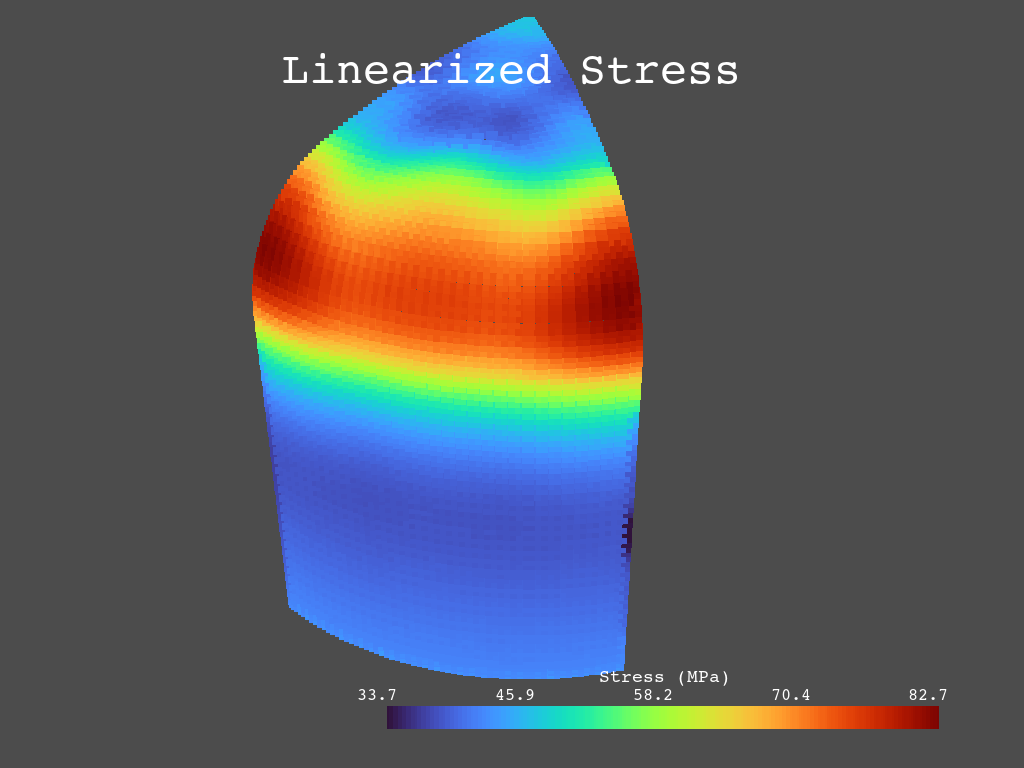

Conductivity: wl10_roedig
Structural: pure_w
Type: Elastic
Heat Loading: nominal


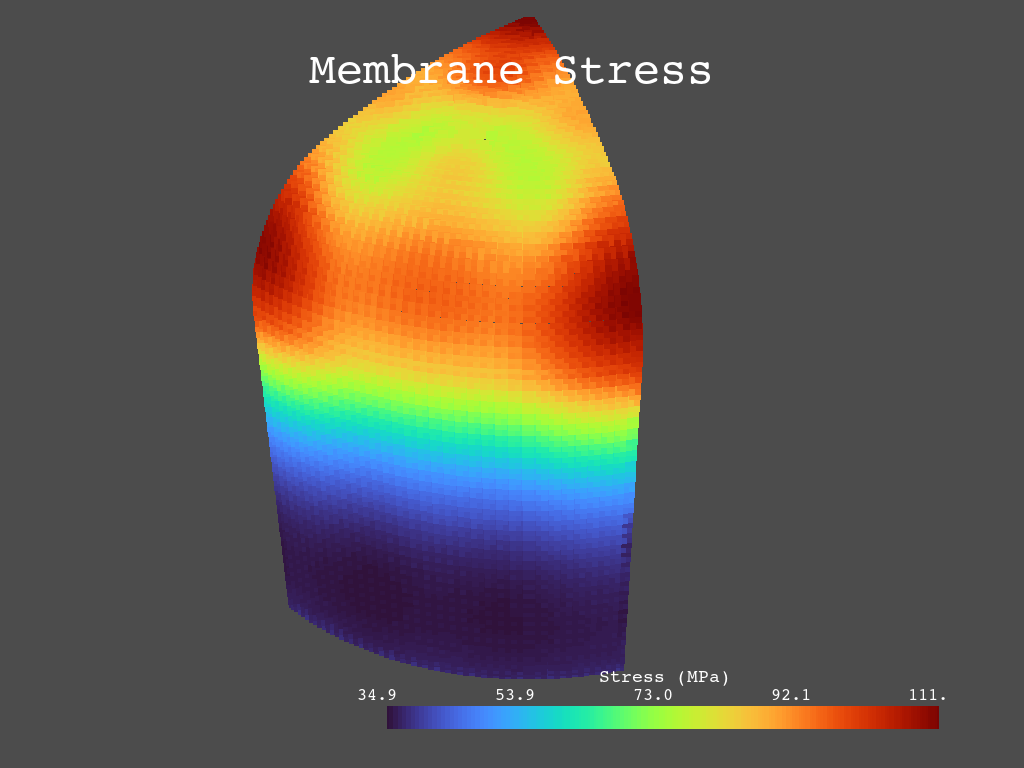

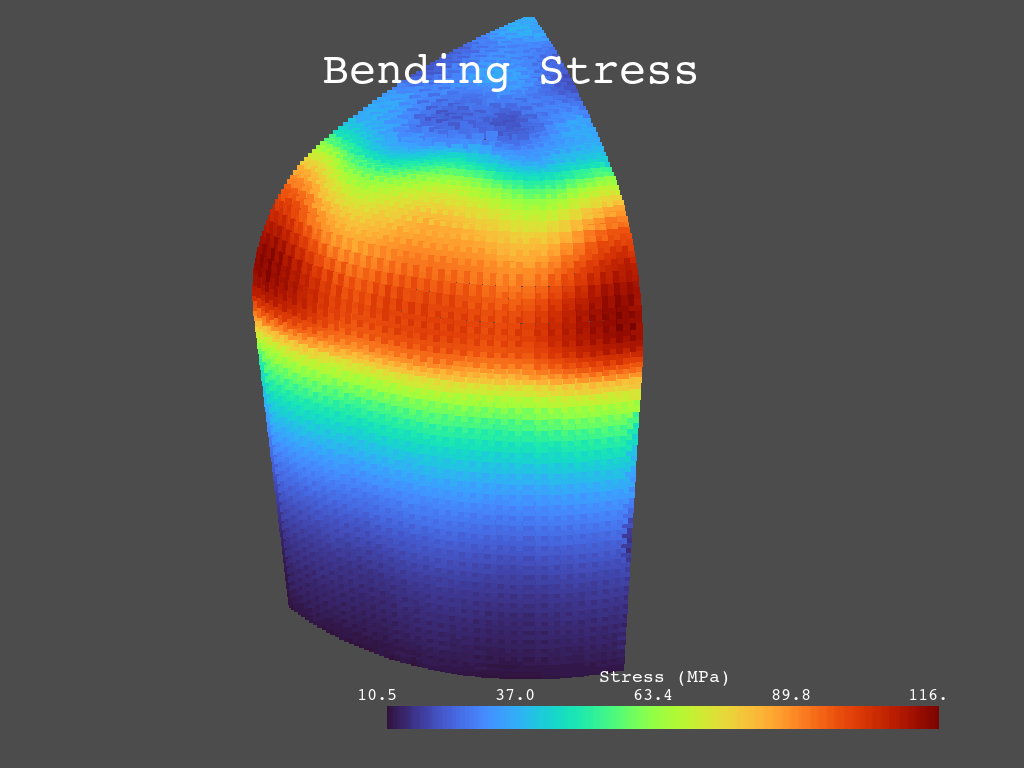

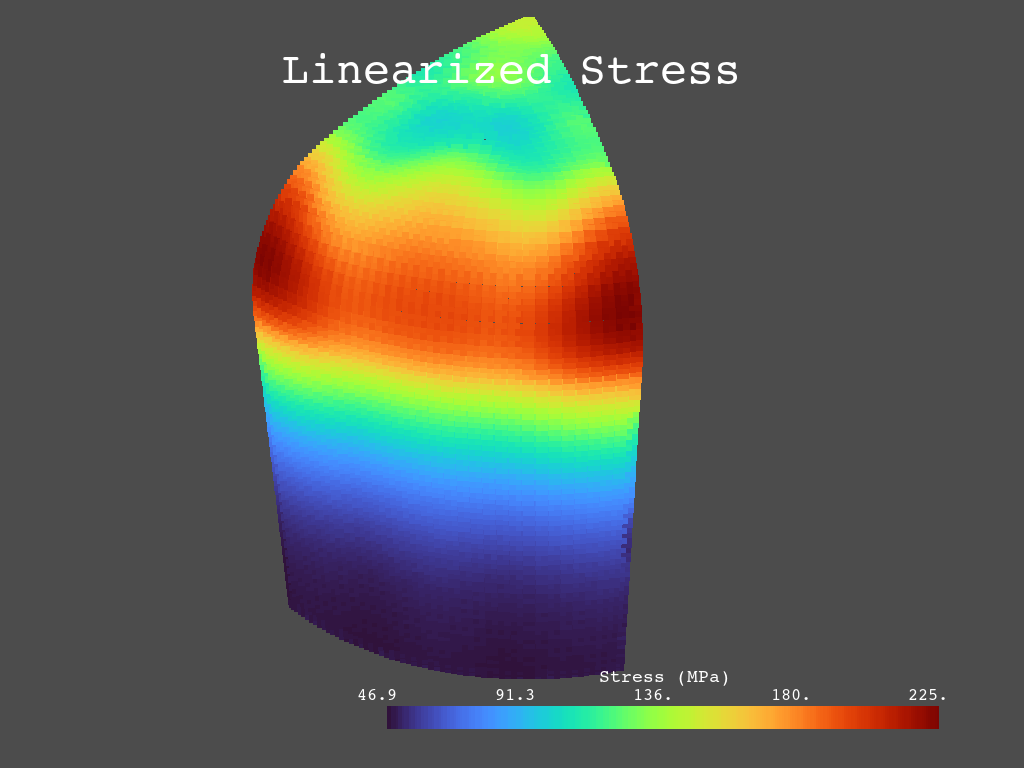

Conductivity: wl10_roedig
Structural: pure_w
Type: Elastic
Heat Loading: high


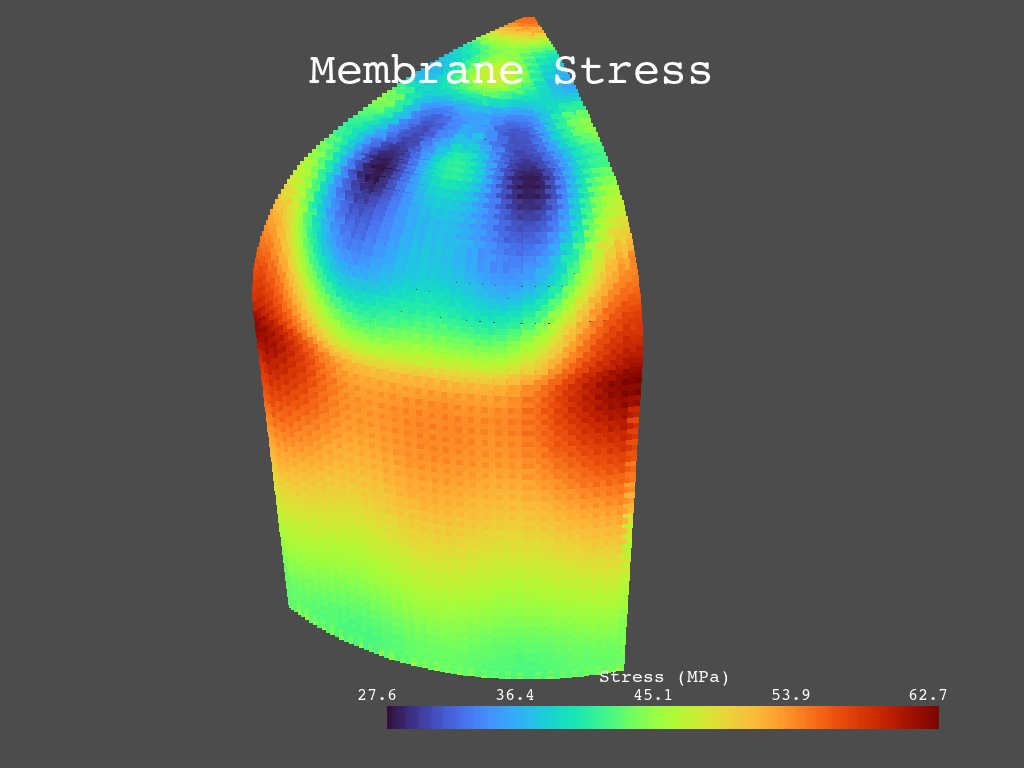

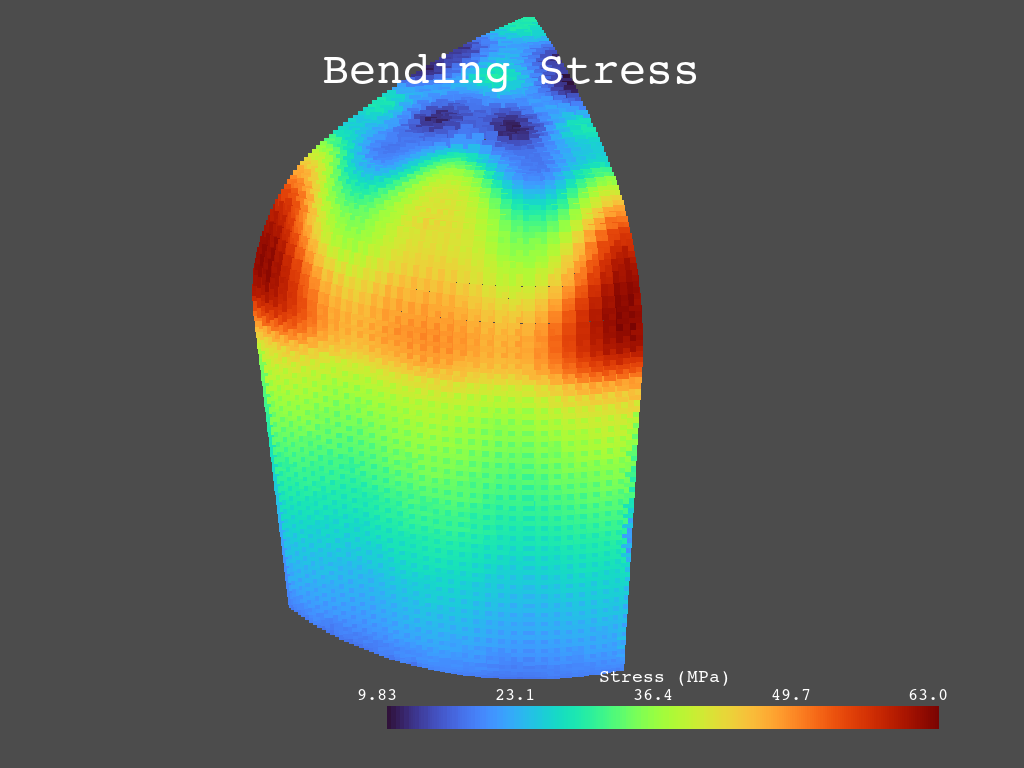

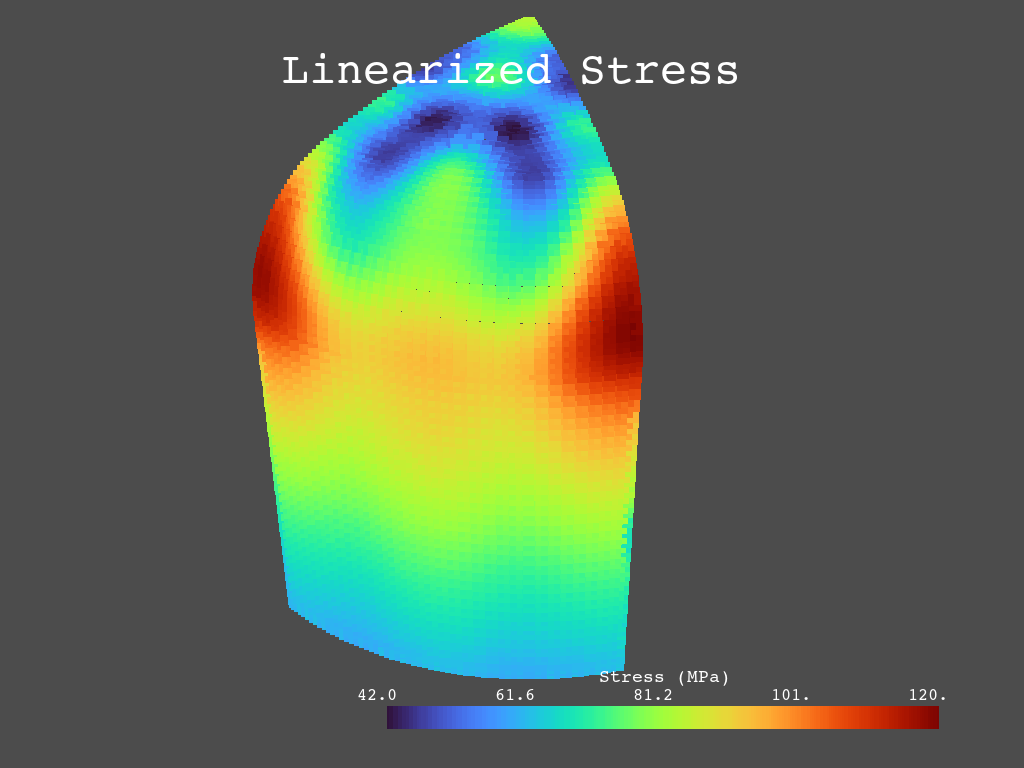

Max Membrane: [44.29875540048558, 111.2059970072831, 62.65215420541372]
Max Bending: [38.942881768261834, 116.27606553294106, 63.0288436779954]
Max Linearized: [82.67087724943141, 224.6602896387572, 120.32907748369585]
____________________________________
Conductivity: kdoped_rhenium
Structural: kdoped_rhenium
Type: Plastic
Heat Loading: low


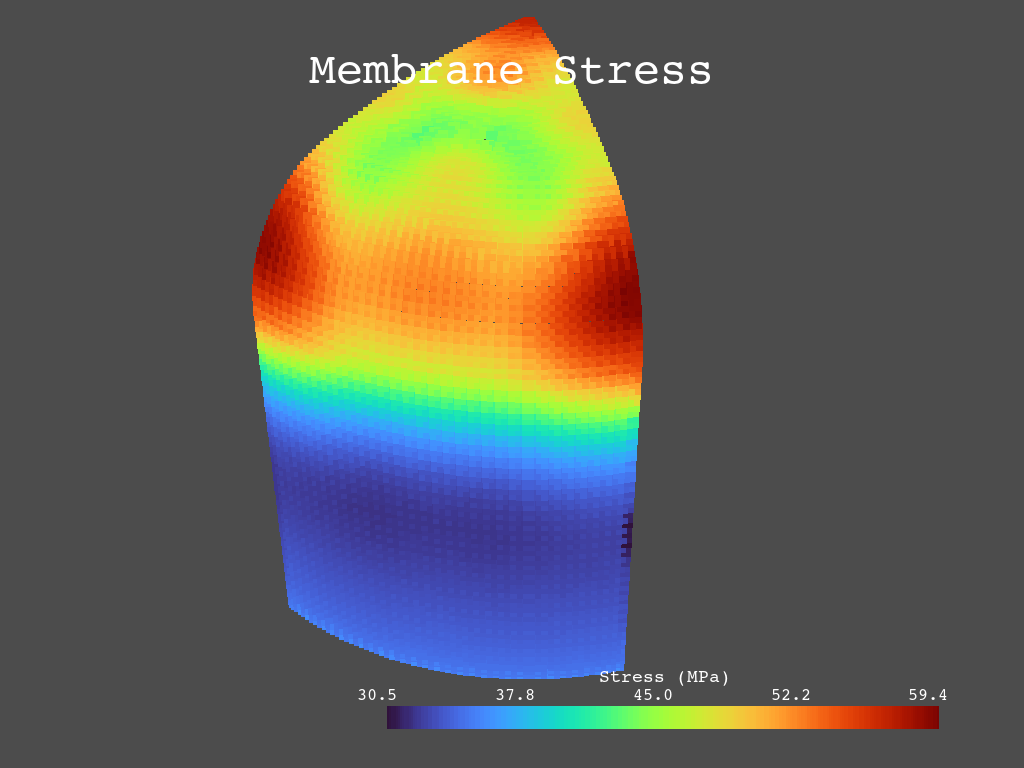

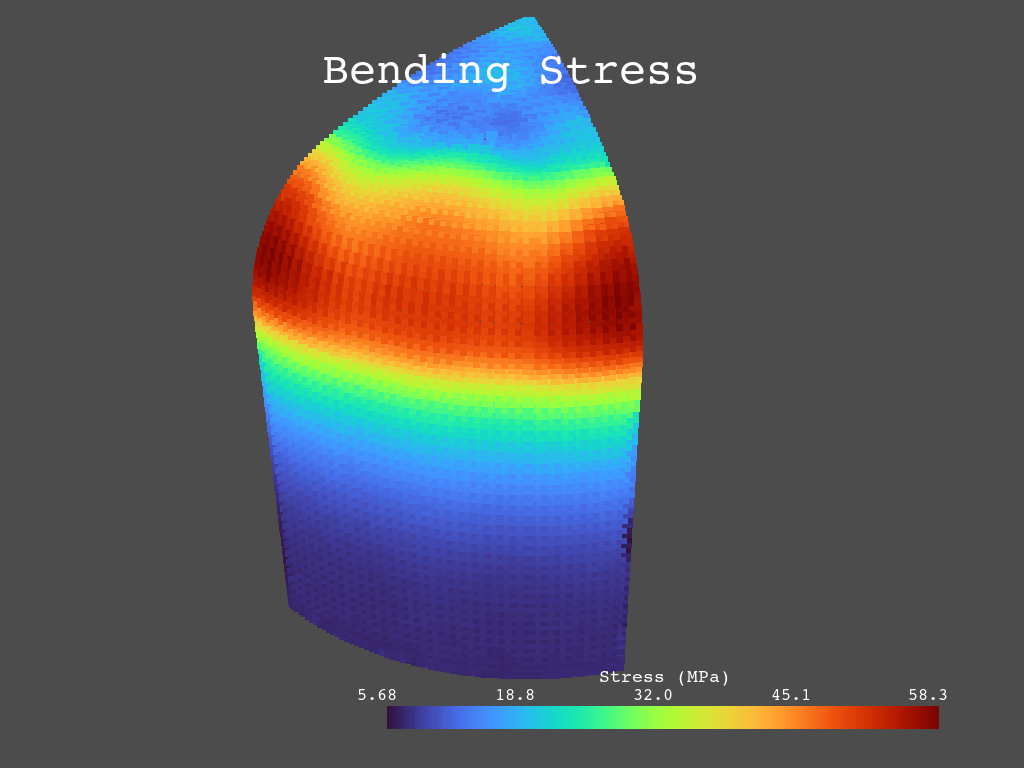

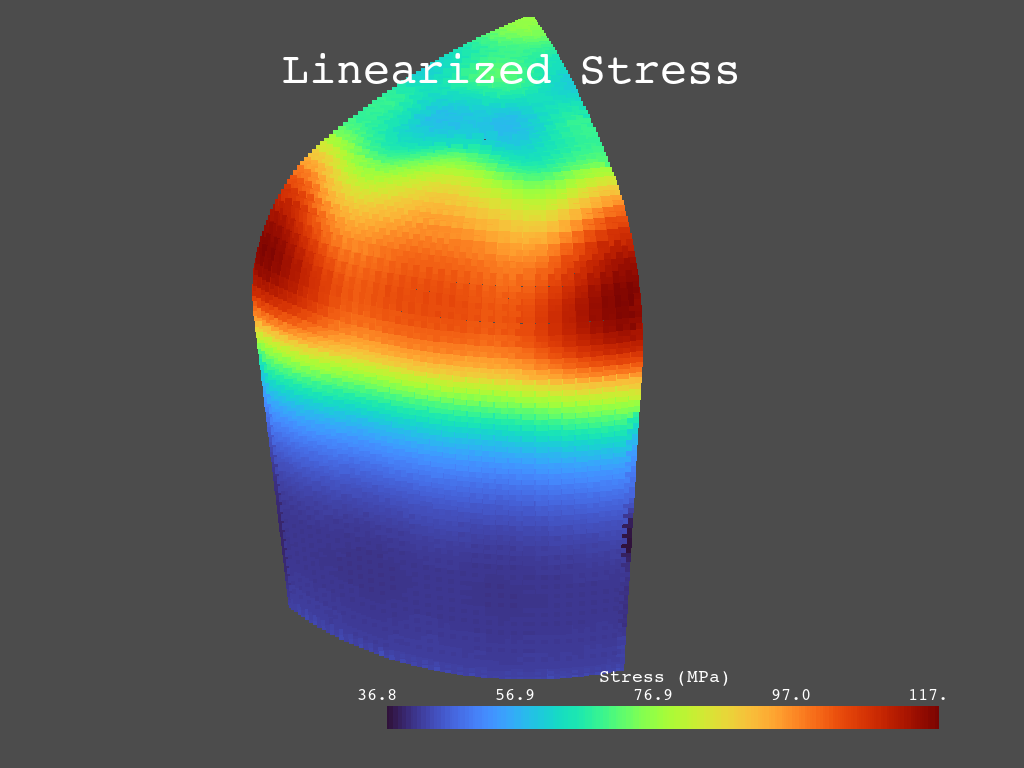

Conductivity: kdoped_rhenium
Structural: kdoped_rhenium
Type: Plastic
Heat Loading: nominal


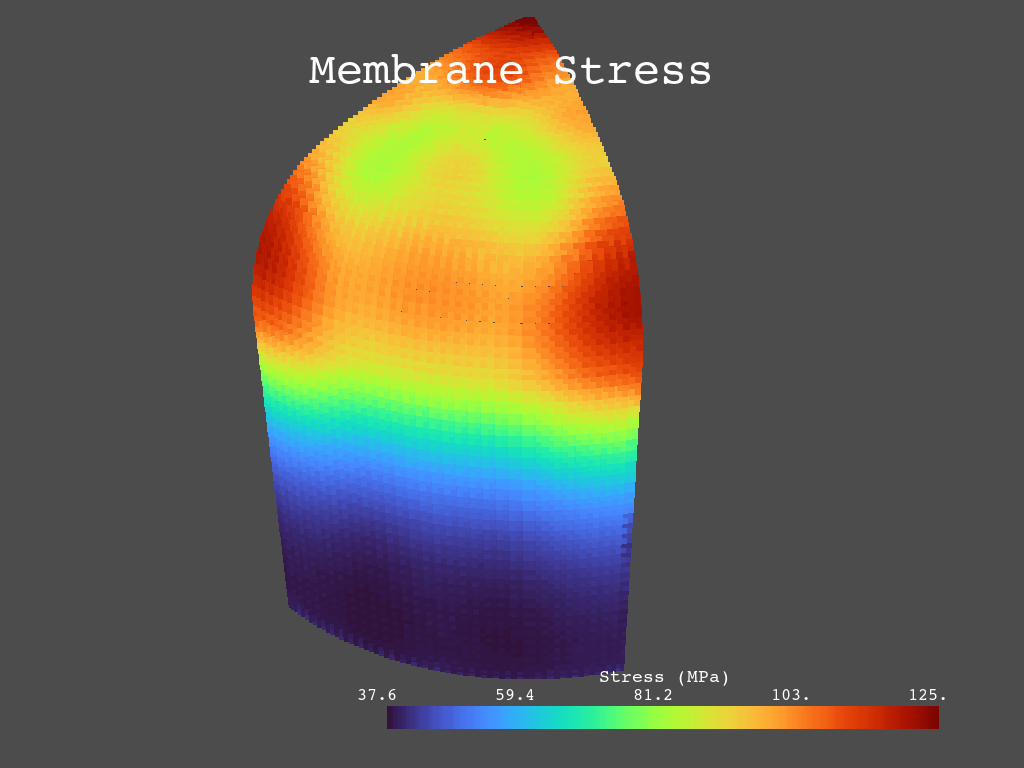

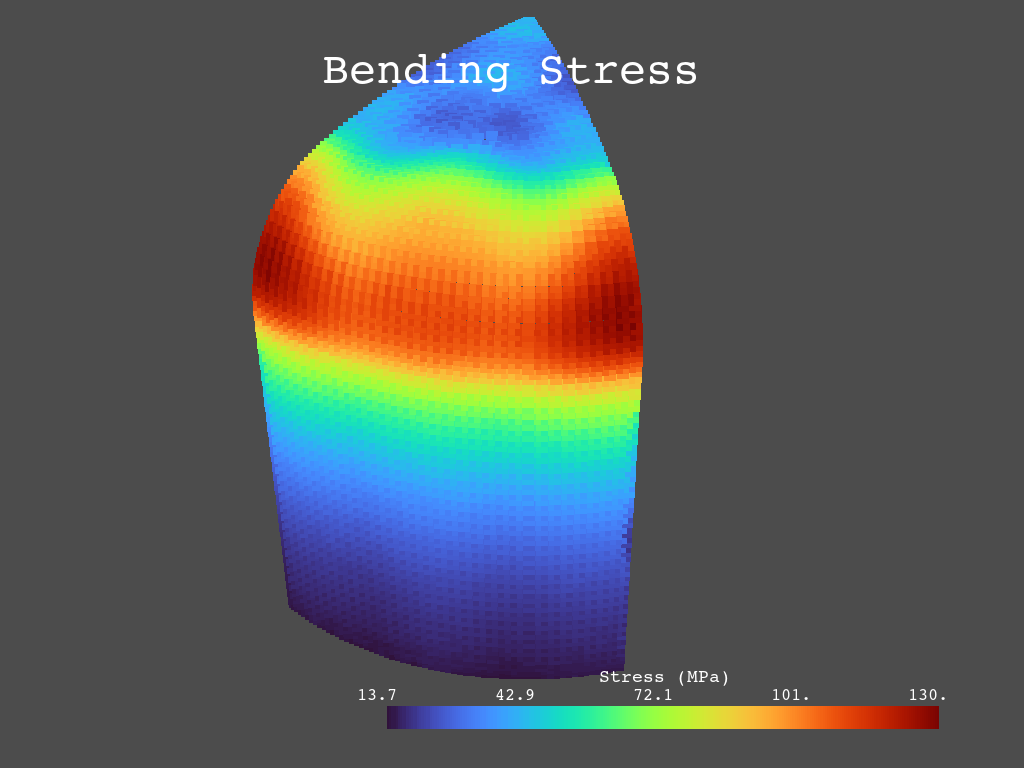

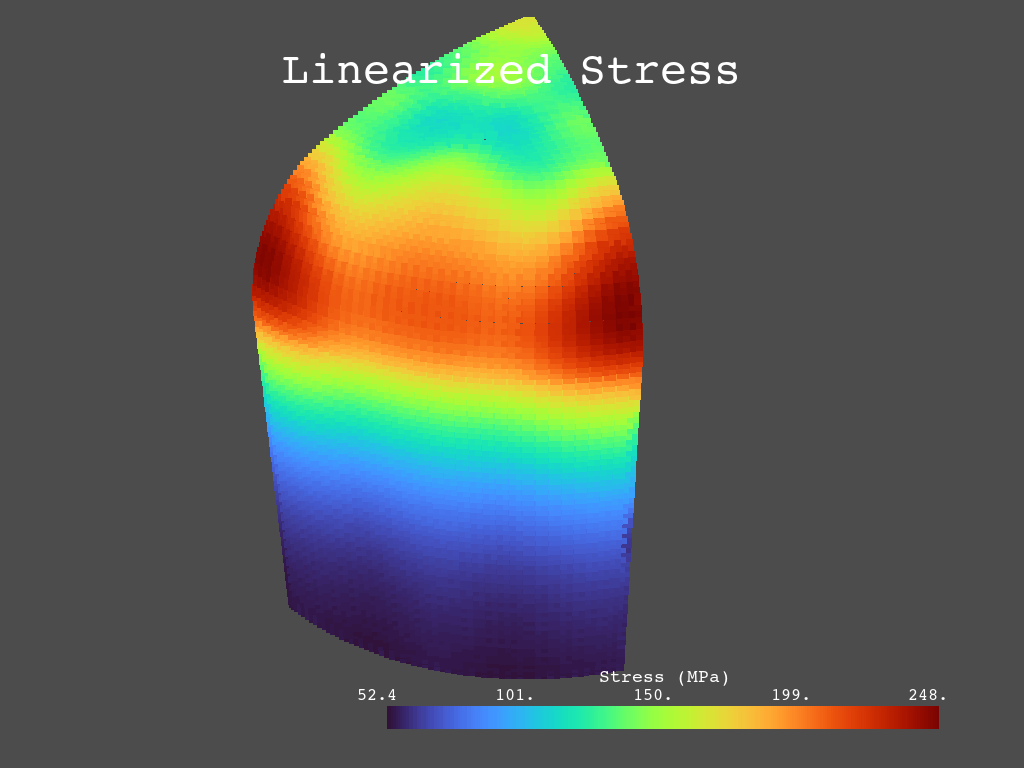

Conductivity: kdoped_rhenium
Structural: kdoped_rhenium
Type: Plastic
Heat Loading: high


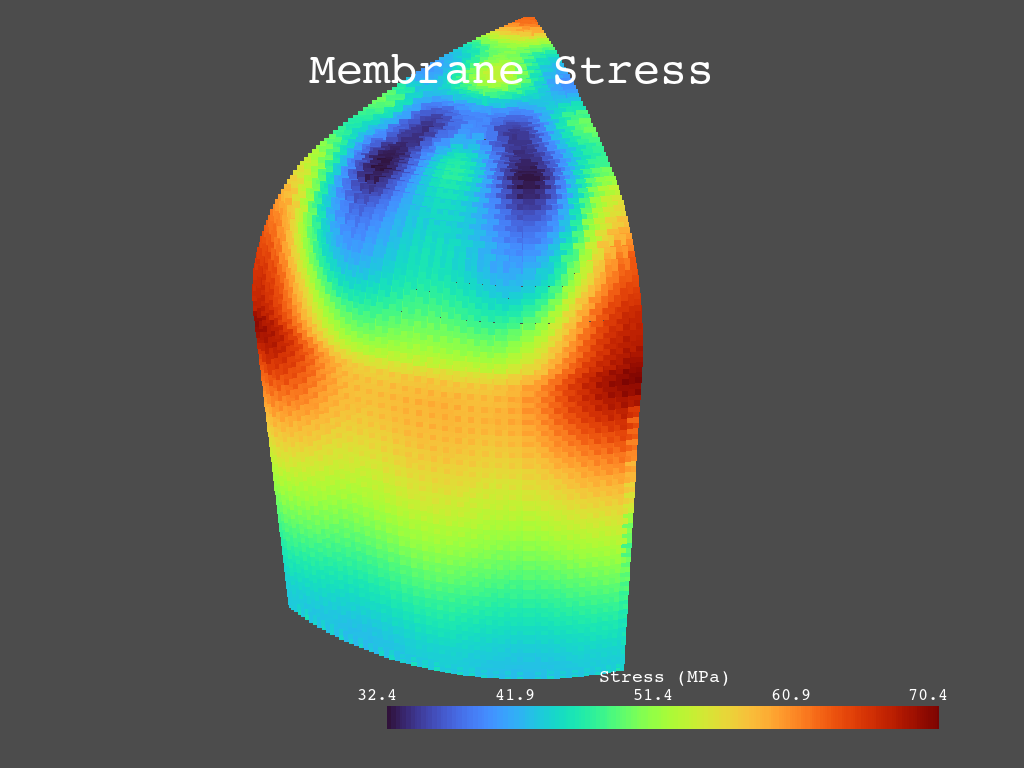

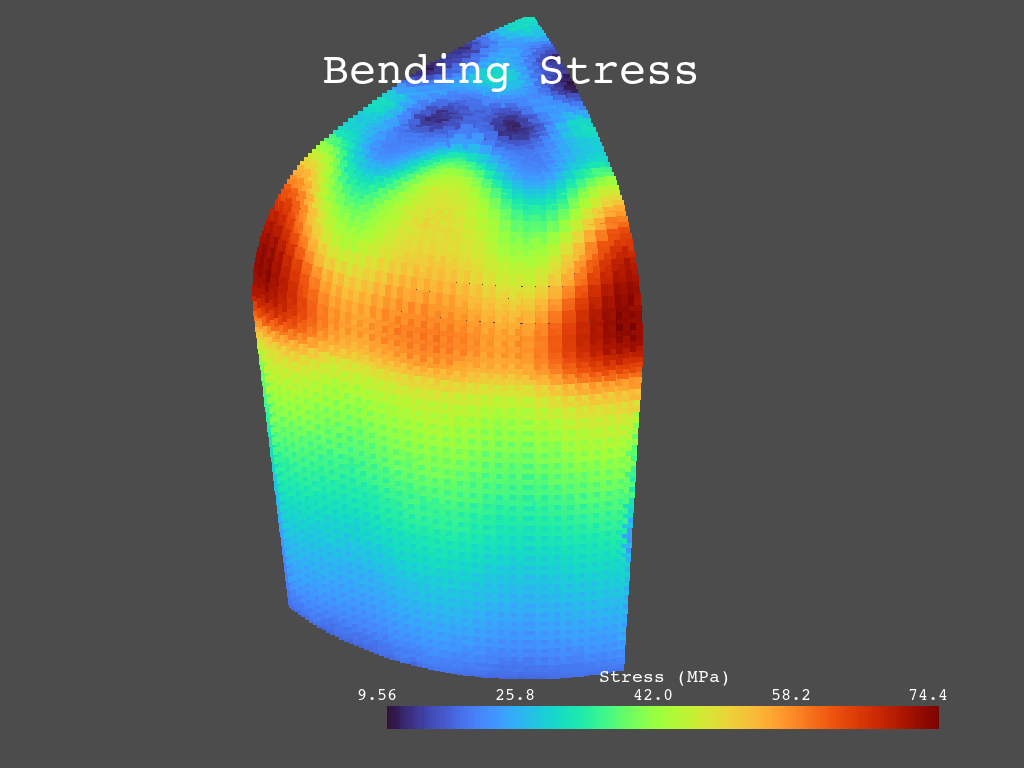

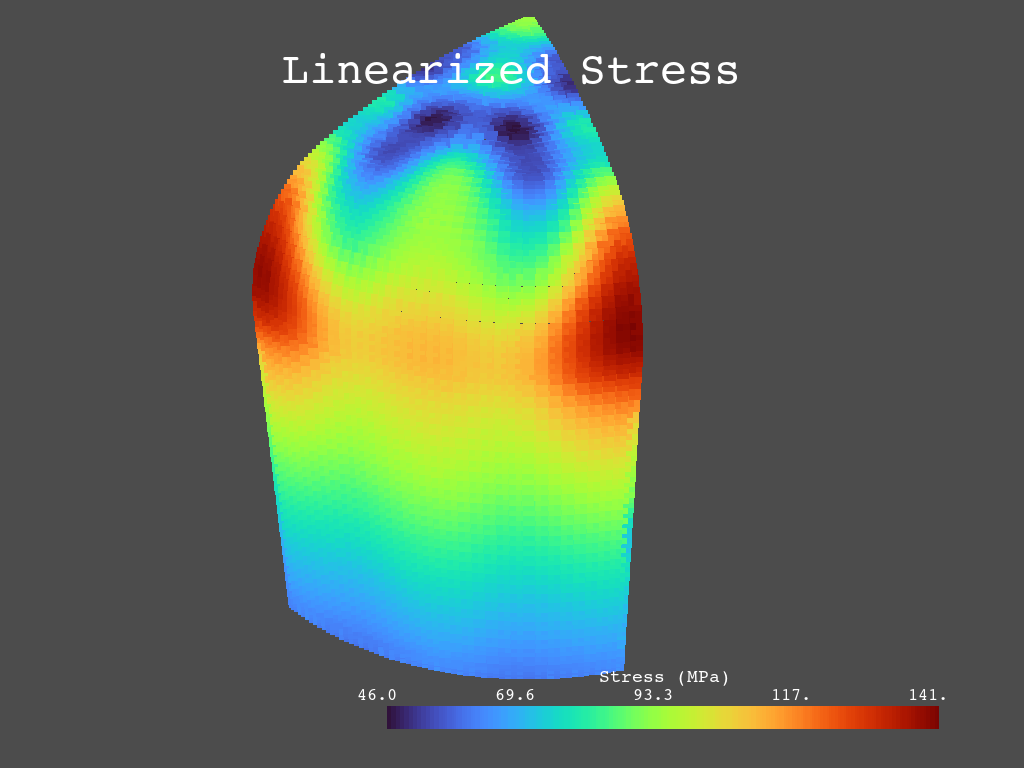

Max Membrane: [59.428137049899874, 124.6949386332984, 70.36861021925976]
Max Bending: [58.302069084272475, 130.38396611158754, 74.40405819360348]
Max Linearized: [117.05428085802276, 248.05742795843923, 140.62029057908268]
____________________________________
Conductivity: wl10_roedig
Structural: pure_w
Type: Plastic
Heat Loading: low


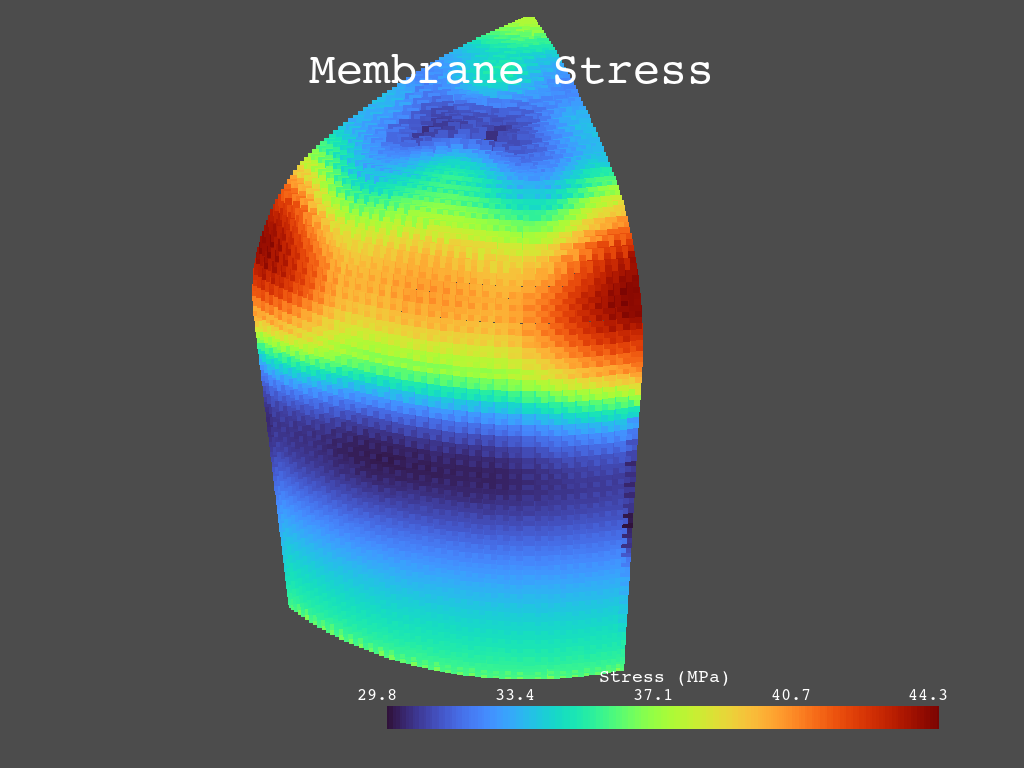

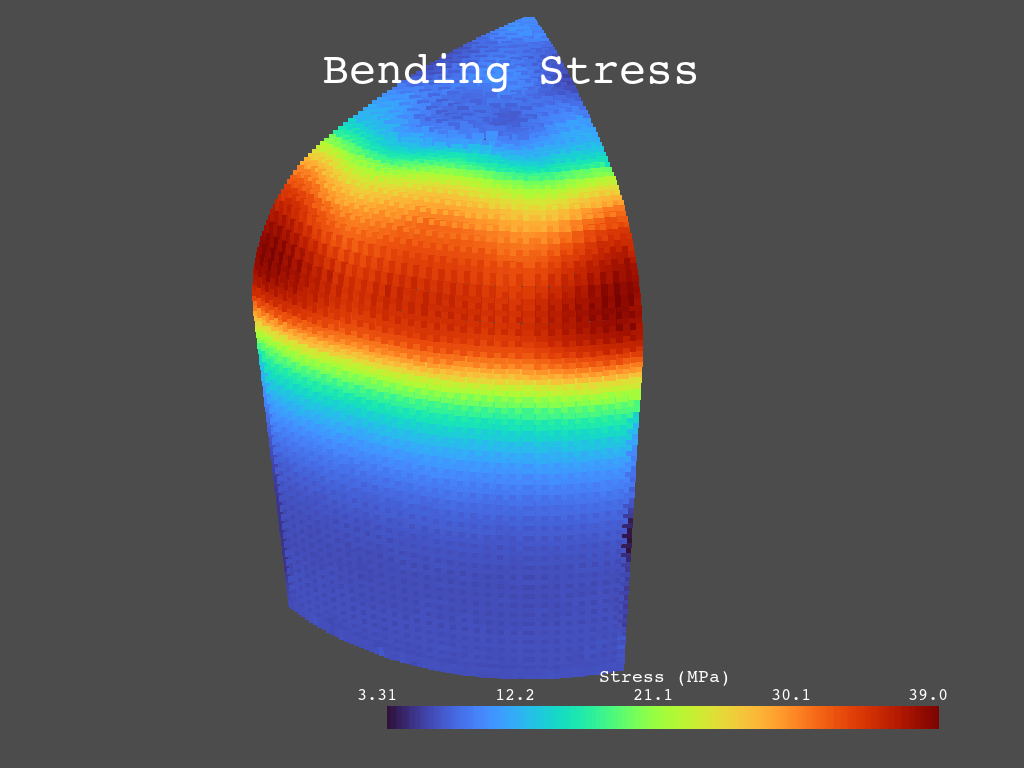

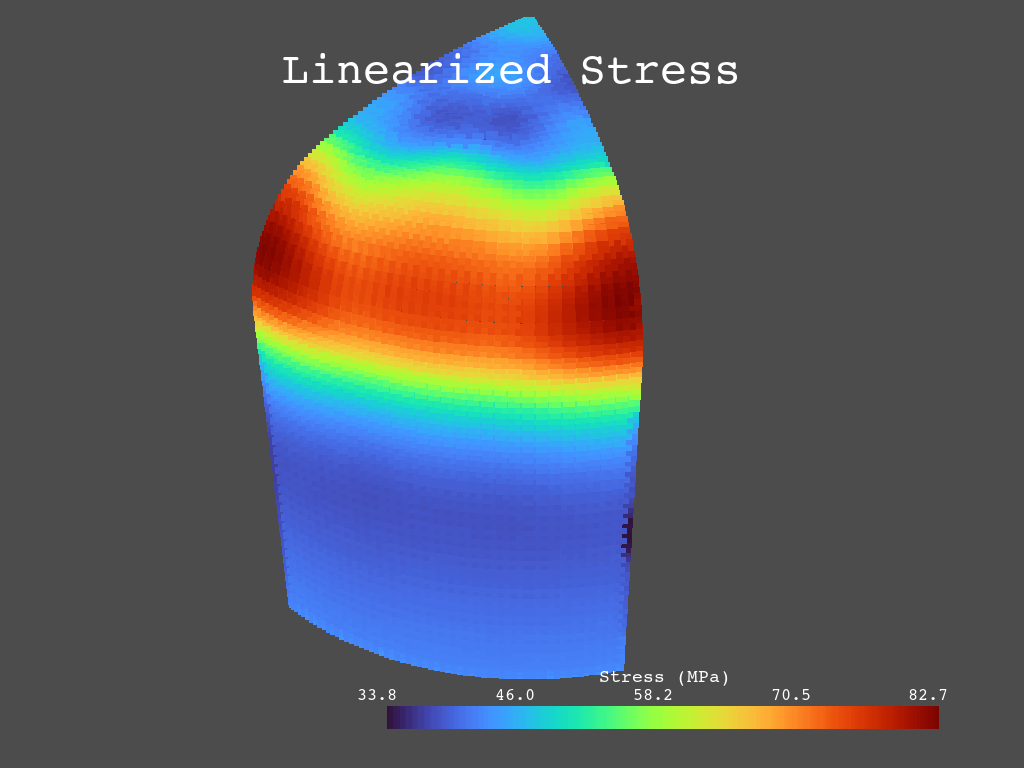

Conductivity: wl10_roedig
Structural: pure_w
Type: Plastic
Heat Loading: nominal


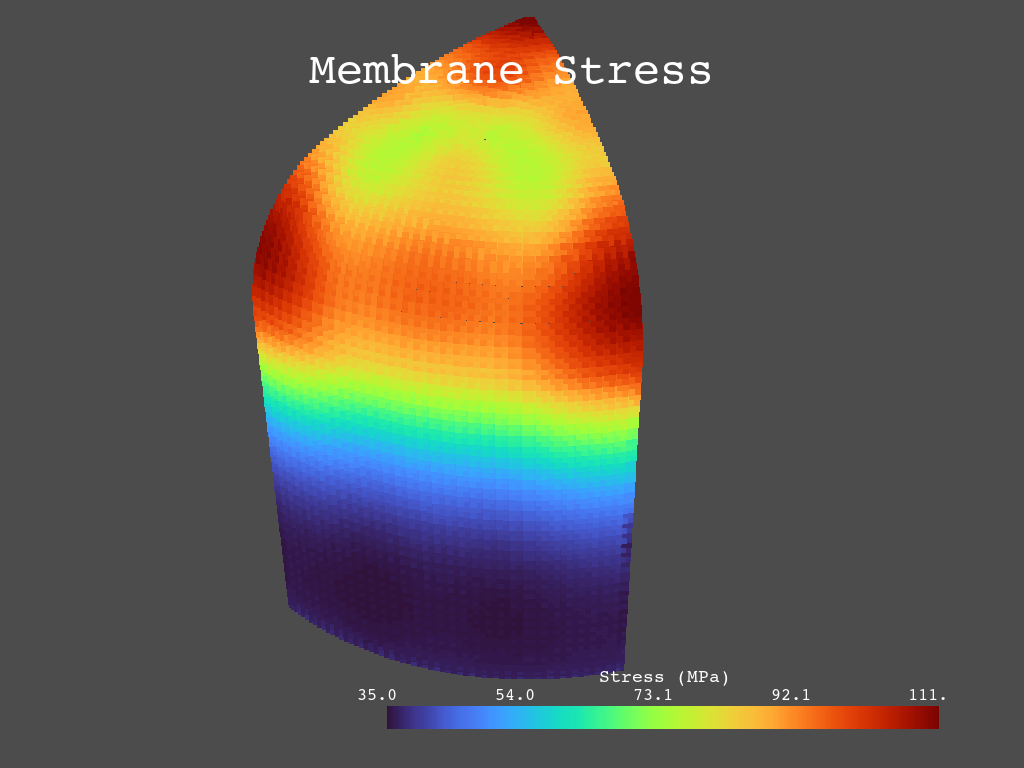

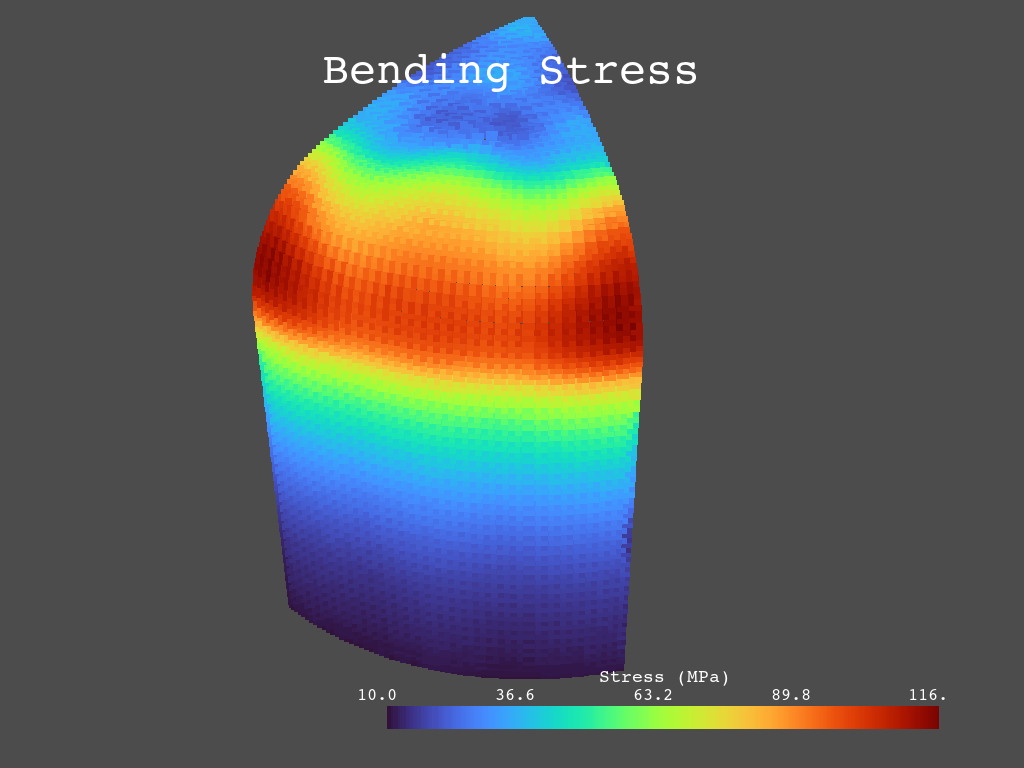

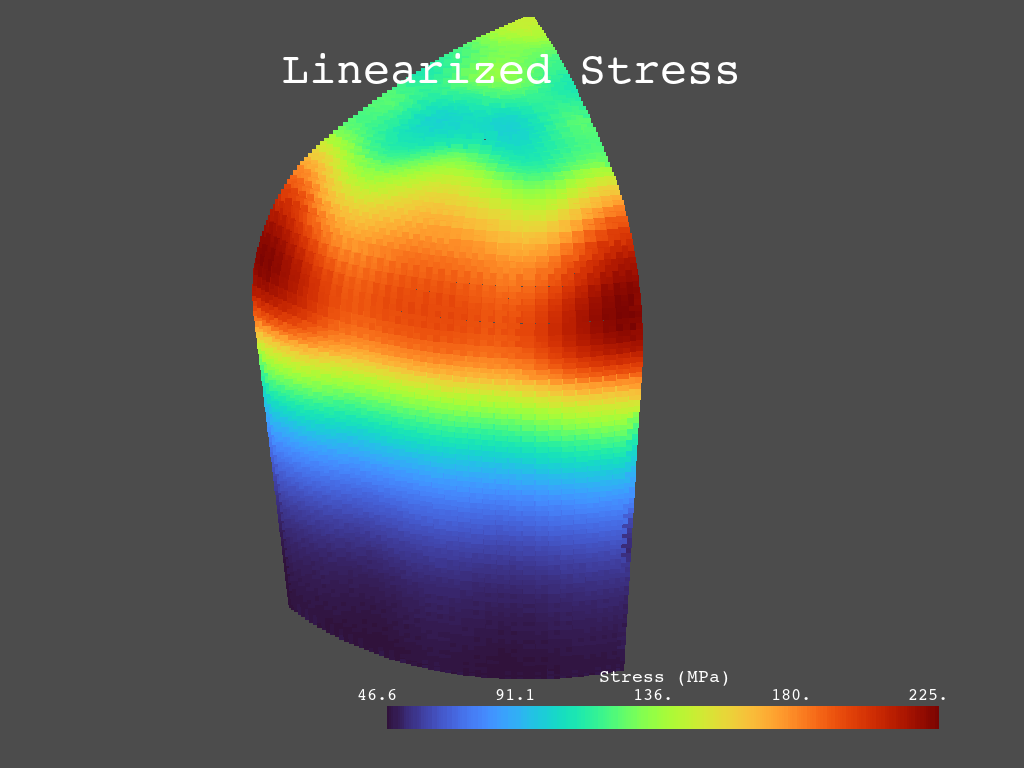

Conductivity: wl10_roedig
Structural: pure_w
Type: Plastic
Heat Loading: high


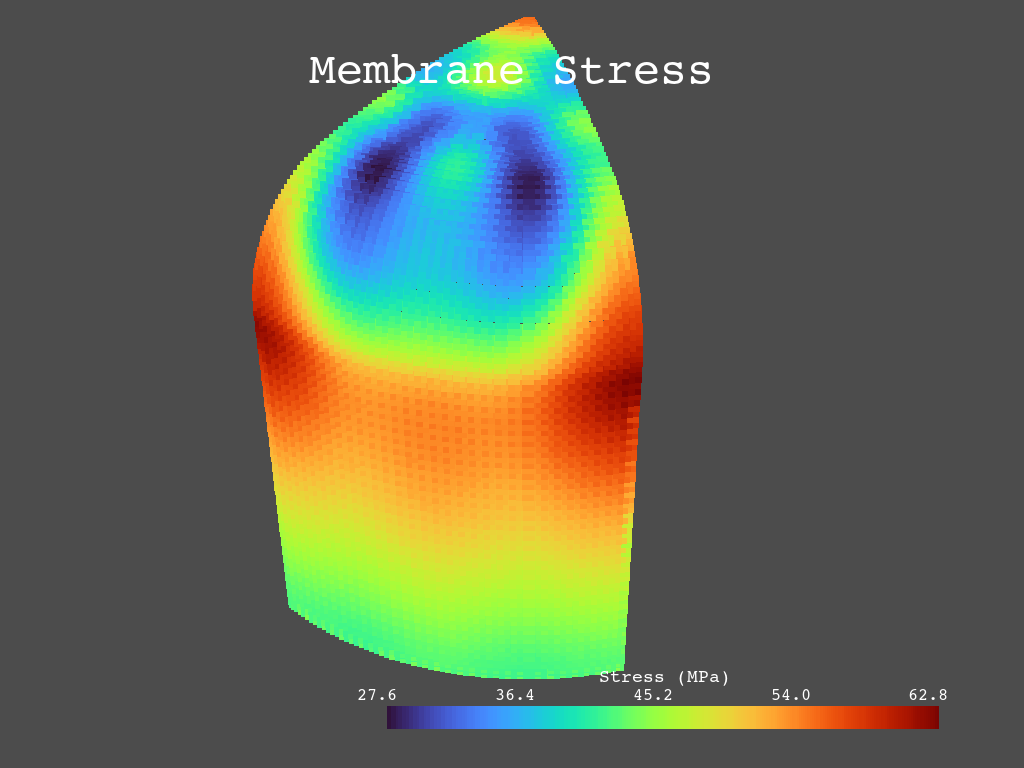

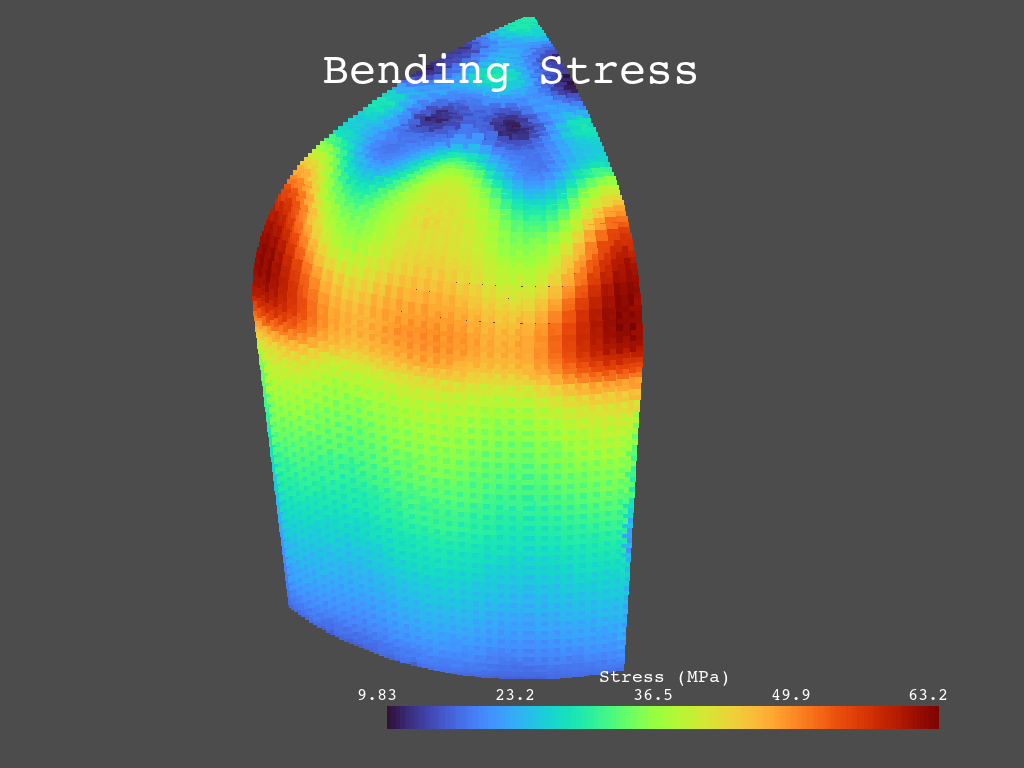

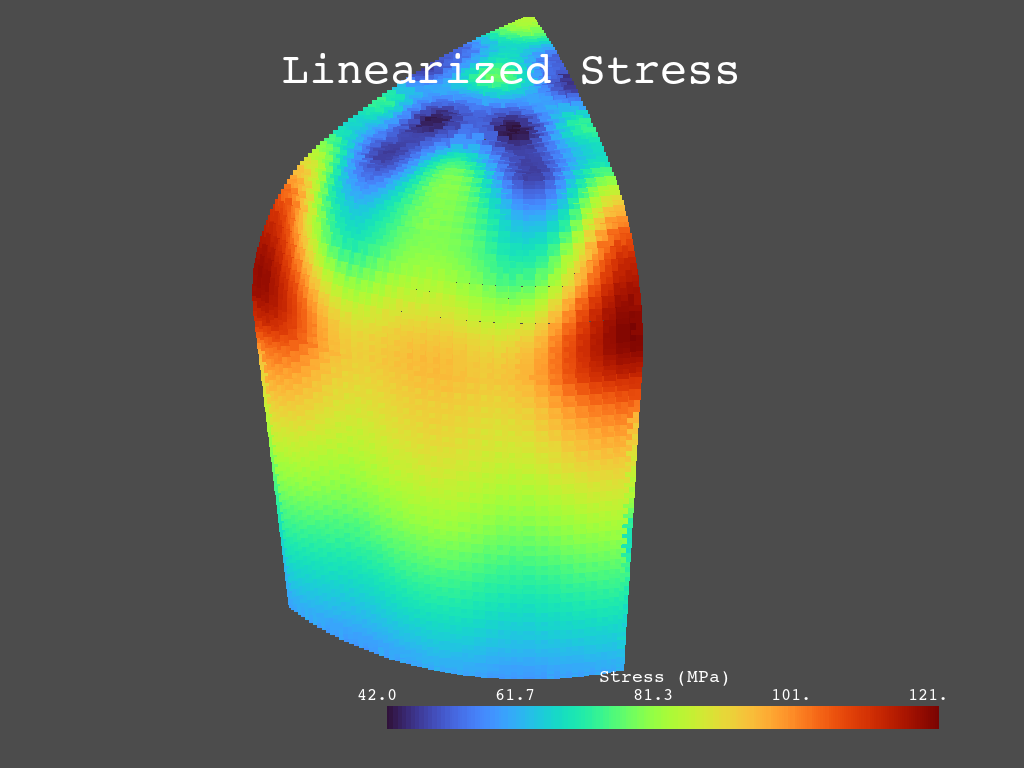

Max Membrane: [44.31186532368027, 111.20490991062435, 62.80520750247013]
Max Bending: [38.9671603836942, 116.33680906655206, 63.19236361910957]
Max Linearized: [82.70414660316328, 224.74777404171294, 120.59603114189267]
____________________________________


In [8]:
stress_membrane, stress_bending, stress_linearized = plot_linearization(True)

Conductivity: kdoped_rhenium
Structural: kdoped_rhenium
Type: Elastic
Heat Loading: low


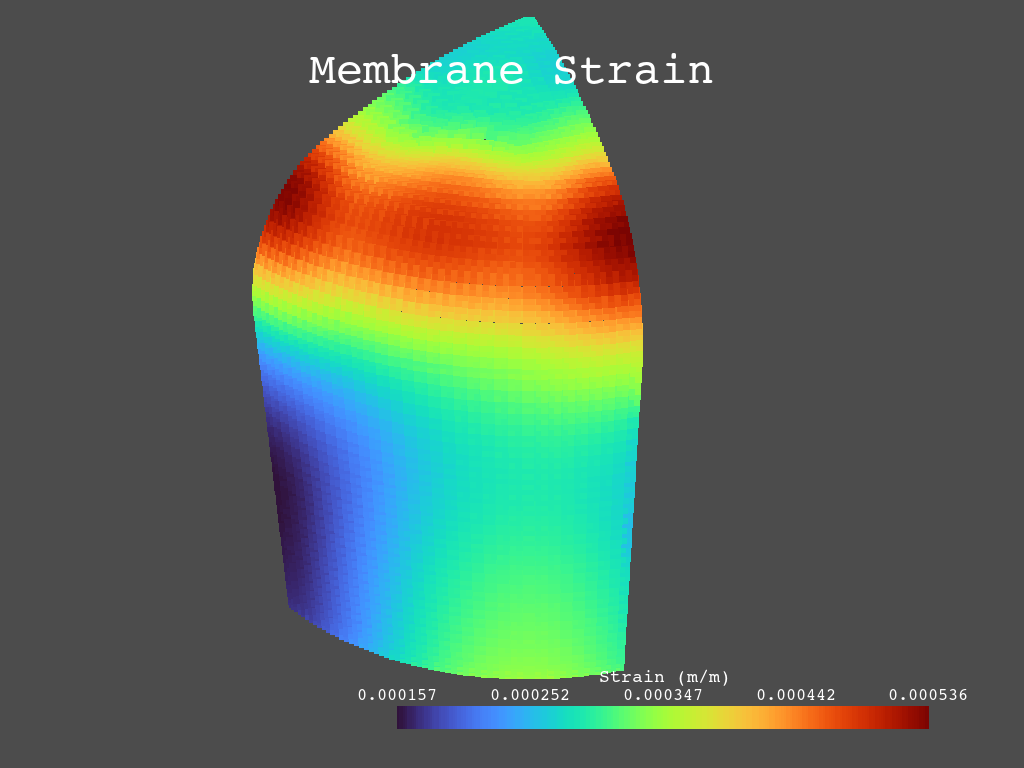

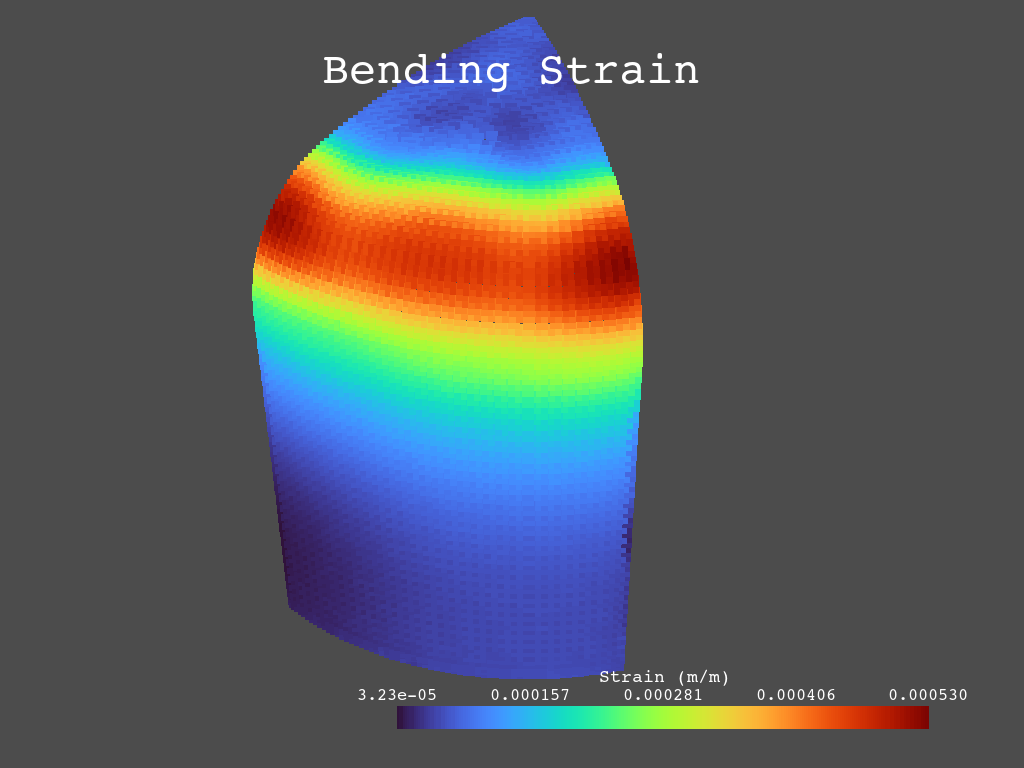

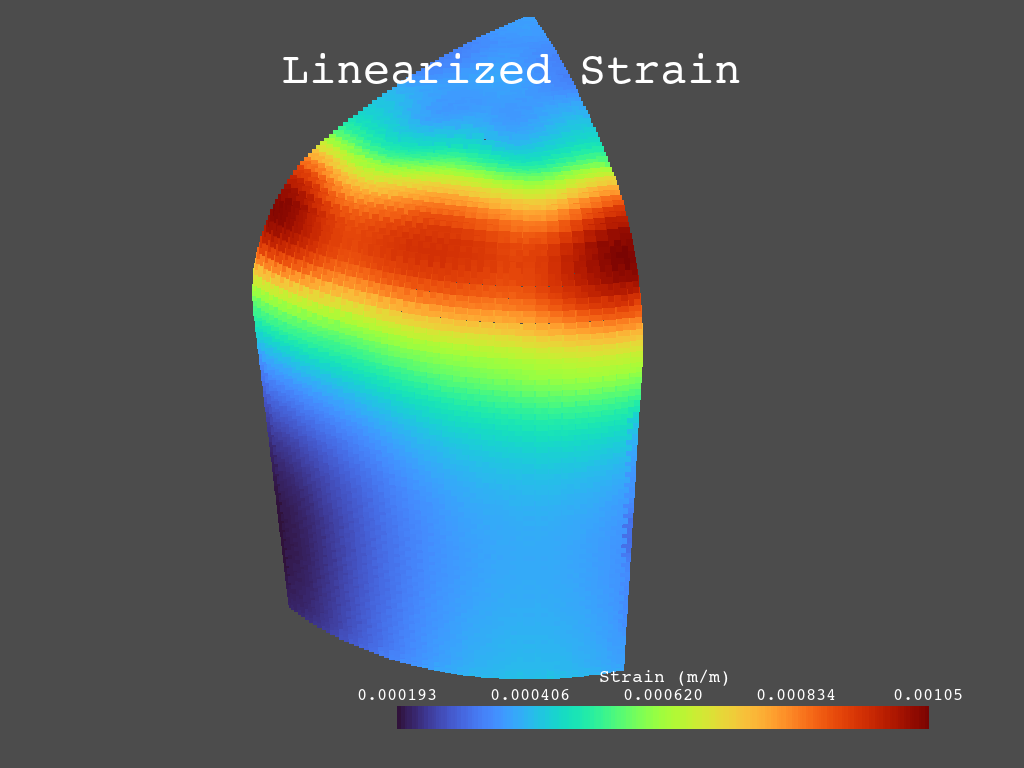

Conductivity: kdoped_rhenium
Structural: kdoped_rhenium
Type: Elastic
Heat Loading: nominal


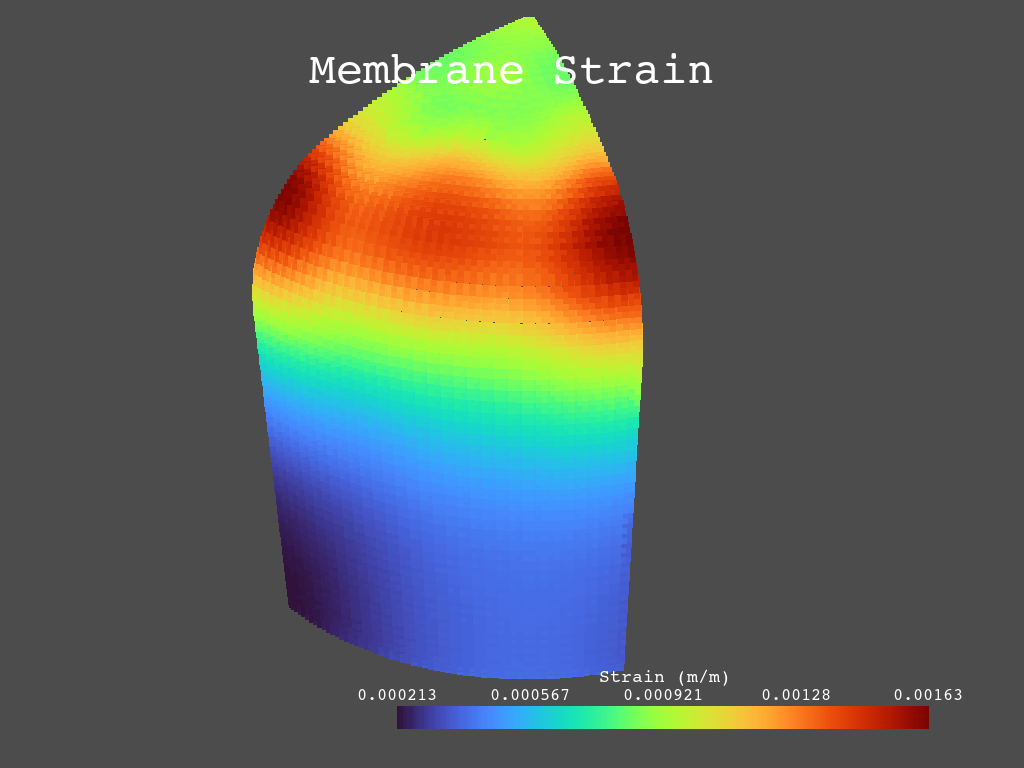

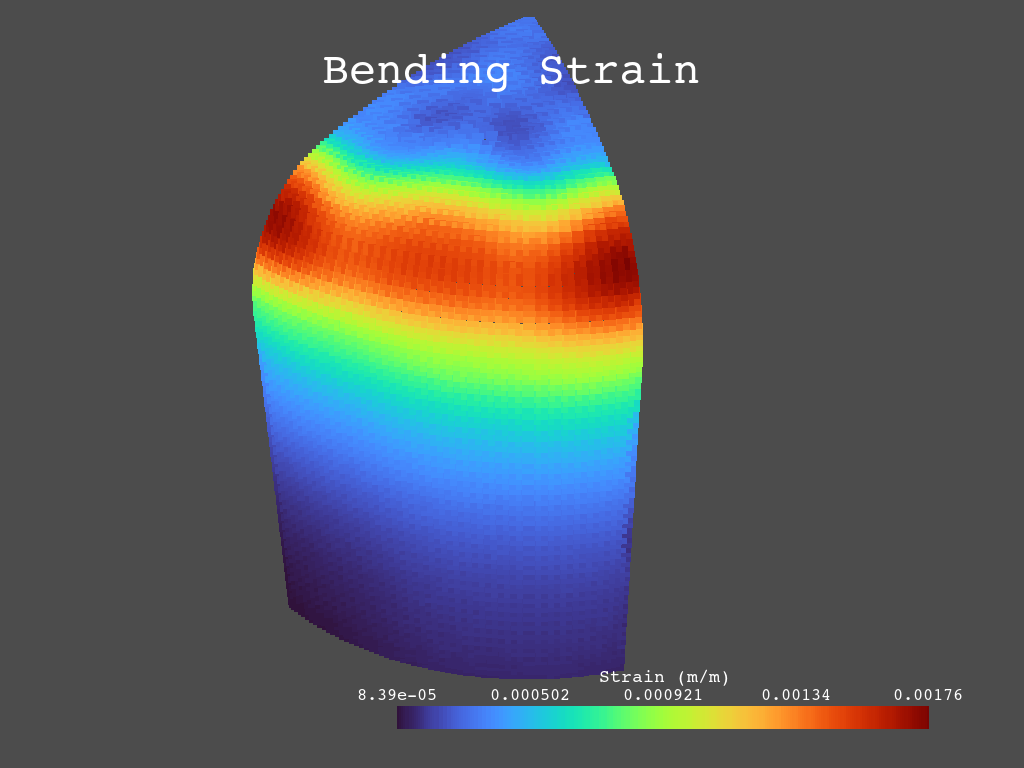

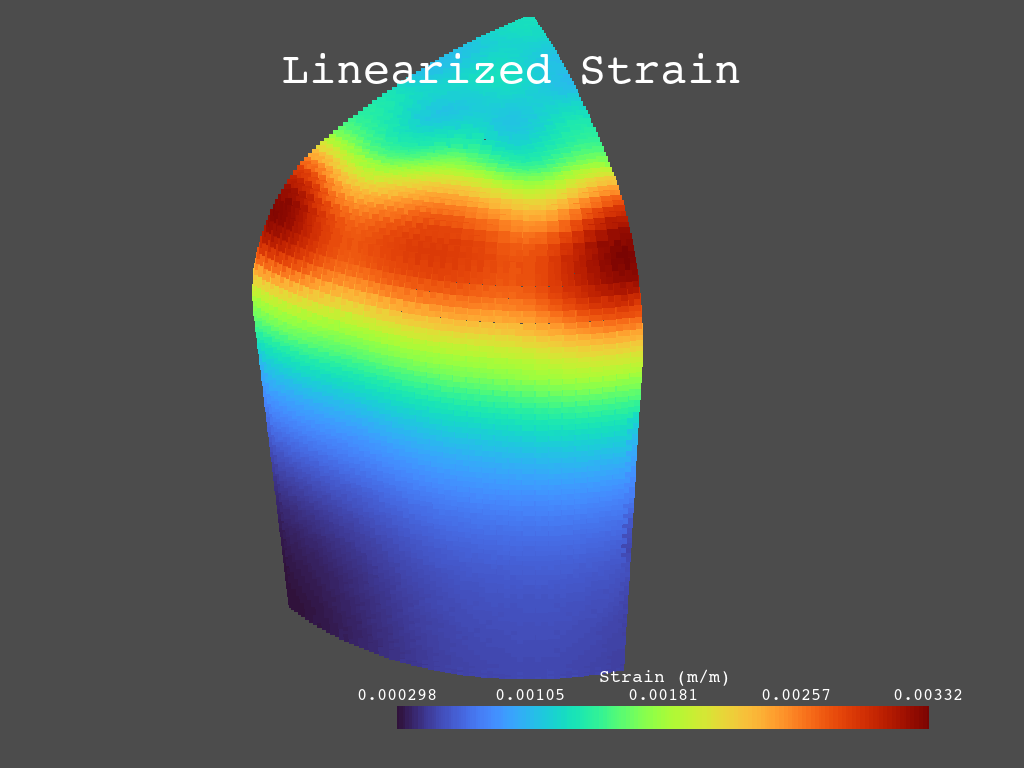

Conductivity: kdoped_rhenium
Structural: kdoped_rhenium
Type: Elastic
Heat Loading: high


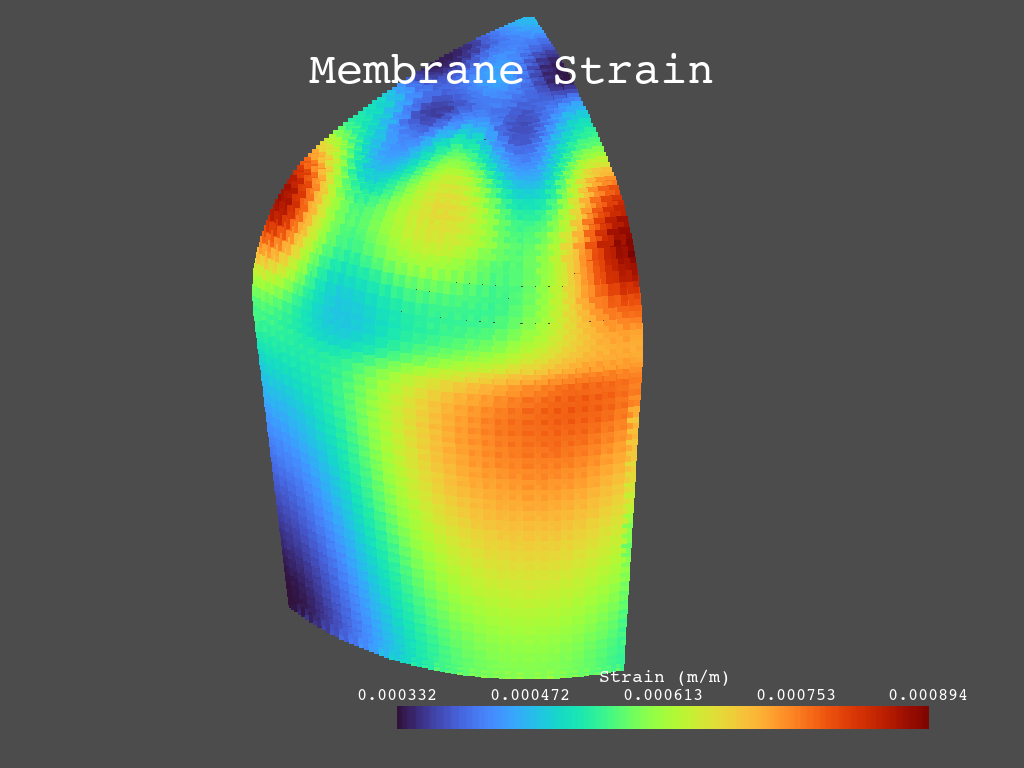

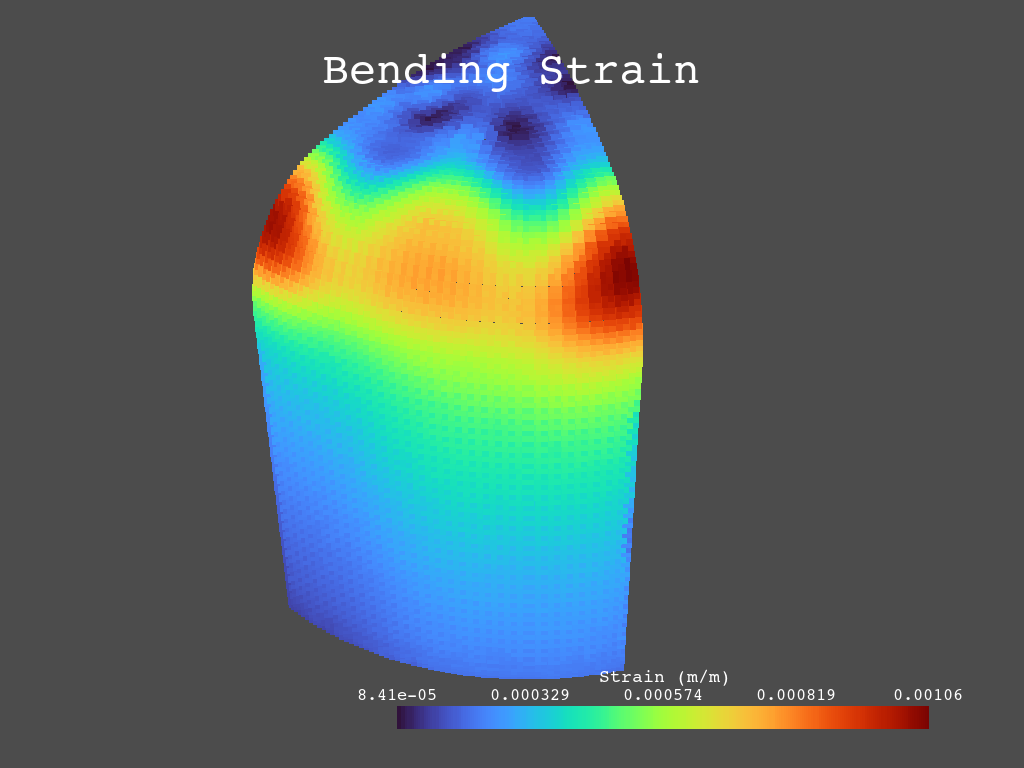

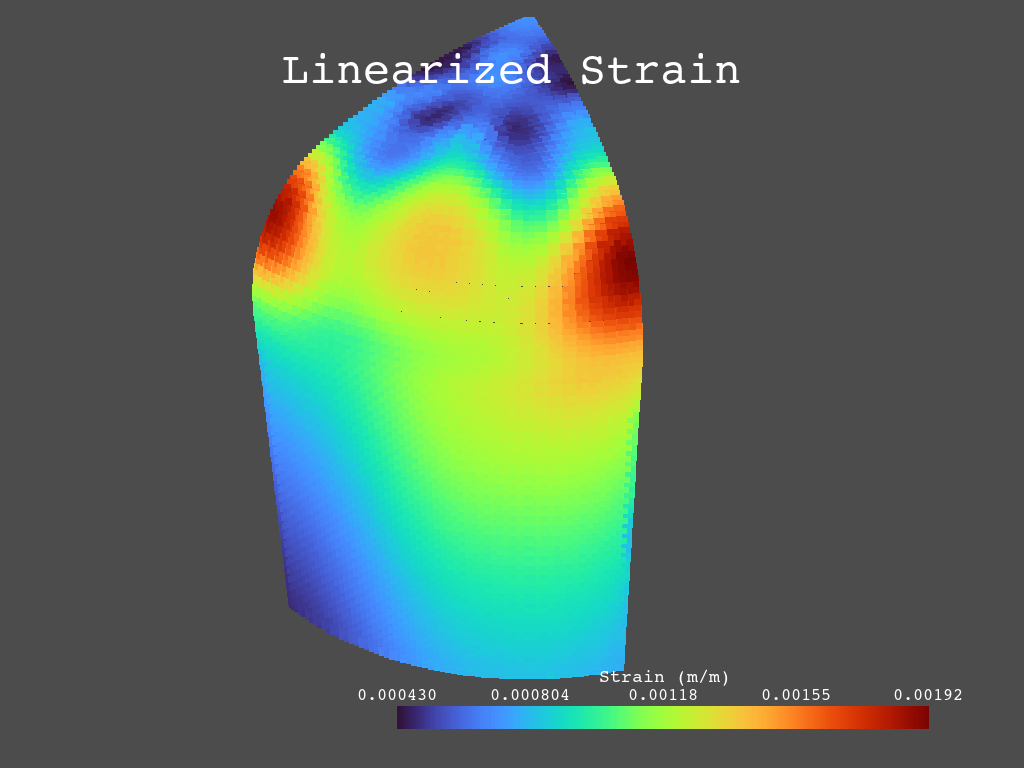

Max Membrane: [0.0005364351790764256, 0.0016299204793970396, 0.0008937911187616969]
Max Bending: [0.0005299990162535049, 0.0017575248475111766, 0.0010641035289237336]
Max Linearized: [0.0010471418197960359, 0.0033224955176581446, 0.0019229838285888313]
____________________________________
Conductivity: wl10_roedig
Structural: wl10_roedig
Type: Elastic
Heat Loading: low


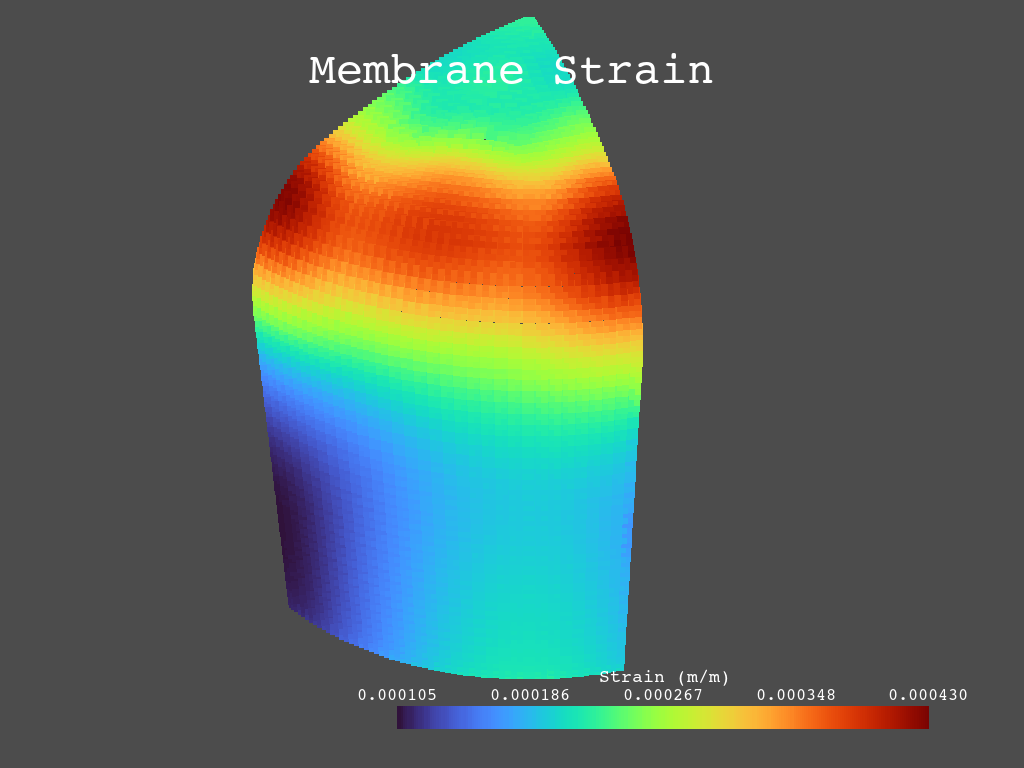

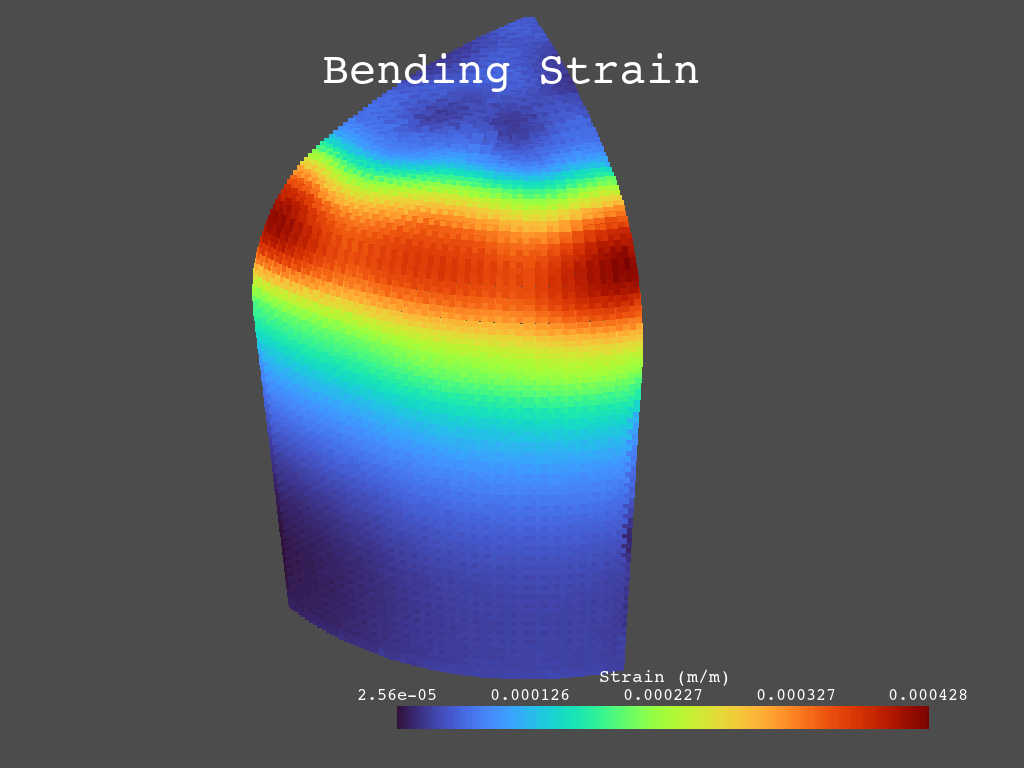

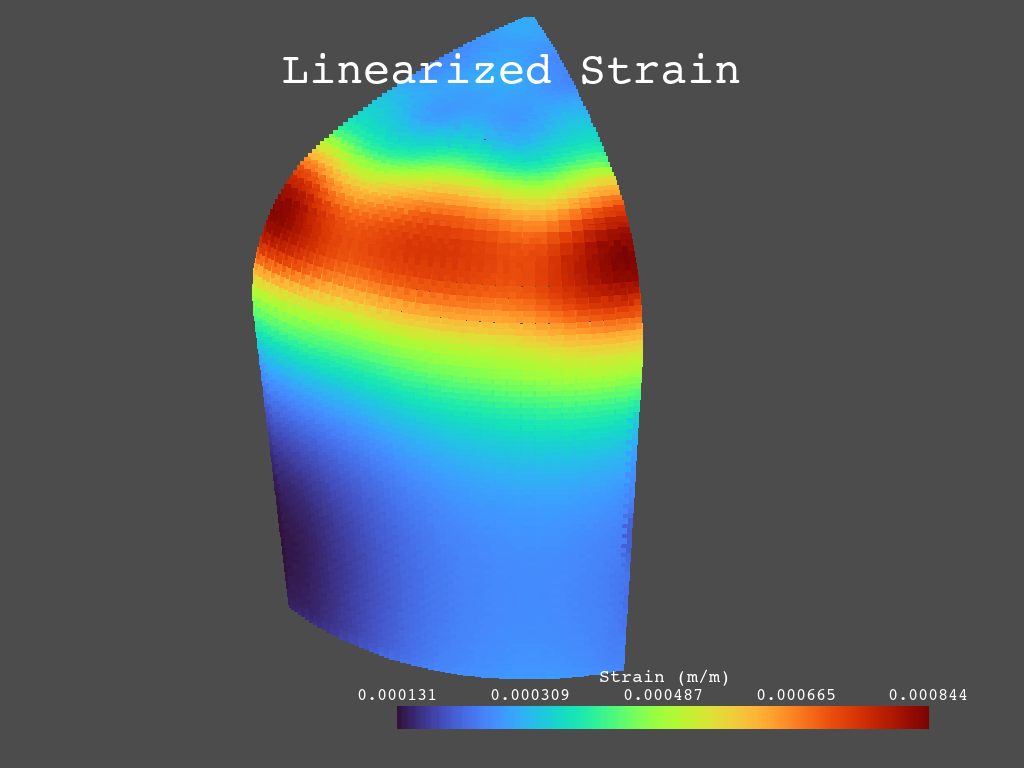

Conductivity: wl10_roedig
Structural: wl10_roedig
Type: Elastic
Heat Loading: nominal


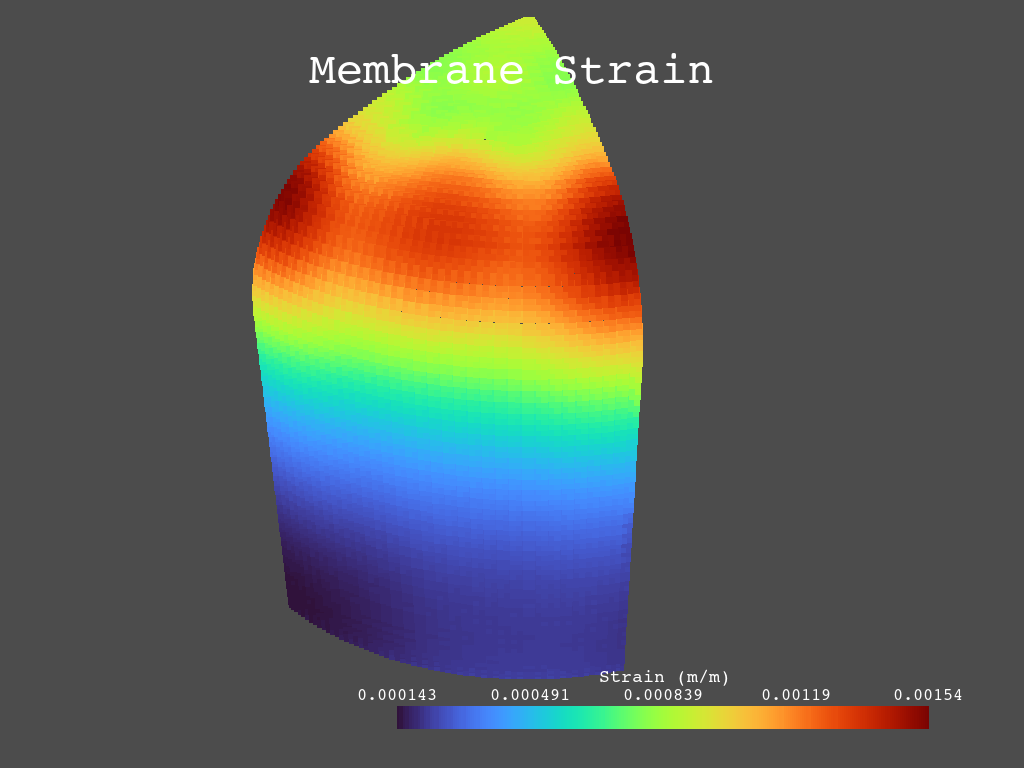

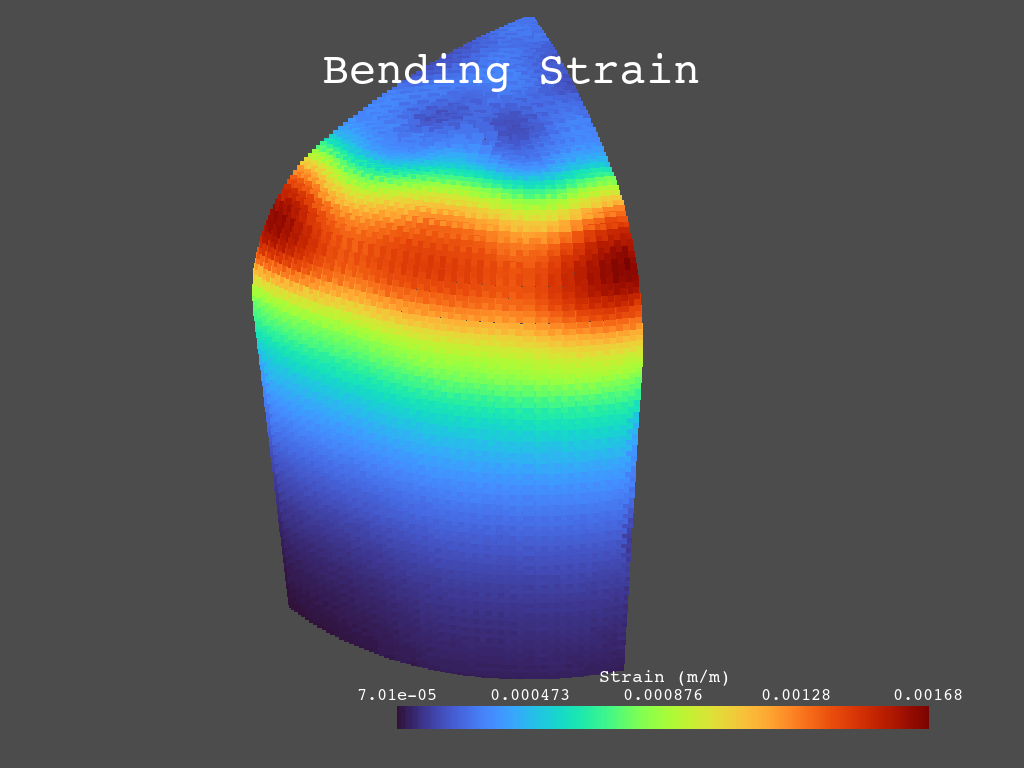

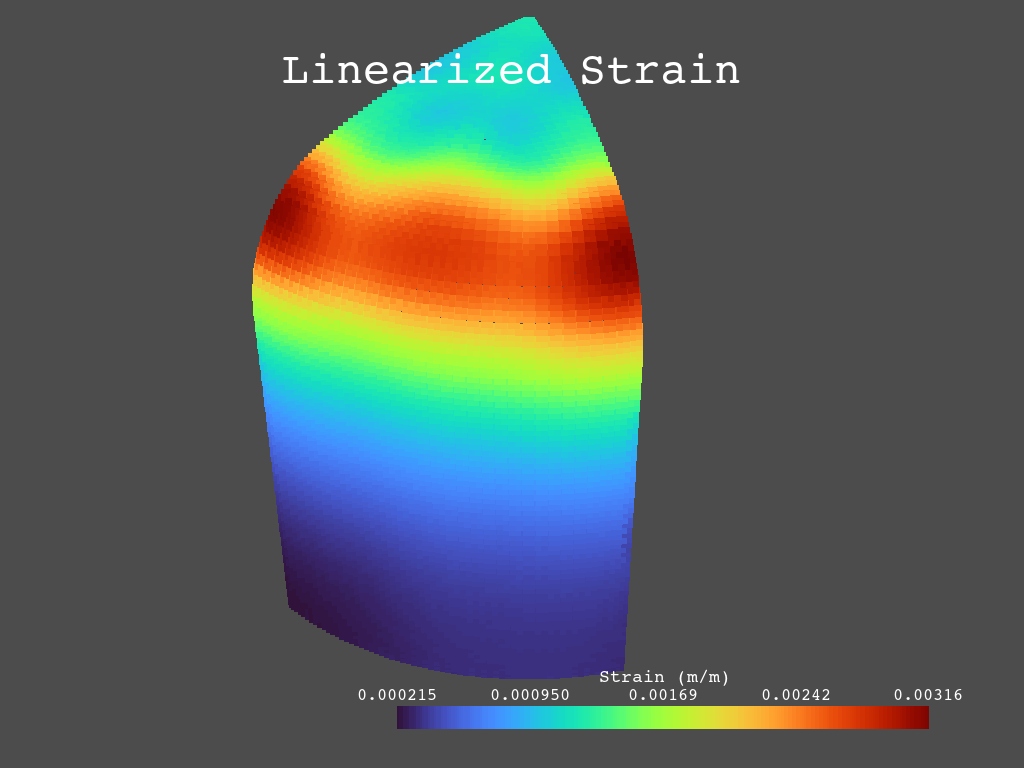

Conductivity: wl10_roedig
Structural: wl10_roedig
Type: Elastic
Heat Loading: high


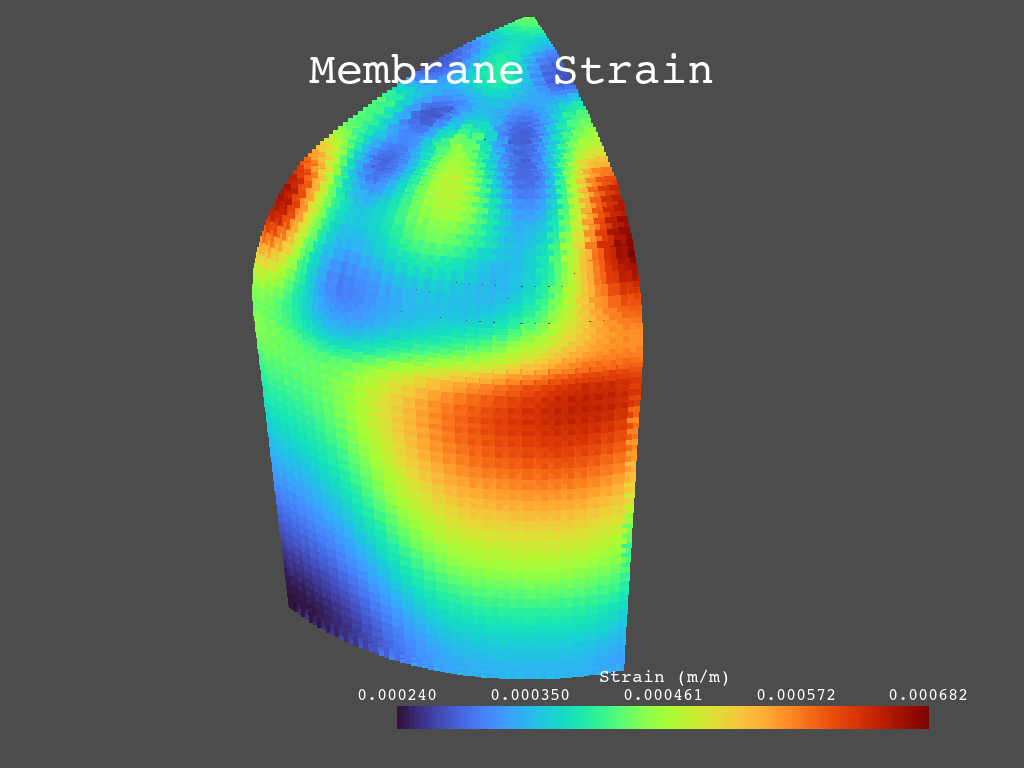

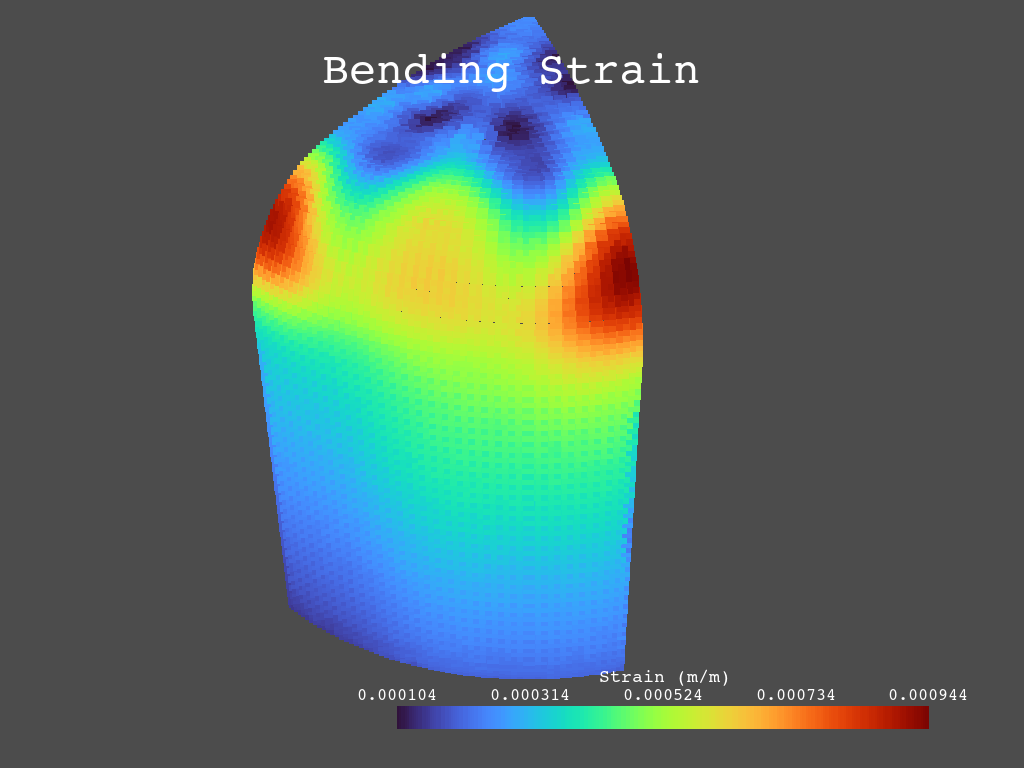

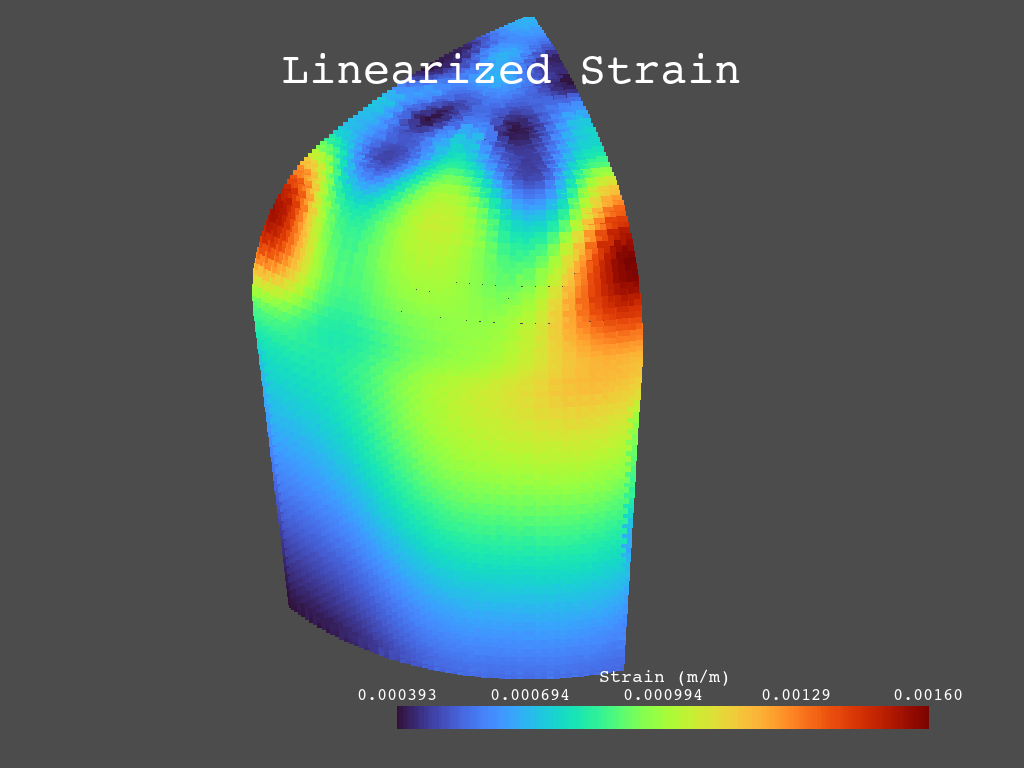

Max Membrane: [0.0004296879917948644, 0.0015358631964198836, 0.0006823371651529005]
Max Bending: [0.00042791836342292164, 0.001681323323629254, 0.0009439878025193942]
Max Linearized: [0.0008435794301885184, 0.003157020984655536, 0.0015955695917958656]
____________________________________
Conductivity: wl10_roedig
Structural: pure_w
Type: Elastic
Heat Loading: low


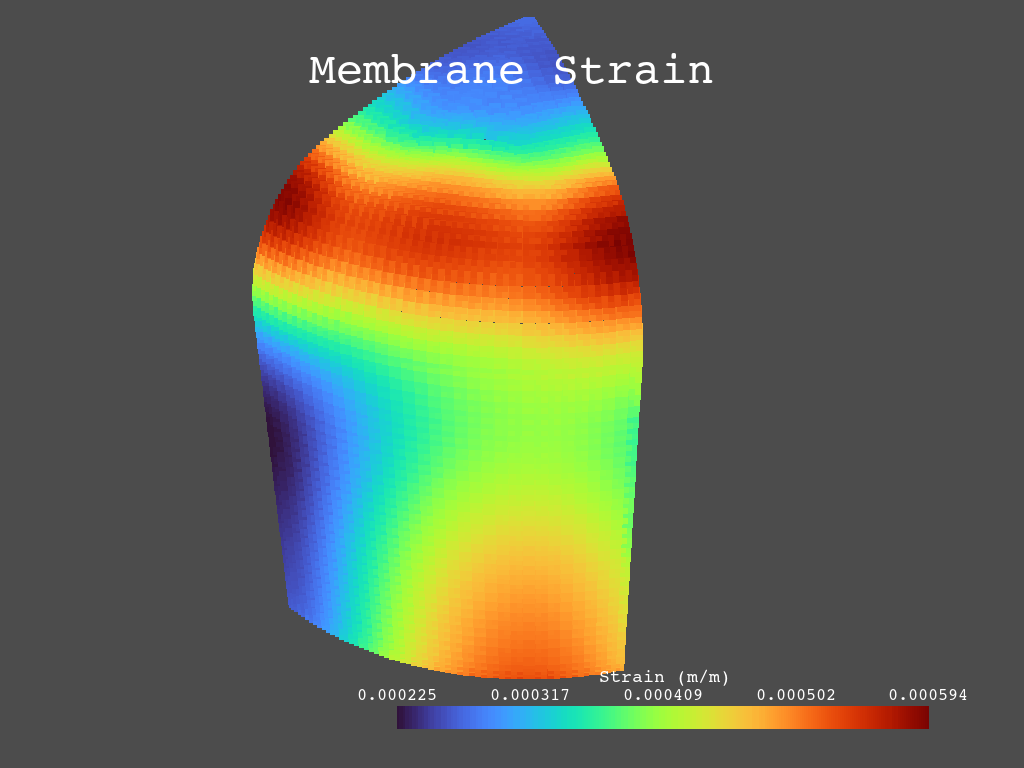

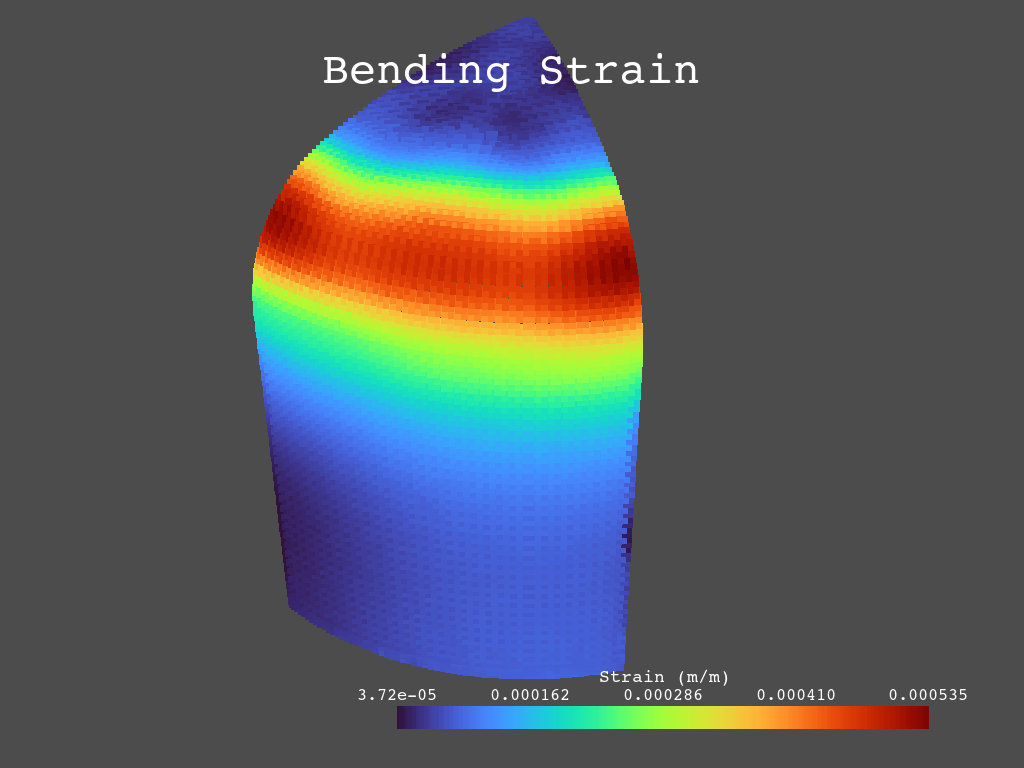

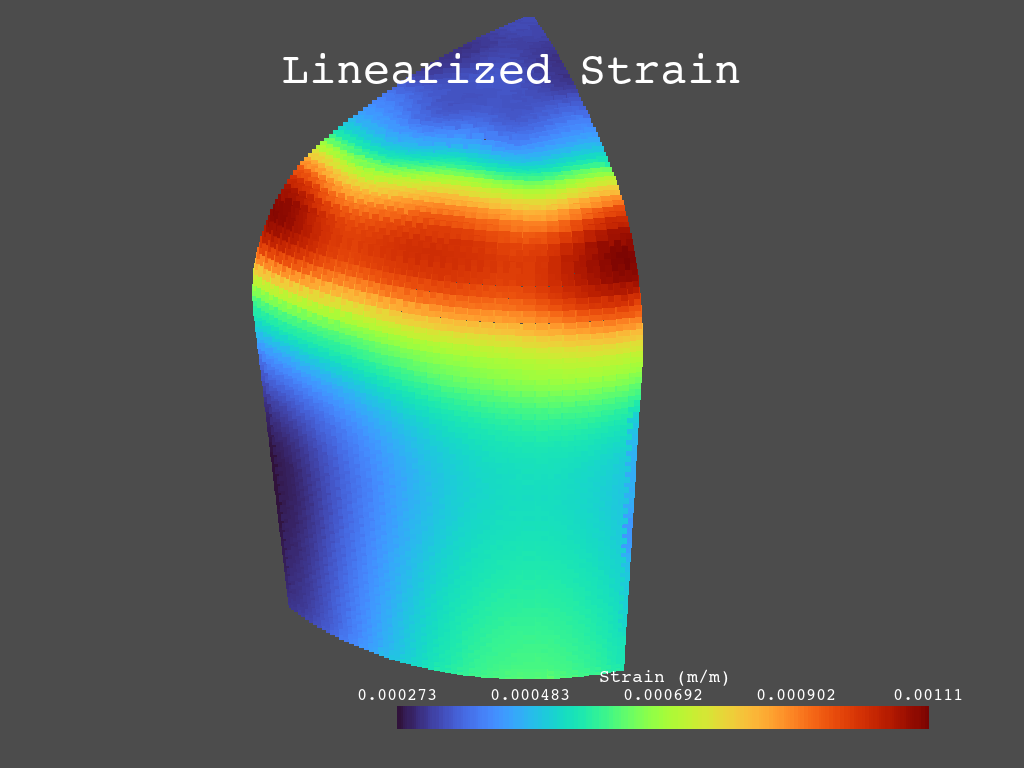

Conductivity: wl10_roedig
Structural: pure_w
Type: Elastic
Heat Loading: nominal


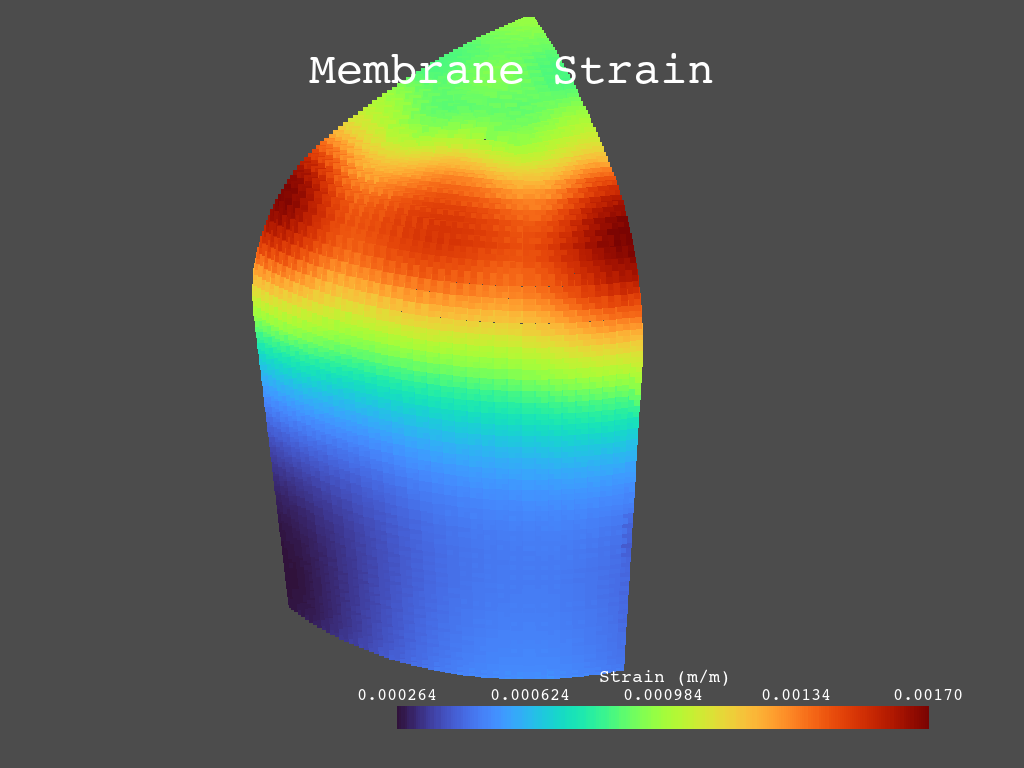

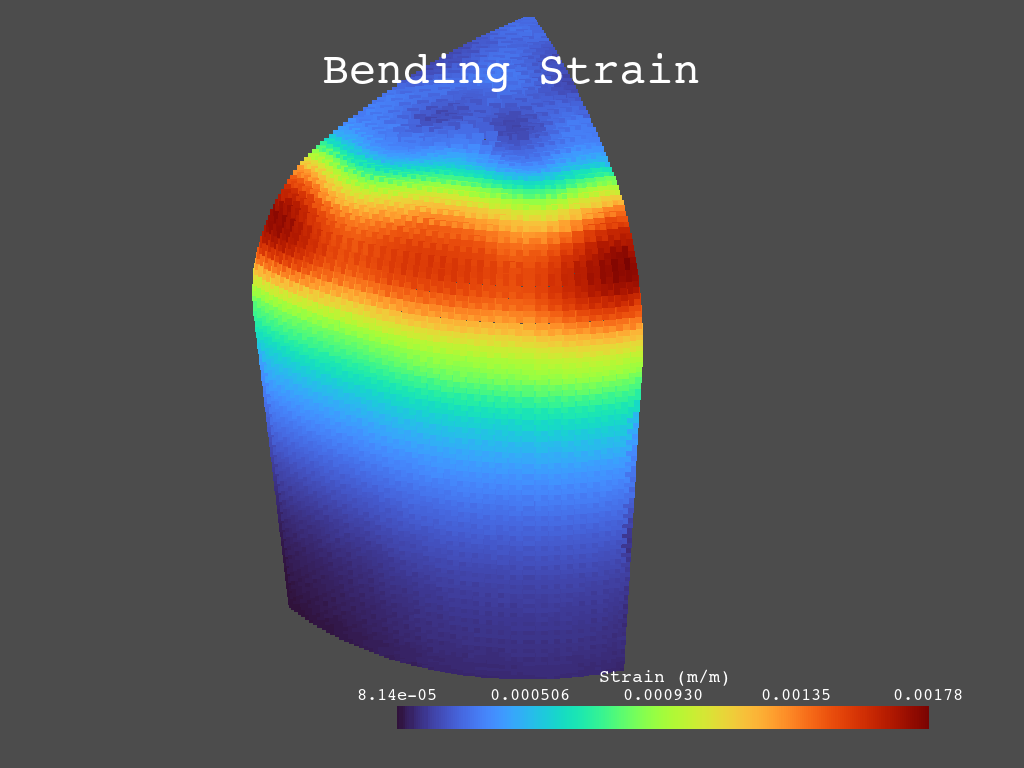

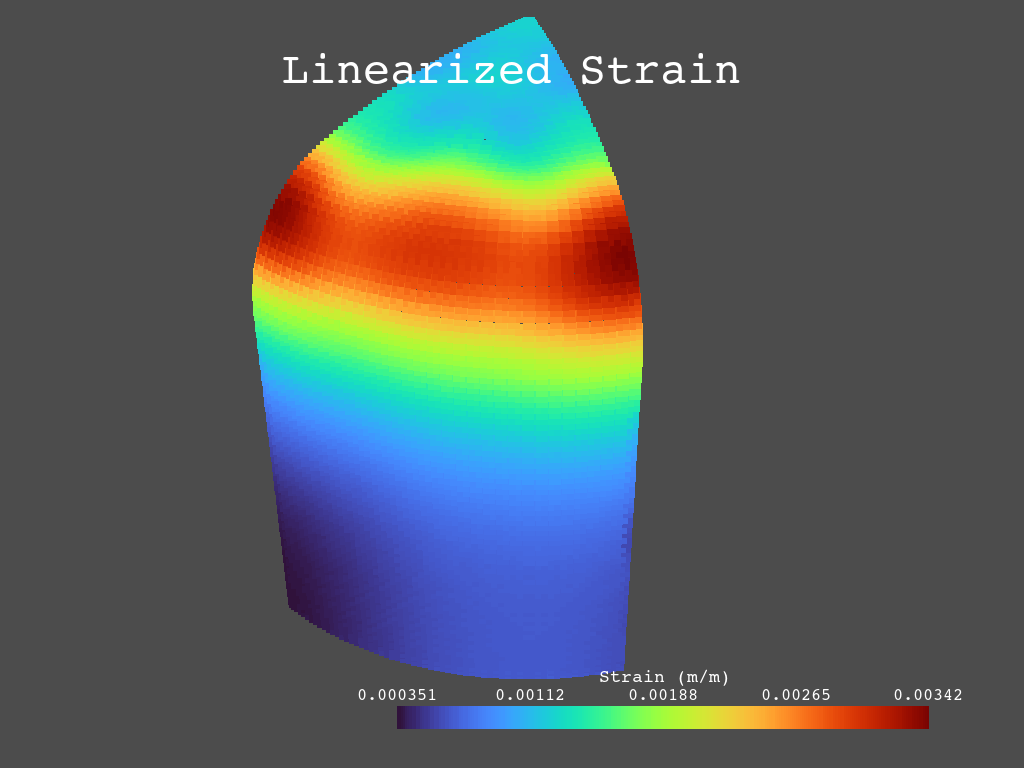

Conductivity: wl10_roedig
Structural: pure_w
Type: Elastic
Heat Loading: high


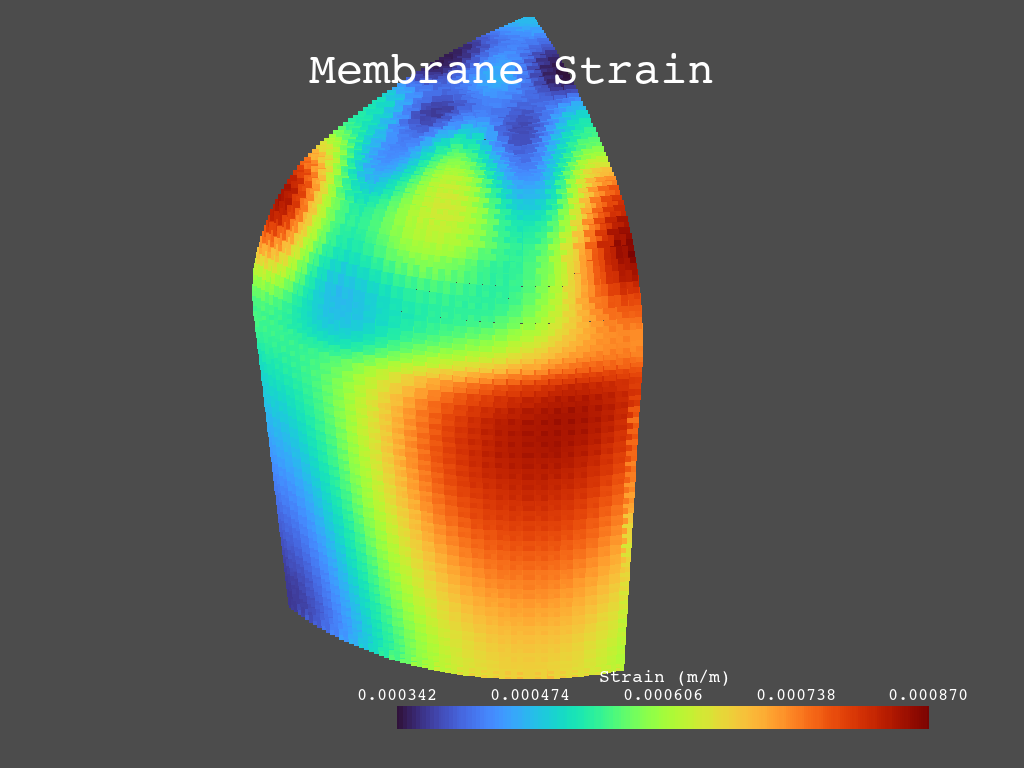

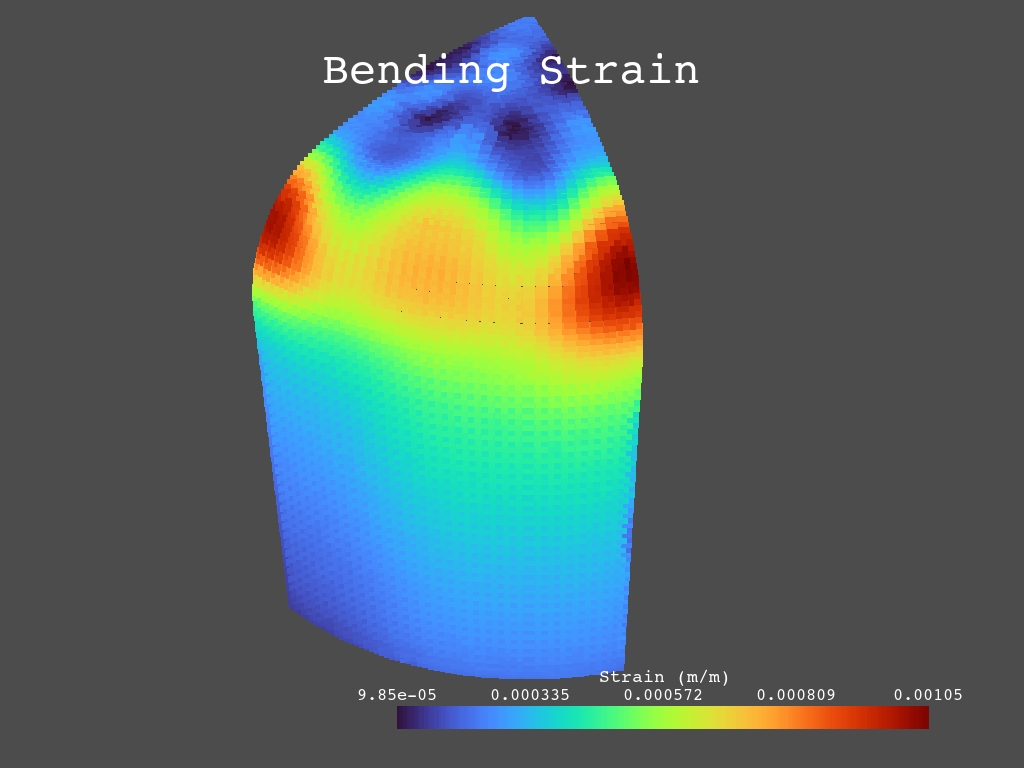

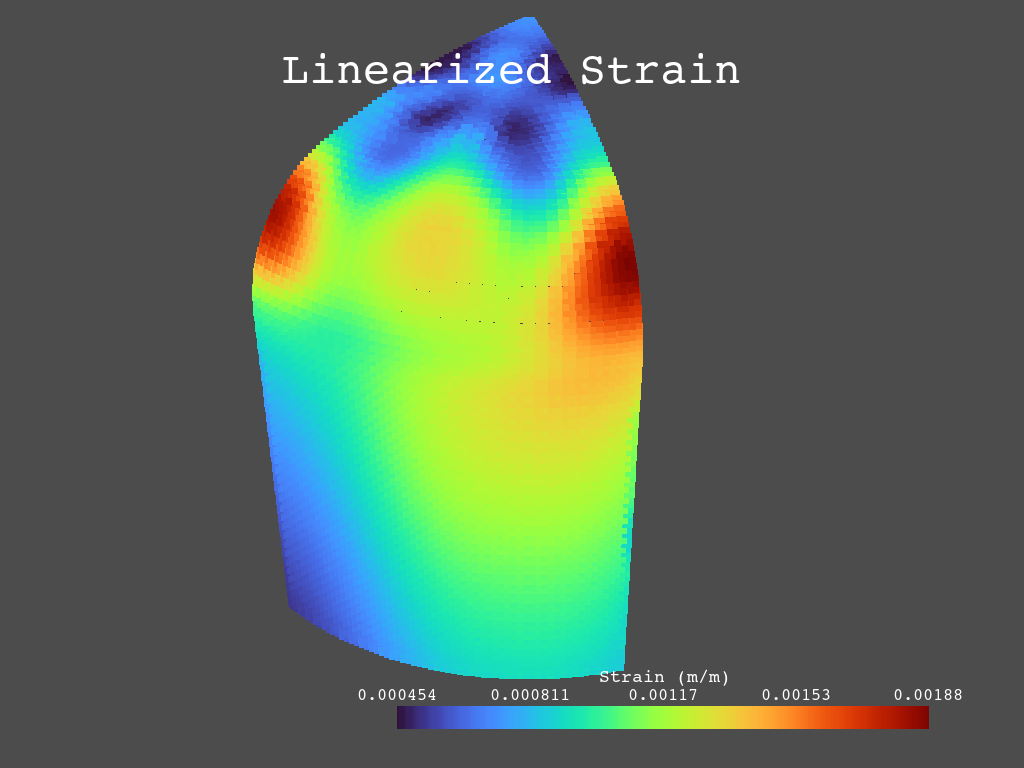

Max Membrane: [0.0005937490871667343, 0.0017040782711022085, 0.0008698705474844826]
Max Bending: [0.0005347028344709364, 0.001779511085570833, 0.0010452298444998504]
Max Linearized: [0.001111853126954321, 0.0034185816237738737, 0.0018823946829434157]
____________________________________
Conductivity: kdoped_rhenium
Structural: kdoped_rhenium
Type: Plastic
Heat Loading: low


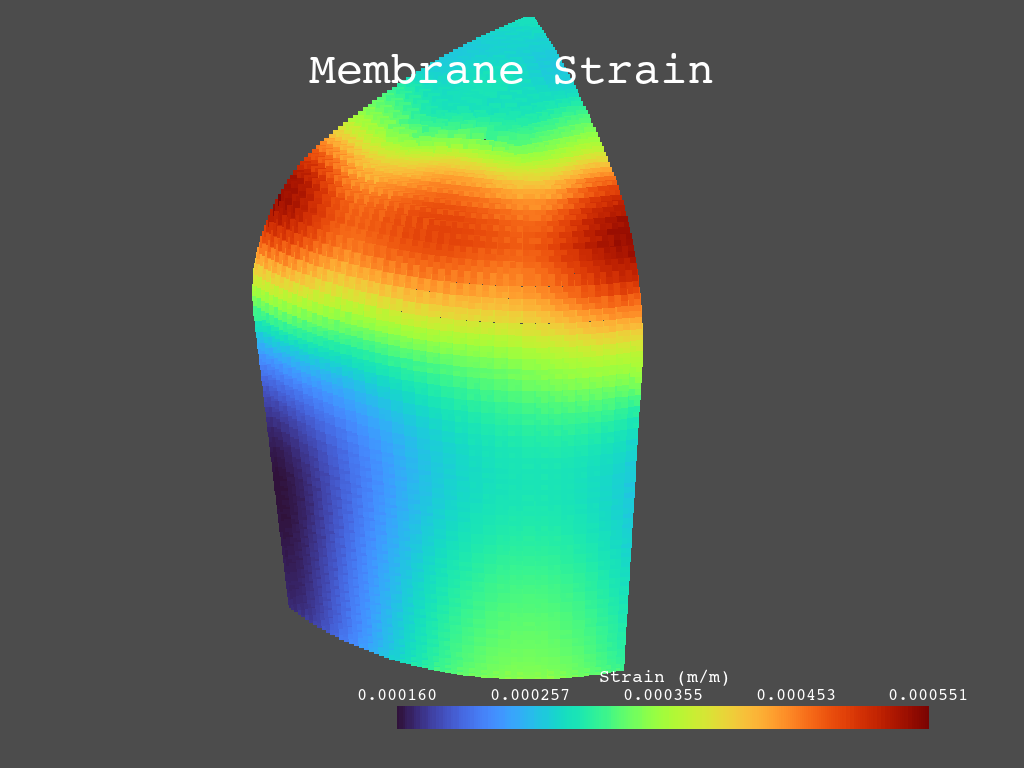

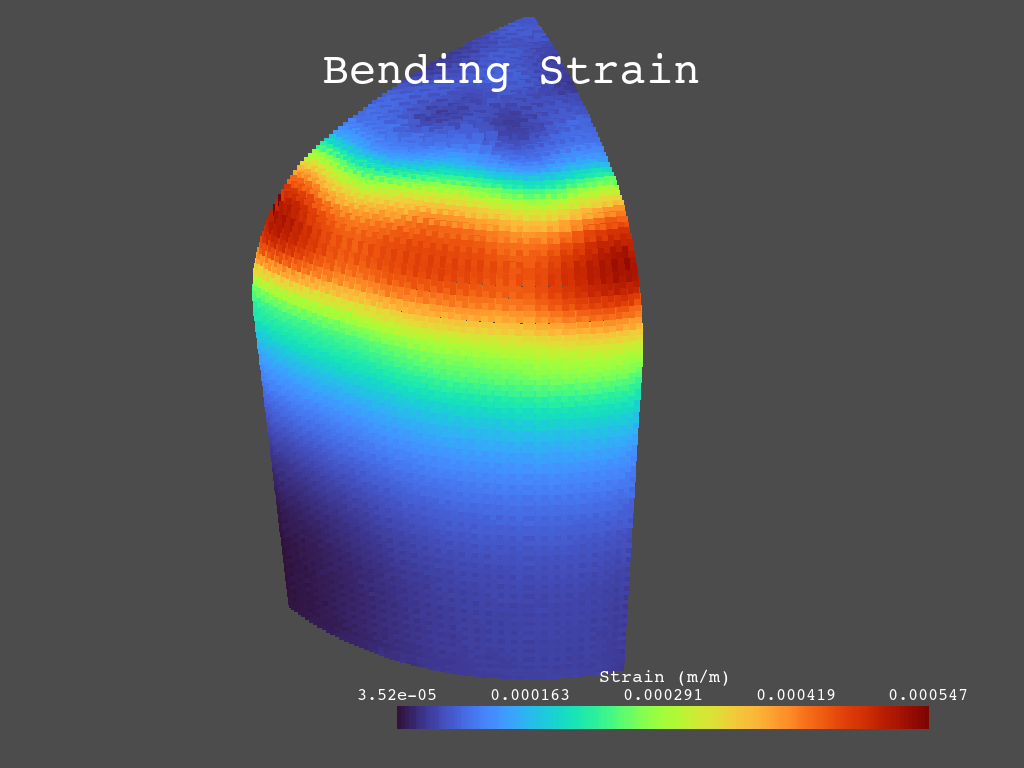

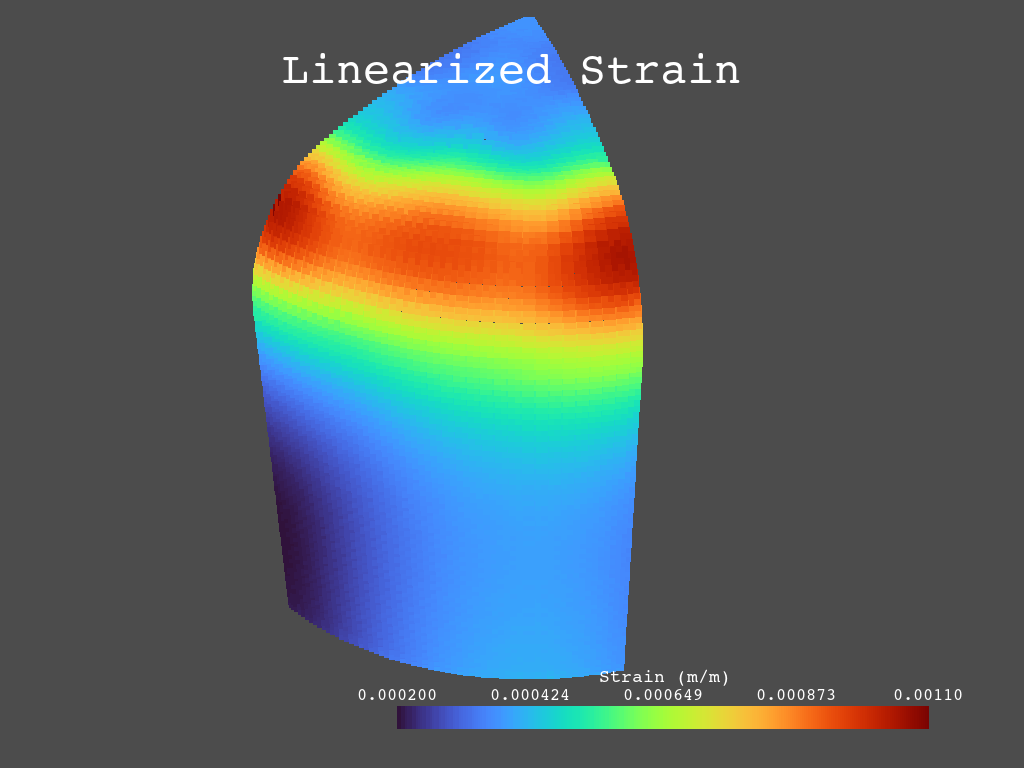

Conductivity: kdoped_rhenium
Structural: kdoped_rhenium
Type: Plastic
Heat Loading: nominal


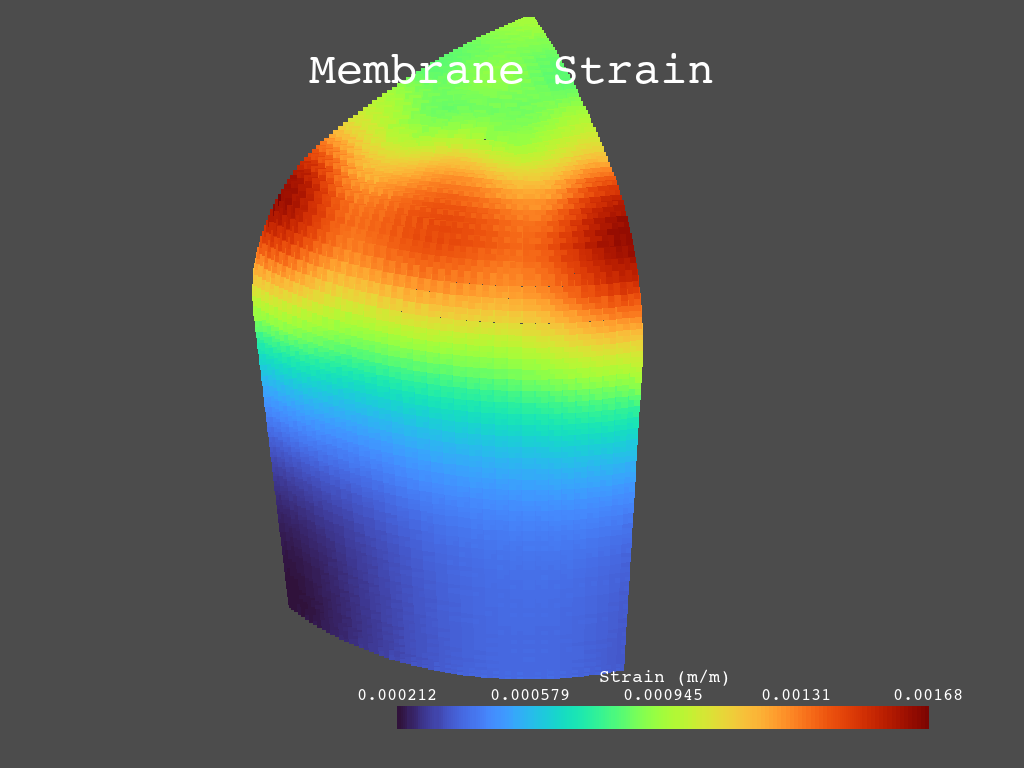

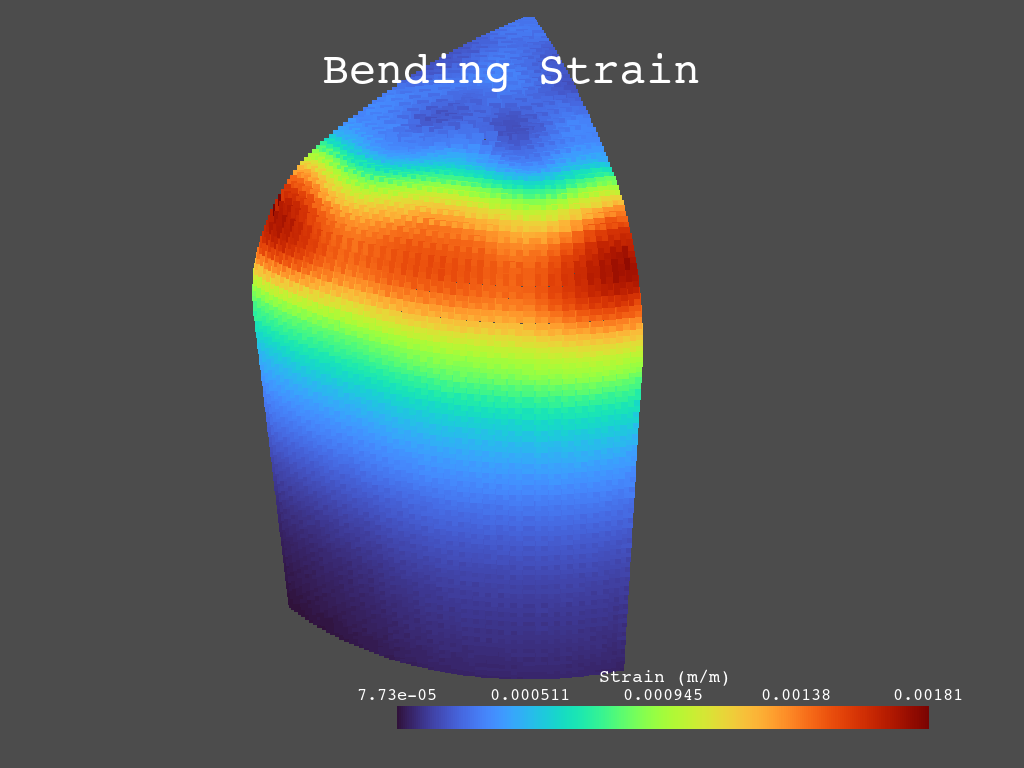

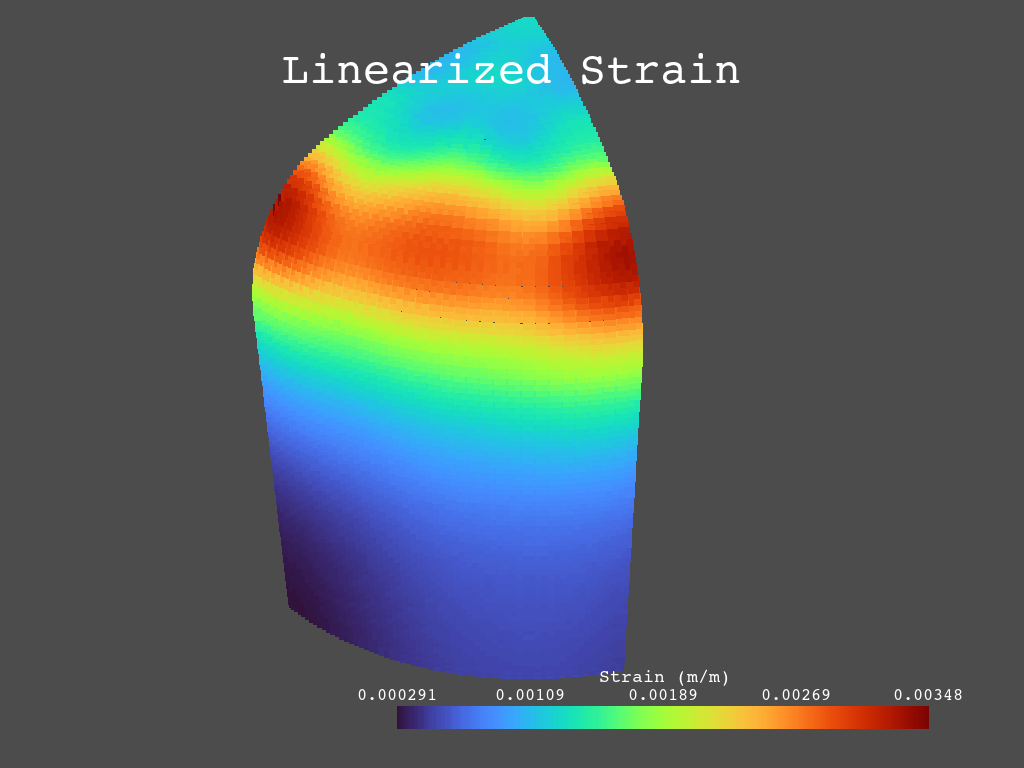

Conductivity: kdoped_rhenium
Structural: kdoped_rhenium
Type: Plastic
Heat Loading: high


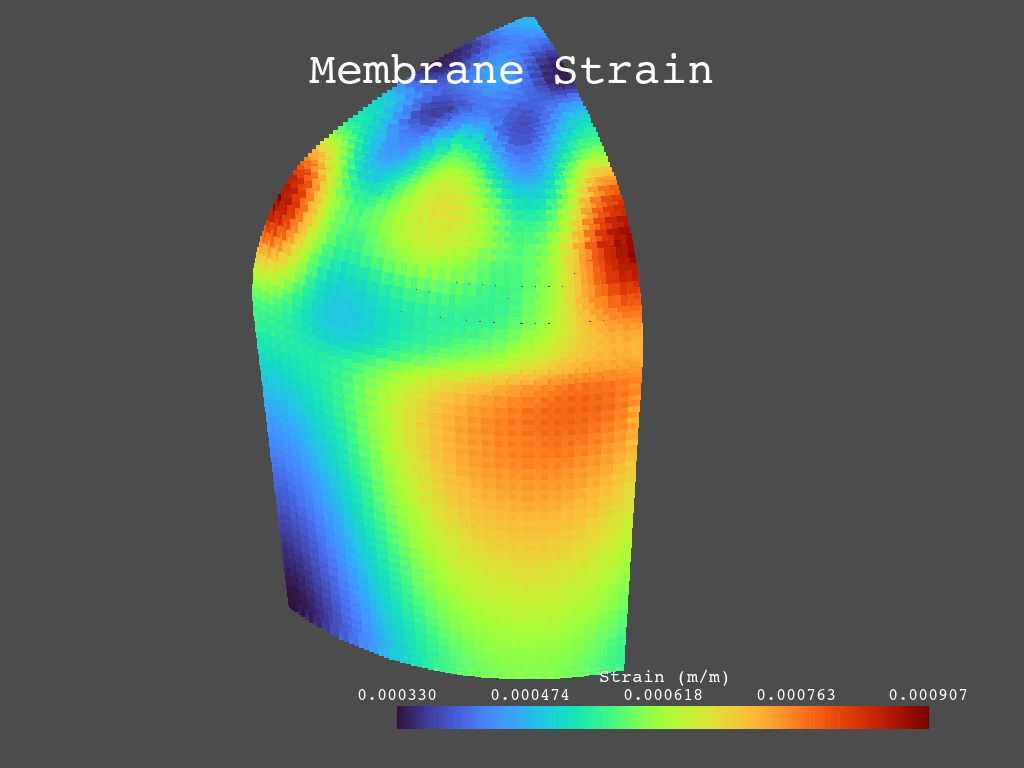

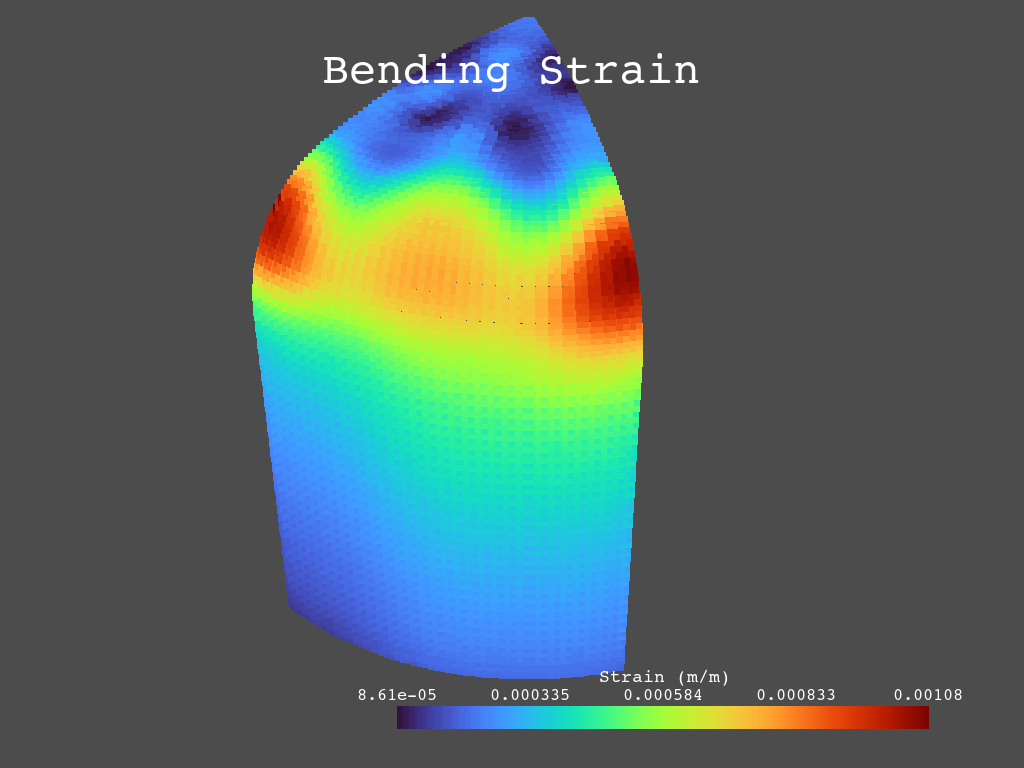

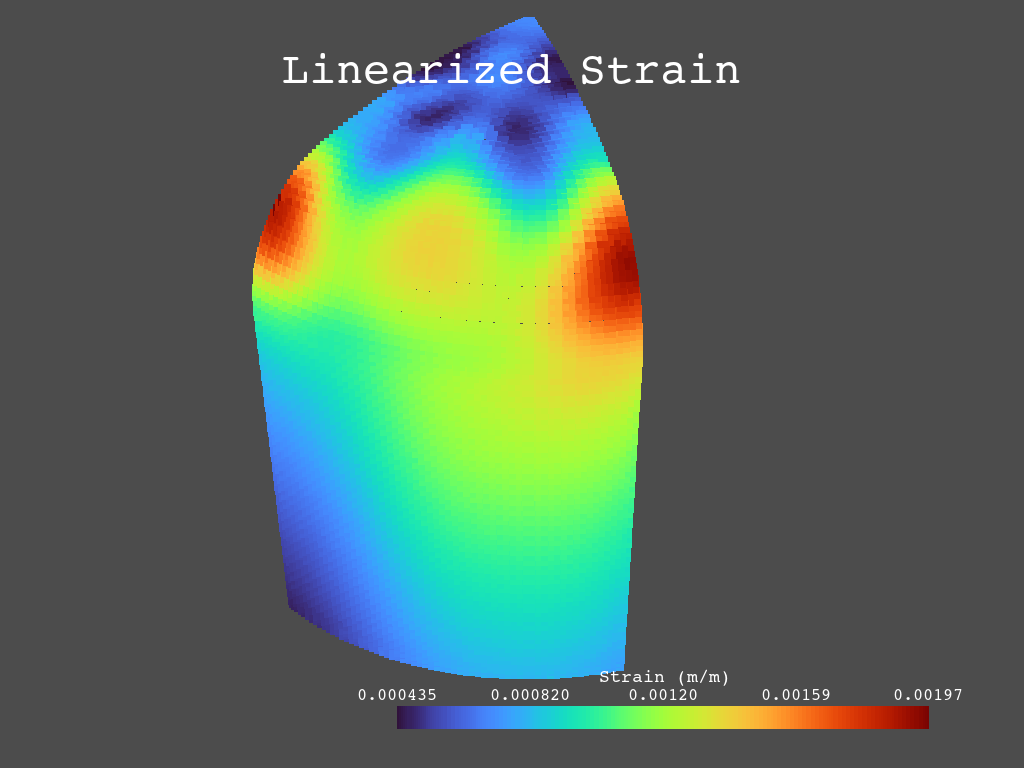

Max Membrane: [0.0005509901949814377, 0.0016780459271413784, 0.0009069282939534883]
Max Bending: [0.0005473957296386469, 0.001812432215805395, 0.0010816107524410606]
Max Linearized: [0.0010974941118699973, 0.0034832711317023665, 0.0019729792542195644]
____________________________________
Conductivity: wl10_roedig
Structural: pure_w
Type: Plastic
Heat Loading: low


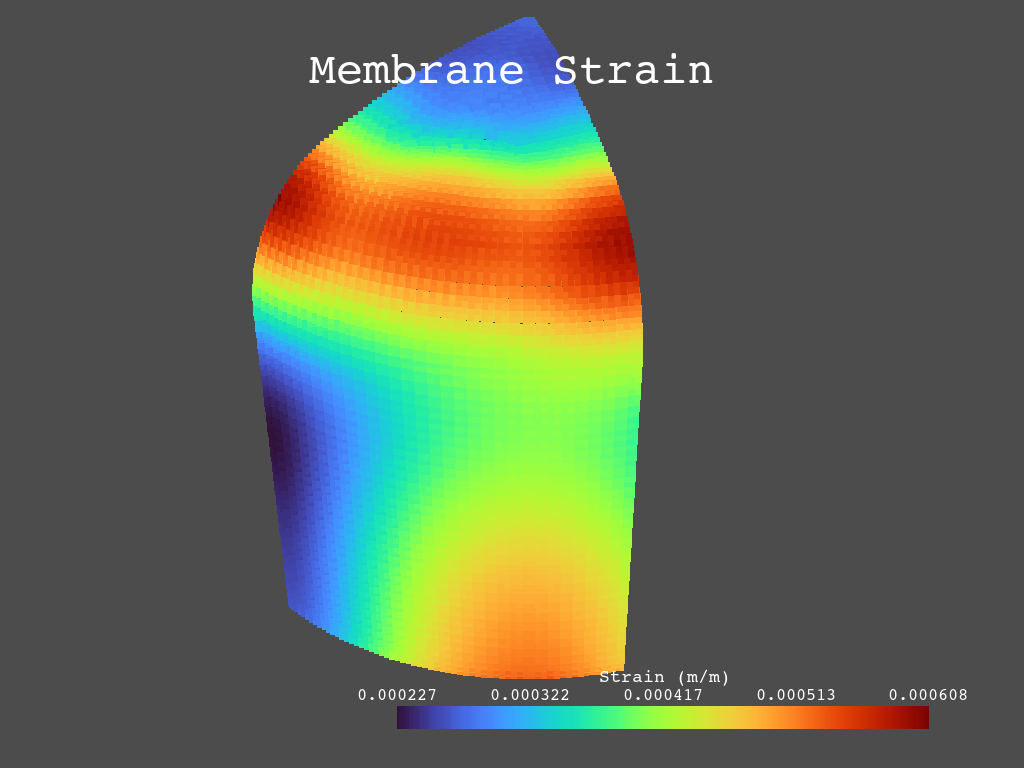

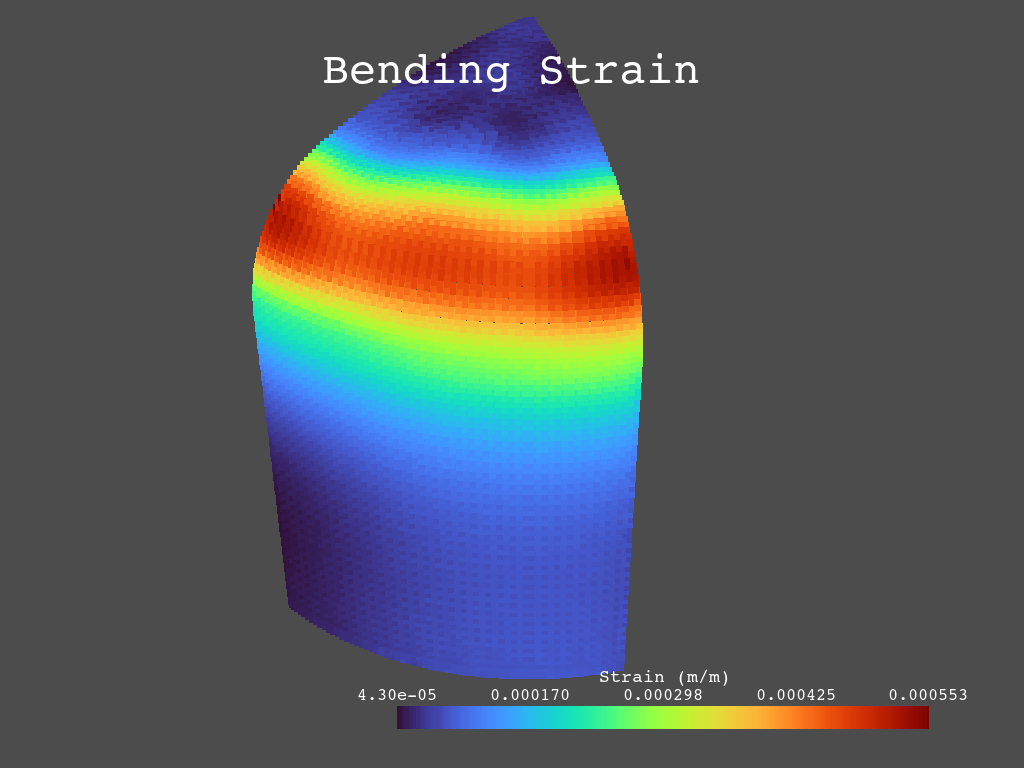

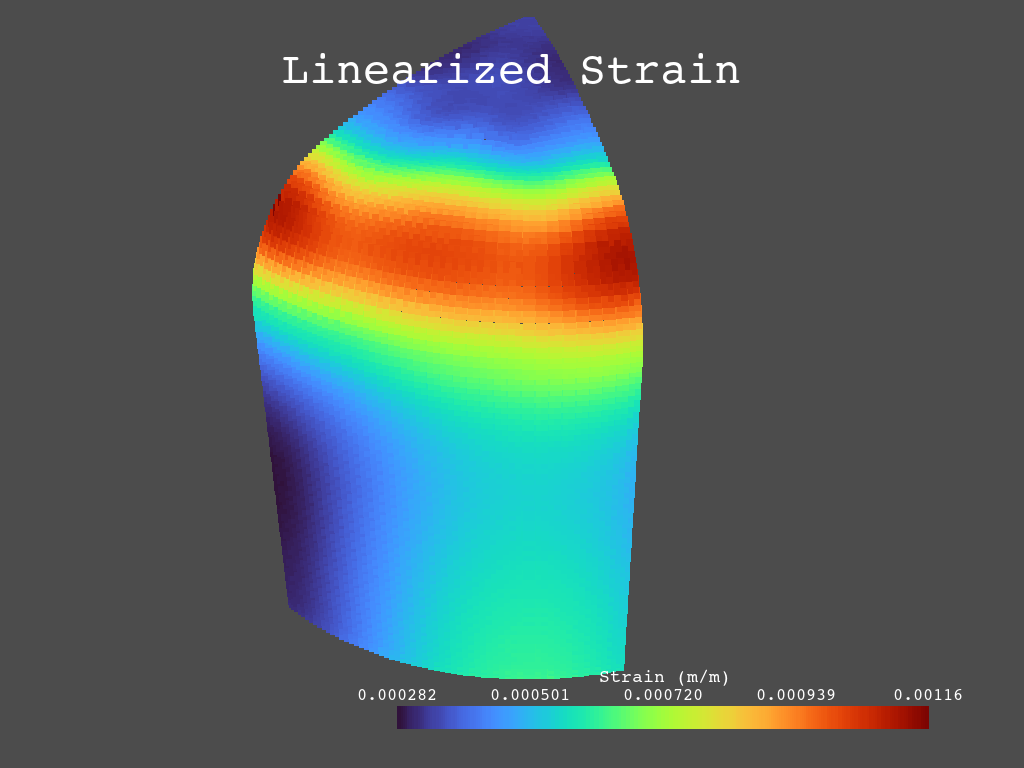

Conductivity: wl10_roedig
Structural: pure_w
Type: Plastic
Heat Loading: nominal


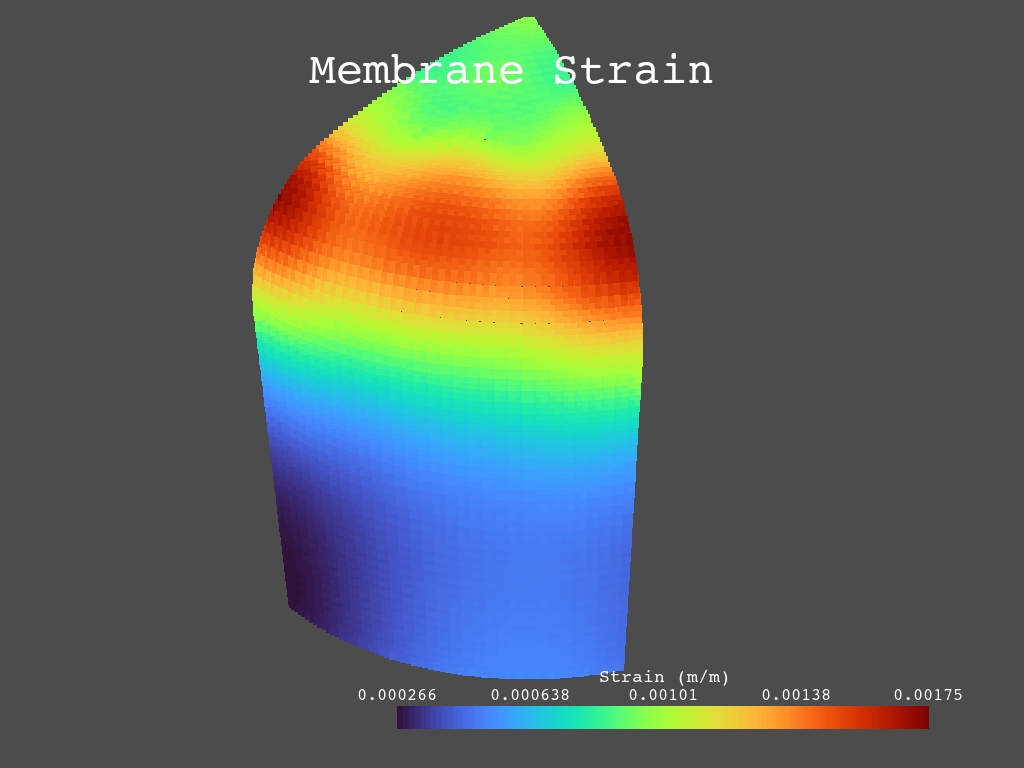

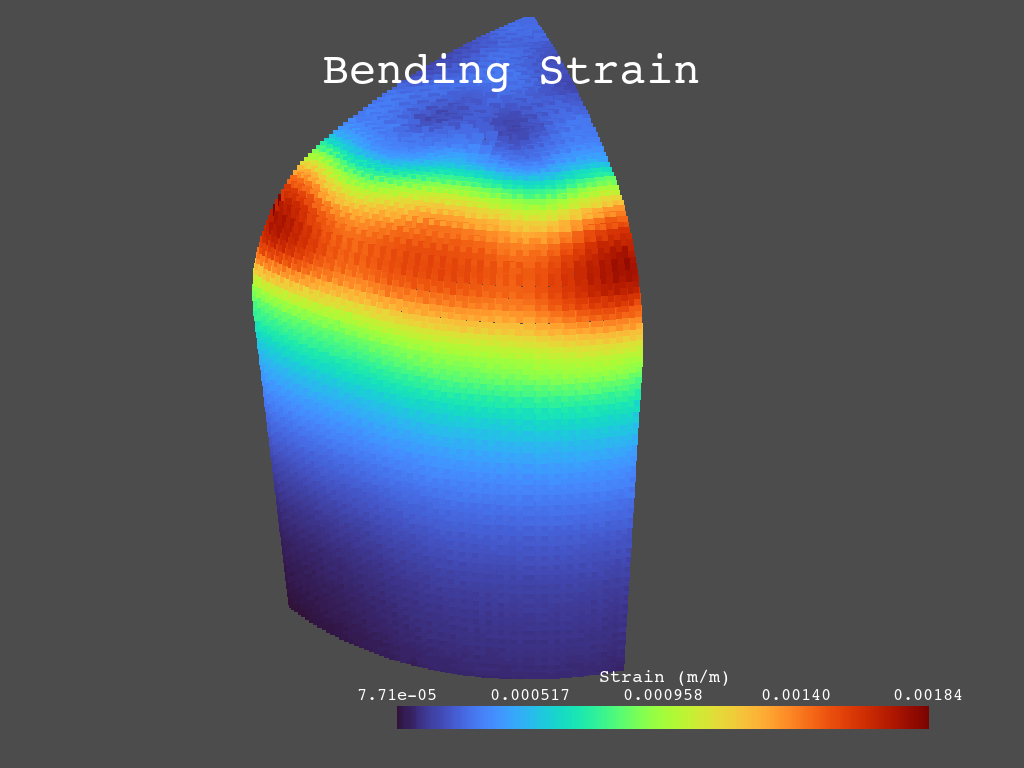

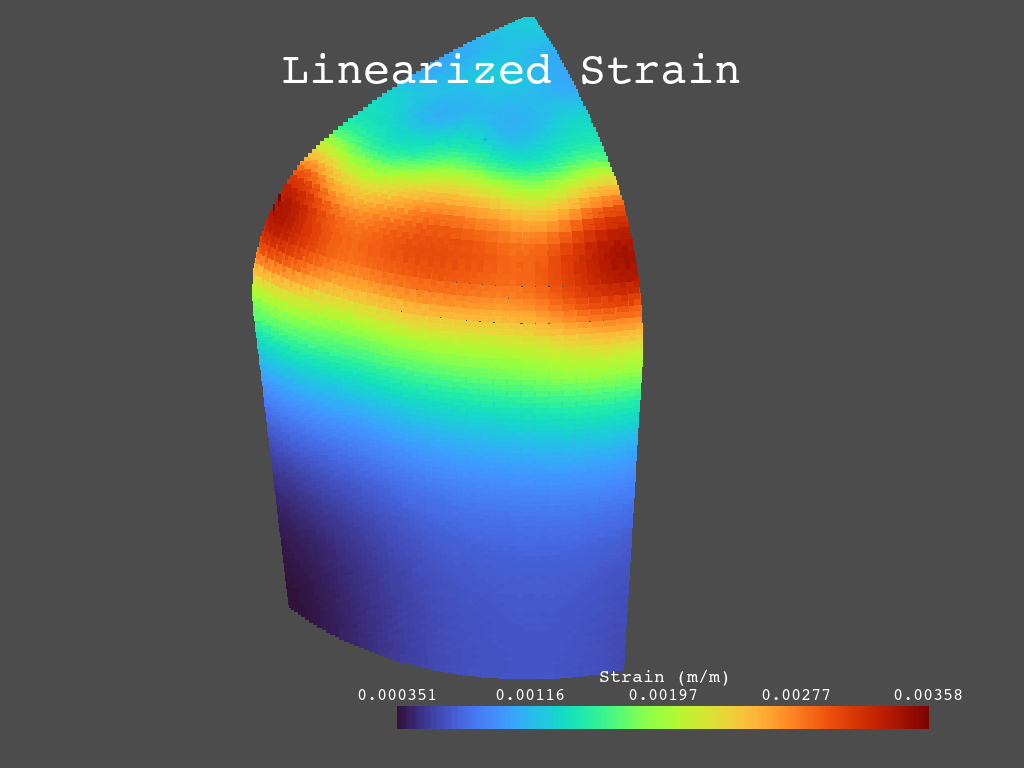

Conductivity: wl10_roedig
Structural: pure_w
Type: Plastic
Heat Loading: high


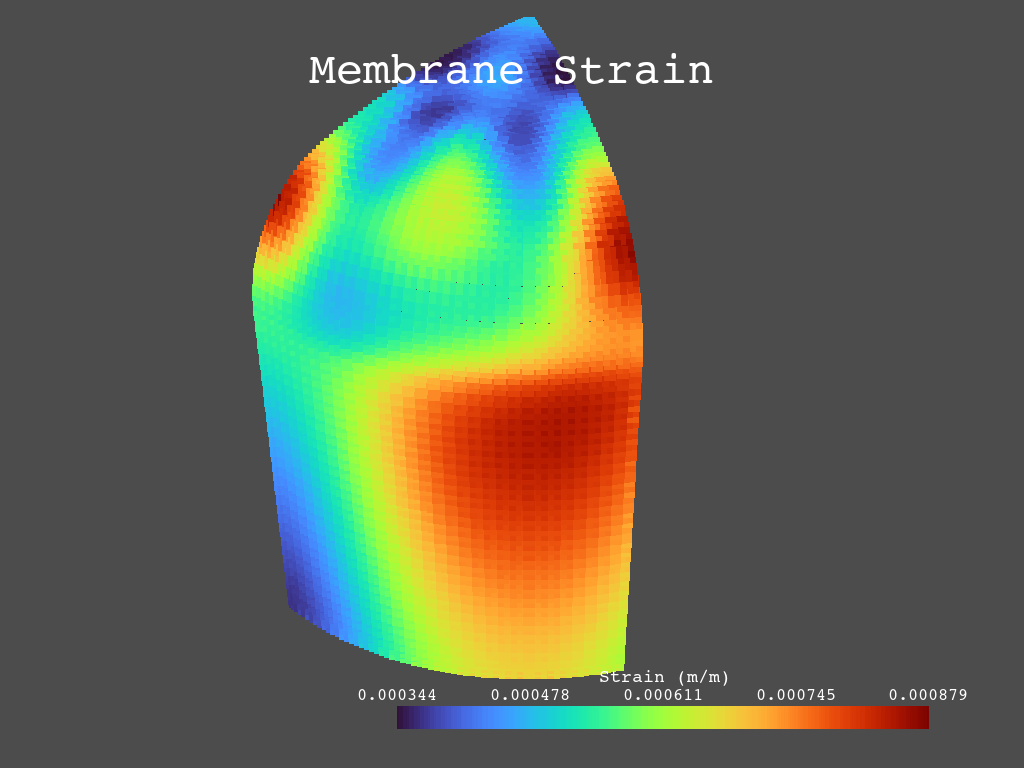

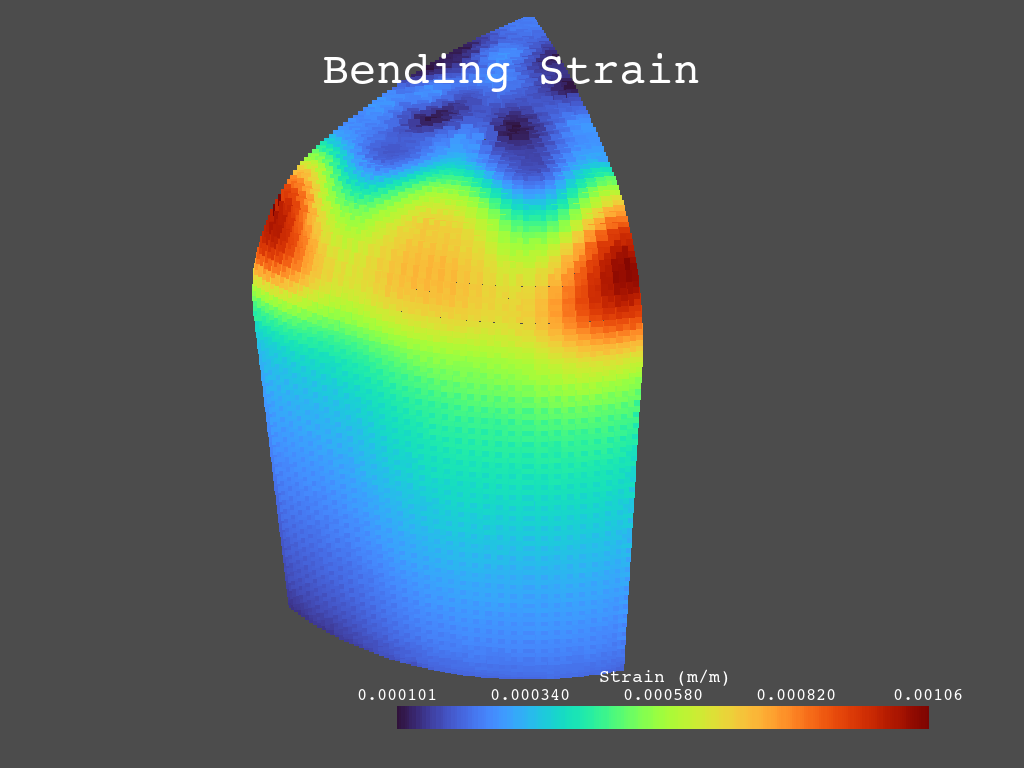

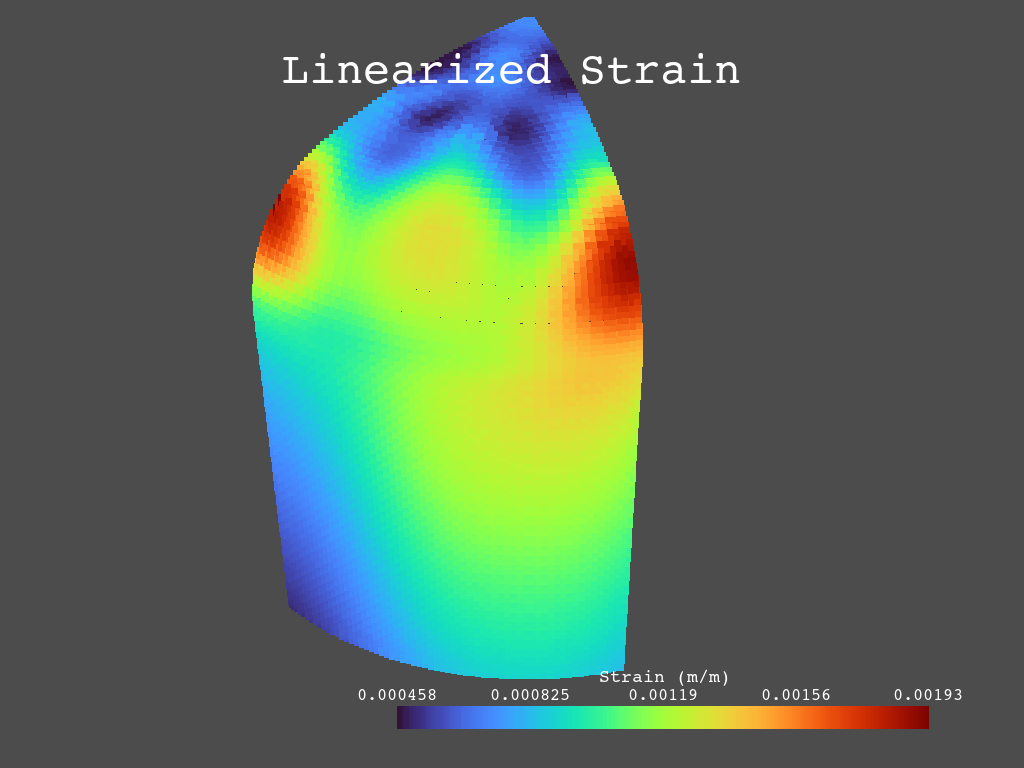

Max Membrane: [0.000608095015343063, 0.0017534029348342894, 0.0008790576465780968]
Max Bending: [0.0005526175820219548, 0.0018386698558300234, 0.001060199787406154]
Max Linearized: [0.0011576374918911647, 0.003581379939450167, 0.0019286279396892642]
____________________________________


In [10]:
strain_membrane, strain_bending, strain_linearized = plot_linearization(False)

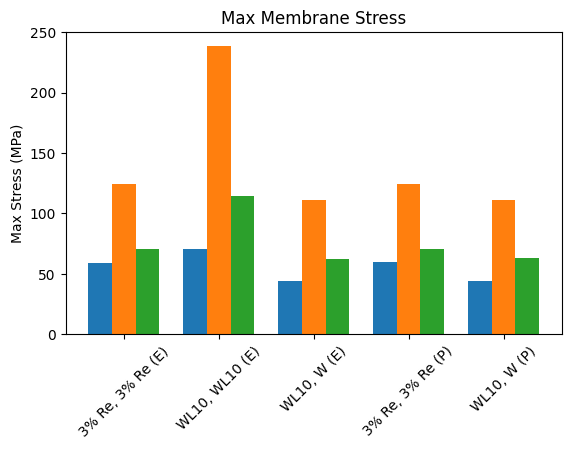

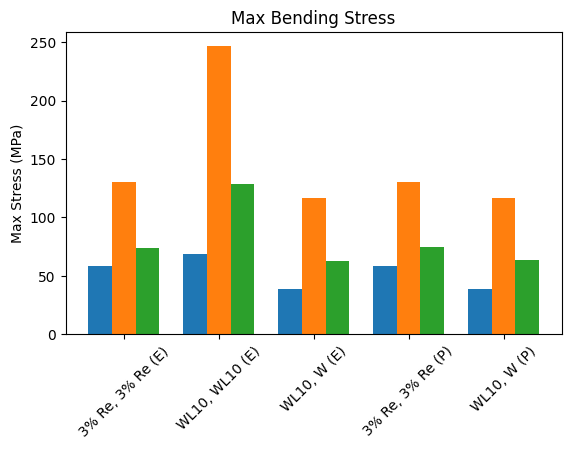

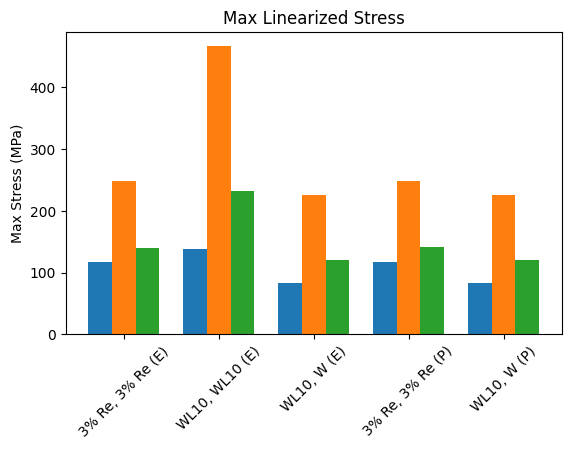

In [11]:
plot_bar_graph(stress_membrane, "Max Membrane Stress")
plot_bar_graph(stress_bending, "Max Bending Stress")
plot_bar_graph(stress_linearized, "Max Linearized Stress")

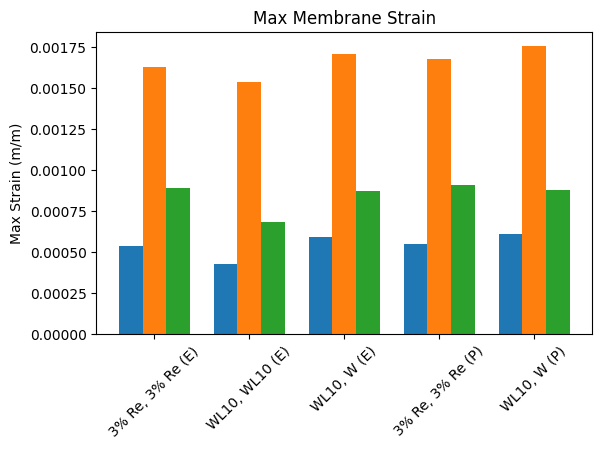

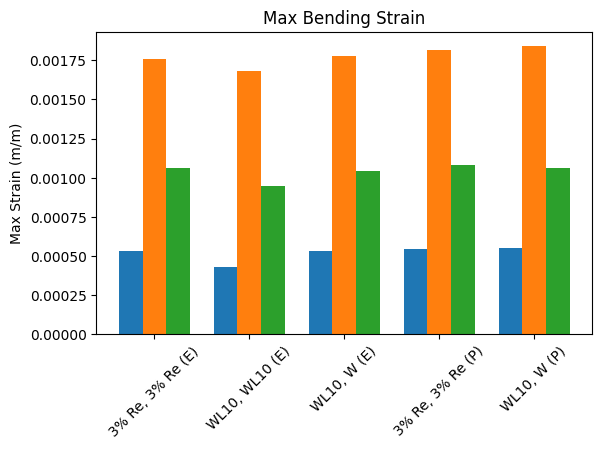

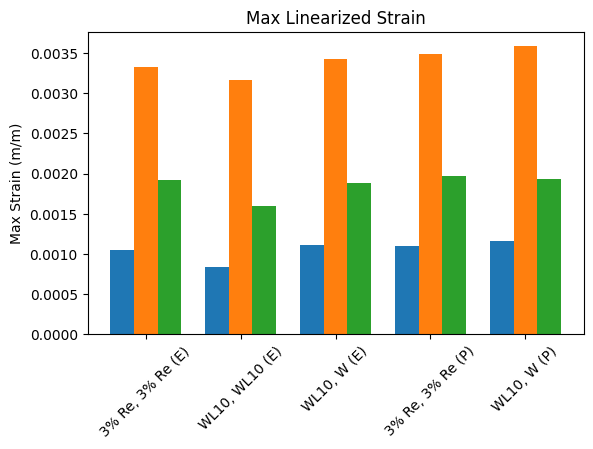

In [13]:
plot_bar_graph(strain_membrane, "Max Membrane Strain", stress=False)
plot_bar_graph(strain_bending, "Max Bending Strain", stress=False)
plot_bar_graph(strain_linearized, "Max Linearized Strain", stress=False)

Conductivity: kdoped_rhenium, Structural: kdoped_rhenium, elastic
low: 1088.25533749824 MPa
nominal: 1299.0463682689501 MPa
high: 1360.1511308506185 MPa

Conductivity: wl10_roedig, Structural: wl10_roedig, elastic
low: 1636.10419443889 MPa
nominal: 1835.8191922285644 MPa
high: 2604.4287539709767 MPa

Conductivity: wl10_roedig, Structural: pure_w, elastic
low: 736.3533624486558 MPa
nominal: 859.3923925793565 MPa
high: 1173.1383629367222 MPa

Conductivity: kdoped_rhenium, Structural: kdoped_rhenium, plastic
low: 679.1645891972913 MPa
nominal: 678.0286602618796 MPa
high: 600.0207312153084 MPa

Conductivity: wl10_roedig, Structural: pure_w, plastic
low: 528.0500580854716 MPa
nominal: 506.10115672840647 MPa
high: 502.21718981851404 MPa



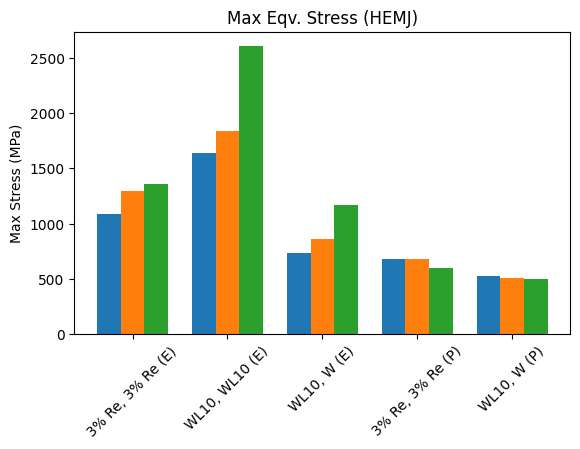

In [14]:
plot_eqv_stresses("Max Eqv. Stress (HEMJ)")